# Datasets (Sentiment) - Yelp - Categories

## Yelp

- https://www.yelp.com/dataset/documentation/main
- https://www.yelp.com/developers/documentation/v3/all_category_list

In [ ]:
#! wget -O data/sentiment/yelp/all_category_list.json https://www.yelp.com/developers/documentation/v3/all_category_list/categories.json

In [ ]:
#! pip install jsonlines

In [ ]:
#! pip install syntok

/disk1/users/ekoerner/miniconda3/envs/argmining19-ssc/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


[]

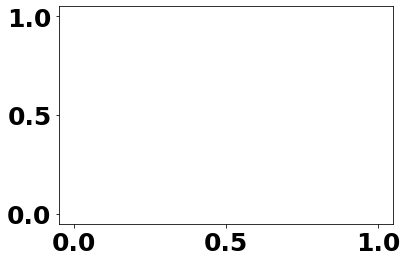

In [1]:
import json
import os
import random
import pickle
from collections import Counter
from copy import deepcopy
from itertools import combinations, groupby
from pathlib import Path
from pprint import pprint

import jsonlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.spatial.distance as ssd
from IPython.display import set_matplotlib_formats
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from syntok.tokenizer import Tokenizer
from tqdm import tqdm

tqdm.pandas()

%matplotlib inline
plt.rcParams.update({"font.size": 25, "font.weight": "bold"})
# https://stackoverflow.com/questions/36622237/jupyter-notebook-inline-plots-as-svg
# set_matplotlib_formats("svg")  # glitches it
plt.plot()

In [2]:
from utils_data import init_random
init_random()

In [3]:
# download + scp to cuda + extract
# Path on CUDA2
data_yelp_path = Path("/disk1/users/ekoerner/argmining19-same-side-classification/data/sentiment/yelp/")
# CUDA1?
#data_yelp_path = Path("/disk1/users/ekoerner/same-side-classification/argmining19-same-side-classification/data/sentiment/yelp/")

---

#### Load reviews / categories (topics) + filter cats/make combinations

In [4]:
def load_reviews(fn_yelp_reviews):
    """Load Yelp reviews. Return a Pandas dataframe.
    Format: {"id": business_id, "rid": review_id, "text": text, "rating": rating}
    And add goodness bool (rating > 3)."""
    data = list()

    with jsonlines.open(fn_yelp_reviews, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            # print(entry)
            # break
            business_id = entry.pop("business_id")
            review_id = entry.pop("review_id")
            text = entry.pop("text", "")
            rating = entry.pop("stars", 0.0)
            data.append({"id": business_id, "rid": review_id, "text": text, "rating": rating})
            # TESTING
            # if n > 10000:
            #     break

    df = pd.DataFrame.from_dict(data)
    
    # Add goodness value
    # TODO: maybe ignore with 3
    df["goodness"] = df["rating"] > 3
    
    return df


def load_topics(fn_yelp_topics, bids_not_cats=None, filter_cats=None, filter_cat_combis=None):
    """Load topics (categories).
    Optionally filter by giving it a whitelist of allowed categories.
    Optionally filter by giving a list of allowed category combinations.
    Optionally provide an IN/OUT param ``bids_not_cats`` that accumulates business ids without categories."""
    inv_bid_cats = dict()
    if bids_not_cats is None or not isinstance(bids_not_cats, set):
        bids_not_cats = set()
    
    # load lookup business -> categories
    with jsonlines.open(fn_yelp_topics, "r") as fp:
        for n, entry in enumerate(tqdm(fp)):
            business_id = entry.pop("business_id")
            categories = entry.pop("categories")

            if not categories:
                bids_not_cats.add(business_id)
                continue

            categories = categories.split(", ")
            
            if filter_cats:
                categories = [c for c in categories if c in filter_cats]
                if not categories:
                    # bids_not_cats.add(business_id)  # ??
                    continue
                    
            if filter_cat_combis:
                # skip if combination is not above threshold (of filter list)
                if tuple(sorted(set(categories))) not in filter_cat_combis:
                    continue

            inv_bid_cats[business_id] = categories
    
    return inv_bid_cats

In [5]:
def filter_min_cat_combis(inv_cat_combis, min_num=30):
    """Filter category combinations by minimum amount of occurrences in businesses"""
    f_inv_cat_combis = dict()
    
    for cats, num in inv_cat_combis.items():
        if num >= min_num:
            f_inv_cat_combis[cats] = num
    
    return f_inv_cat_combis


def make_map_cats(inv_bid_cats):
    """Make a map from category to business id"""
    inv_cat_bids = dict()

    # reverse lookup: category -> businesses
    for bid, cats in tqdm(inv_bid_cats.items()):
        for cat in cats:
            try:
                inv_cat_bids[cat].append(bid)
            except KeyError:
                inv_cat_bids[cat] = [bid]
                
    ## TODO: make distinct?
    for cat in inv_cat_bids.keys():
        inv_cat_bids[cat] = list(set(inv_cat_bids[cat]))
                
    return inv_cat_bids


def make_cat_combis(inv_bid_cats):
    """Count amount of each category combination occurring in businesses"""
    inv_cat_combis = Counter()

    inv_cat_combis.update(
        (tuple(sorted(set(cats))) for cats in tqdm(inv_bid_cats.values())))
    
    return inv_cat_combis

#### Filter reviews according to criteria

In [6]:
def filter_min_review_freq(df, min_ratings=5):
    """Filter review dataframe for a minimum of N of each good and bad ratings."""
    # filter with at least N ratings per goodness
    df_filter = df.groupby(["id", "goodness"])[["id"]].count() < min_ratings
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # build a filter id list
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[~df.id.isin(df_filter_list)]
    
    return df_filtered


def filter_both_good_bad(df):
    """Filter the dataframe to contain only both good and bad reviews for each business.
    Dataframe should be the same if minimum filtering above is done."""
    # build filter for ids that contain both positive and negative samples
    df_filter = df.groupby(["id", "goodness"], as_index=False).count().groupby("id")[["id"]].count() == 2
    df_filter = df_filter.rename(columns={"id": "filter"})
    df_filter = df_filter[df_filter["filter"] == True]

    # create list of IDs for which this is true
    df_filter_list = df_filter.reset_index()["id"].to_list()

    # filter with list
    df_filtered = df[df.id.isin(df_filter_list)]

    # df_filtered.groupby(["id", "goodness"]).count()
    return df_filtered

In [7]:
def filter_by_businesses(df, lst_business_ids):
    # filter with list, keep businesses in list
    df_filtered = df[df.id.isin(set(lst_business_ids))]

    return df_filtered


def filter_by_businesses_not_same(df, lst_business_ids):
    # filter with list, keep businesses that are not in list
    df_filtered = df[~df.id.isin(set(lst_business_ids))]

    return df_filtered

#### Get topN categories + make Ntuples from category combinations

In [8]:
def get_Ntop_cats(inv_cat_bids, n=50):
    # get most common cats
    f_cat_cnt = Counter({k: len(v) for k, v in inv_cat_bids.items()})
    f_cats = {c for c, v in f_cat_cnt.most_common(n)}
    return f_cats


def make_cat_Ntuples(f_inv_cat_combis, n=2):
    f_cat_pairs = Counter()

    for cat_group in tqdm(f_inv_cat_combis.keys()):
        if len(cat_group) < n:
            continue
        it = combinations(cat_group, n)
        # repeat (#num_businesses) + chain combis
        f_cat_pairs.update(it)
        
    return f_cat_pairs

#### Make category graph or NxN map (df + array)

In [9]:
def make_graph(f_cat_pairs):
    g_from, g_to, g_value = zip(*((k1, k2, n) for (k1, k2), n in tqdm(f_cat_pairs.most_common())))

    g_df = pd.DataFrame({"from": g_from, "to": g_to, "value": g_value})
    G = nx.from_pandas_edgelist(g_df, "from", "to", create_using=nx.Graph())
    
    return G


def make_NxN_map(f_cats, f_cat_pairs):
    f_cats = list(f_cats)
    array = list()
    for i, cat1 in enumerate(tqdm(f_cats)):
        array_row = list()
        for j, cat2 in enumerate(f_cats):
            array_row.append(f_cat_pairs.get((cat1, cat2), f_cat_pairs.get((cat2, cat1), 0)))
        array.append(array_row)
    df_cm = pd.DataFrame(array, index=list(f_cats), columns=list(f_cats))
    
    # dataframe, NxN array + labels
    return df_cm, array, f_cats

---

#### Load categories hierarchy

In [10]:
def load_category_tree(fn_all_category_list):
    with open(fn_all_category_list, "r") as fp:
        content = fp.read()
        data = json.loads(content)

    map_categories = dict()
    map_cat_name2id = dict()
    lst_root_categories = list()

    # load basic lookups
    for item in data:
        # .alias (id)
        map_categories[item["alias"]] = item
        # .title
        map_cat_name2id[item["title"]] = item["alias"]
        # .parents
        # some have multiple parents ...
        if not item["parents"]:
            lst_root_categories.append(item["alias"])
        # add list of children
        item["children"] = list()

    # add children
    for cid, item in map_categories.items():
        for parent_cid in item["parents"]:
            map_categories[parent_cid]["children"].append(item["alias"])

    return map_categories, map_cat_name2id, lst_root_categories


def get_root_category_items(map_categories):
    lst_root_categories = list()

    for cid, item in map_categories.items():
        if not item["parents"]:
            lst_root_categories.append(item)
            
    return lst_root_categories


def get_children_category_item_list(map_categories, parent_cid):
    return [
        map_categories[child_cid]
        for child_cid in map_categories[parent_cid]["children"]
    ]

##### Get businesses in categories

In [11]:
def get_businesses_in_category(inv_cat_bids, category):
    try:
        return list(set(inv_cat_bids[category]))
    except KeyError:
        return []
    
    
def get_businesses_in_category_branch(inv_cat_bids, category, map_categories, map_cat_name2id):
    map_cat_id2name = {cid: name for name, cid in map_cat_name2id.items()}

    def _get_recursive_businesses(cat_name):
        businesses = get_businesses_in_category(inv_cat_bids, cat_name)

        cid = map_cat_name2id[cat_name]
        for child_cid in map_categories[cid]["children"]:
            child_name = map_cat_id2name[child_cid]
            businesses.extend(_get_recursive_businesses(child_name))
        
        return businesses
    
    return _get_recursive_businesses(category)

##### Print category trees

In [12]:
def print_category_tree(map_categories):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            if level:
                print("  " * level, end="")
            print(f"""{item["title"]} [{item["alias"]}]""", end="")
            if item["children"]:
                print(f""" [#{len(item["children"])} children]""")
            else:
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
    _print_cat_list_rec(root_categories, level=0)


def print_category_tree_with_num_businesses(map_categories, inv_cat_bids):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            if item["title"] not in inv_cat_bids:
                print(" No businesses associated!")
            else:
                print(f""" {len((inv_cat_bids[item["title"]])):>5d} businesses""")
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    

def print_category_tree_with_num_businesses_rec(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    def _print_cat_list_rec(lst_cats, level=0):
        for item in sorted(lst_cats, key=lambda x: x["title"]):
            cur_line = " ." * 30
            parts = list()

            if level:
                parts.append("  " * level)
            parts.append(f"""{item["title"]} [{item["alias"]}]""")
            
            str_len = sum(len(part) for part in parts)
            print("".join(part for part in parts), end="")
            print(cur_line[str_len:], end="")
            
            businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
            businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
            if not businesses:
                print(" No businesses associated!")
            else:
                businesses = set(businesses)
                print(f""" {len(businesses):>5d} businesses""", end="")
                if len(businesses) != len(businesses_self):
                    print(f""" (self: {len(businesses_self)})""", end="")
                print()
            
            children = get_children_category_item_list(map_categories, item["alias"])
            _print_cat_list_rec(children, level=level + 1)
            
            if level == 0:
                print()
            
    _print_cat_list_rec(root_categories, level=0)
    
    
def print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()
        

def print_category_tree_with_num_businesses_root2(map_categories, inv_cat_bids, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    for item in root_categories:
        item["businesses"] = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        item["businesses_self"] = get_businesses_in_category(inv_cat_bids, item["title"])
    
    for item in sorted(root_categories, key=lambda x: len(set(x["businesses"]))):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = item["businesses"]
        businesses_self = item["businesses_self"]

        businesses = set(businesses)
        print(f""" {len(businesses):>5d} businesses""", end="")
        if len(businesses) != len(businesses_self):
            print(f""" (self: {len(businesses_self)})""", end="")
        print()

In [13]:
def print_category_tree_with_num_reviews_root(map_categories, inv_cat_bids, map_cat_name2id, df_reviews):
    root_categories = get_root_category_items(map_categories)
    
    for item in sorted(root_categories, key=lambda x: x["title"]):
        cur_line = " ." * 25
        parts = [f"""{item["title"]} [{item["alias"]}] """]

        str_len = sum(len(part) for part in parts)
        print("".join(part for part in parts), end="")
        print(cur_line[str_len:], end="")

        businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
        # businesses_self = get_businesses_in_category(inv_cat_bids, item["title"])
        
        df_reviews_filtered = filter_by_businesses(df_reviews, businesses)
        num_reviews = df_reviews_filtered.rid.count()

        print(f""" {num_reviews:>8d} reviews""")

##### Make category comparisons

In [14]:
def print_2category_compare(inv_cat_bids, map_categories, map_cat_name2id, cat_name_i, cat_name_j):
    businesses_i = get_businesses_in_category_branch(inv_cat_bids, cat_name_i, map_categories, map_cat_name2id)
    businesses_j = get_businesses_in_category_branch(inv_cat_bids, cat_name_j, map_categories, map_cat_name2id)
    
    cat_name_i += ":"
    cat_name_j += ":"
    width = max(12, len(cat_name_i), len(cat_name_j))

    print(f"""{cat_name_i:<{width}} {len(set(businesses_i)):>5d}""")
    print(f"""{cat_name_j:<{width}} {len(set(businesses_j)):>5d}""")
    print(f"""Both: {"same:":>{width - 6}} {len(set(businesses_i) & set(businesses_j)):>5d}""")
    print(f"""{"total:":>{width}} {len(set(businesses_i) | set(businesses_j)):>5d}""")

In [15]:
def make_NxN_category_businesses_overlap(inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    root_category_labels = [x["title"] for x in root_categories]
    
    array = list()
    for cname_i in root_category_labels:
        array_line = list()
        for cname_j in root_category_labels:
            businesses_i = get_businesses_in_category_branch(inv_cat_bids, cname_i, map_categories, map_cat_name2id)
            businesses_j = get_businesses_in_category_branch(inv_cat_bids, cname_j, map_categories, map_cat_name2id)
            businesses_i, businesses_j = set(businesses_i), set(businesses_j)
            businesses_ij_union = businesses_i | businesses_j
            businesses_ij_intersect = businesses_i & businesses_j
            num_businesses_ij = len(businesses_ij_intersect)
            #array_line.append(num_businesses_ij)
            array_line.append(len(businesses_ij_intersect) / len(businesses_ij_union))
        array.append(array_line)
    
    df_cm = pd.DataFrame(array, index=list(root_category_labels), columns=list(root_category_labels))
    
    return array, root_category_labels, df_cm

##### text length comparisons?

In [16]:
def get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id):
    businesses = get_businesses_in_category_branch(inv_cat_bids, cat_name, map_categories, map_cat_name2id)
    print(f"""{cat_name}: {len(businesses)}, uniq: {len(set(businesses))}""")
    businesses = set(businesses)

    df_businesses = filter_by_businesses(df, businesses)

    return df_businesses

##### Cache root category reviews in dataframes

In [17]:
dn_yelp_cached = data_yelp_path / "cached"


def cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])
    
    dn_yelp_cached = data_yelp_path / "cached"
    if not dn_yelp_cached.exists():
        print(f"Create cache dir: {dn_yelp_cached}")
        dn_yelp_cached.mkdir()
        
    for root_category in root_categories:
        fn_yelp_cached_root_cat_df = dn_yelp_cached / f"""{root_category["alias"]}_businesses.df.p"""
        if fn_yelp_cached_root_cat_df.exists():
            continue

        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter category {root_category["title"]} [{root_category["alias"]}] with {len(set(business_ids))} businesses ...""")
        df_root_cat = filter_by_businesses(df, business_ids)

        # df_root_cat = get_reviews_for_category(df, cat_name, inv_cat_bids, map_categories, map_cat_name2id)

        df_root_cat.to_pickle(str(fn_yelp_cached_root_cat_df))
        
        
def load_cached_root_category_businesses_df(category_label, map_categories):
    root_categories = get_root_category_items(map_categories)
    root_categories = sorted(root_categories, key=lambda x: x["title"])

    for root_category in root_categories:
        if root_category["title"] == category_label:
            category_id = root_category["alias"]
            break
    else:
        print(f"No cached root category businesses found for: {category_label}")
        return None

    fn_yelp_cached_root_cat_df = dn_yelp_cached / f"{category_id}_businesses.df.p"
    if not fn_yelp_cached_root_cat_df.exists():
        return None
    
    df_root_cat = pd.read_pickle(str(fn_yelp_cached_root_cat_df))
    return df_root_cat

##### Filter other category businesses

In [18]:
def filter_root_category_businesses_uniq(category_label, inv_cat_bids, map_categories, map_cat_name2id):
    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=False)
    
    for root_category in root_categories:
        if root_category["title"] == category_label:
            # skip, do not trim self
            continue
            
        business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
        # business_ids = set(root_category["businesses"])
        print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(business_ids)} businesses) ...""")
        n_before = len(df_root_cat)
        df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
        n_after = len(df_root_cat)
        print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
        
    return df_root_cat

In [19]:
def filter_root_category_businesses_not_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_root_cat = filter_by_businesses_not_same(df_root_cat, business_ids)
    n_after = len(df_root_cat)
    print(f"""Filtered {n_before - n_after} businesses (overlap with {root_category["title"]})""")
    
    return df_root_cat

In [20]:
def filter_root_category_businesses_same_other(category_label, category_label_filter, inv_cat_bids, map_categories, map_cat_name2id):
    assert category_label != category_label_filter, "do not filter on self"

    df_root_cat = load_cached_root_category_businesses_df(category_label, map_categories)
    
    root_categories = get_root_category_items(map_categories)
    # root_categories = sorted(root_categories, key=lambda x: len(x["businesses"]), reverse=True)
    
    for root_category in root_categories:
        if root_category["title"] == category_label_filter:
            break
    else:
        print(f"No businesses found for {category_label_filter} -> return unchanged")
        return df_root_cat
    
    business_ids = set(get_businesses_in_category_branch(inv_cat_bids, root_category["title"], map_categories, map_cat_name2id))
    # businesses_ids = root_category["businesses"]
    print(f"""Filter businesses from category {root_category["title"]} [{root_category["alias"]}] ({len(set(business_ids))} businesses) ...""")
    n_before = len(df_root_cat)
    df_same = filter_by_businesses(df_root_cat, business_ids)
    n_after = len(df_same)
    print(f"""Filtered {n_before - n_after} businesses ({n_after} same with {root_category["title"]})""")
    
    return df_same

---

#### Make Pairs

**TODO:**

- check similar length -- what strategy to use to combine similar length pairs best?
- flip sides (arg1 <-> arg2)
- make more pairs (?) -- but keep same ratio of same-sentiment vs. not-same-sentiment (different-sentiment) ??
- group by categories (topics) -- more explicit training (uniqueness of single arguments / topic structures)
- evaluate on same-argument (S3C) - or amazon reviews
- compute mean/avg sequence length
- fixed layers in fine-tuning
- visualization of trained layers and activation for good / bad inputs

##### Positive + negative same-sentiment pairs

In [21]:
num_pairs_per_class = 2
# N positive + N negative
# --> 2N pos+neg (not same-sentiment)

# TODO: randomness for positive ss / negative ss - sum is equal / or sum equal compared to not ss

In [22]:
def make_pairs_good_bad(df, num_pairs_per_class=2):
    pairs_good = list()
    pairs_bad = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # TESTING
        # print("id:", id_)
        # print("#good:", len(reviews_good))
        # print("#bad:", len(reviews_bad))
        # print(group)
        # break

        # make pairings -- good ss
        rg_idx = reviews_good.index.values
        # print("pos_idx:", rg_idx)
        rg_idx_sel = np.random.choice(rg_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rg_idx_sel[::2], rg_idx_sel[1::2]):
            # print("pair:", id1, id2)
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": True,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            # print(pair)
            pairs_good.append(pair)

        # make pairings -- bad ss
        rb_idx = reviews_bad.index.values
        # print("neg_idx:", rb_idx)
        rb_idx_sel = np.random.choice(rb_idx, 2 * num_pairs_per_class, replace=False)
        for id1, id2 in zip(rb_idx_sel[::2], rb_idx_sel[1::2]):
            r1, r2 = df.loc[id1], df.loc[id2]
            pair = {
                "argument1": r1["text"], "argument2": r2["text"],
                "argument1_id": f"""{r1["id"]}|{r1["rid"]}""", "argument2_id": f"""{r2["id"]}|{r2["rid"]}""",
                "is_same_side": True, "is_good_side": False,
                "topic": inv_bid_cats.get(r1["id"], None)
            }
            pairs_bad.append(pair)

        # break
        
    return pairs_good, pairs_bad

##### not same-sentiment pairs (combinations positive + negative)

In [23]:
#: number of negative same-sentiment samples same as positive same-sentiment samples
num_pairs_negative = 2 * num_pairs_per_class

#: whether for a single side (good or bad) there can be multiple occurrences of the same review
#: may need to check afterwared that not by chance same pairing happens ...
repeatable_on_side = False

In [24]:
def make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False):
    pairs_not_ss = list()

    for id_, group in tqdm(df.groupby("id")):
        grouper = group.groupby("goodness")
        reviews_good = grouper.get_group(True)
        reviews_bad = grouper.get_group(False)

        # find indices for reviews per business
        rg_idx = reviews_good.index.values
        rb_idx = reviews_bad.index.values

        # randomly select from each side
        rg_idx_sel = np.random.choice(rg_idx, num_pairs_negative, replace=repeatable_on_side)
        rb_idx_sel = np.random.choice(rb_idx, num_pairs_negative, replace=repeatable_on_side)

        # pair them together -- good-bad pairs
        for idg, idb in zip(rg_idx_sel[::2], rb_idx_sel[::2]):
            rg, rb = df.loc[idg], df.loc[idb]
            pair = {
                "argument1": rg["text"], "argument2": rb["text"],
                "argument1_id": f"""{rg["id"]}|{rg["rid"]}""", "argument2_id": f"""{rb["id"]}|{rb["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rg["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)

        # bad-good pairs
        for idb, idg in zip(rb_idx_sel[1::2], rg_idx_sel[1::2]):
            rb, rg = df.loc[idb], df.loc[idg]
            pair = {
                "argument1": rb["text"], "argument2": rg["text"],
                "argument1_id": f"""{rb["id"]}|{rb["rid"]}""", "argument2_id": f"""{rg["id"]}|{rg["rid"]}""",
                "is_same_side": False, "is_good_side": None,
                "topic": inv_bid_cats.get(rb["id"], None)
            }
            # print(pair)
            pairs_not_ss.append(pair)
            
    return pairs_not_ss

##### dataframe for training etc.

In [25]:
def make_or_load_pairs(df, fn_yelp_df, num_pairs_per_class=2):
    if fn_yelp_df is not None:
        if os.path.exists(fn_yelp_df):
            with open(fn_yelp_df, "rb") as fp:
                all_df = pickle.load(fp)
            return all_df
    
    pairs_good, pairs_bad = make_pairs_good_bad(df, num_pairs_per_class=num_pairs_per_class)
    print("#ss (pos)", len(pairs_good))
    print("#ss (neg)", len(pairs_bad))
    
    num_pairs_negative = 2 * num_pairs_per_class
    pairs_not_ss = make_pairs_negative(df, num_pairs_negative, repeatable_on_side=False)
    print("#nss", len(pairs_not_ss))
    
    pairs_all = pairs_good + pairs_bad + pairs_not_ss
    print("#~ss", len(pairs_all))
    
    np.random.shuffle(pairs_all)
    df_traindev = pd.DataFrame.from_dict(pairs_all)
    
    if fn_yelp_df is not None:
        with open(fn_yelp_df, "wb") as fp:
            pickle.dump(df_traindev, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    return df_traindev

---

---

---

## Load reviews and topics and category tree

#### Load reviews

- review (with business reference)

In [26]:
fn_yelp_reviews = data_yelp_path / "review.json"
df = load_reviews(fn_yelp_reviews)

6685900it [00:41, 160816.89it/s]


In [27]:
#businesses = get_businesses_in_category_branch(inv_cat_bids, "Mass Media", map_categories, map_cat_name2id)
#filter_by_businesses(df, businesses).rid.count()

#### Load categories for businesses

- business (id) with list of topics/categories
- lookups (business -> categories, category -> businesses)
- list of combinations (with amount)

In [28]:
fn_yelp_topics = data_yelp_path / "business.json"
bids_not_cats = set()
inv_bid_cats = load_topics(fn_yelp_topics, bids_not_cats=bids_not_cats)

inv_cat_bids = make_map_cats(inv_bid_cats)

inv_cat_combis = make_cat_combis(inv_bid_cats)

192609it [00:01, 100898.01it/s]
100%|██████████| 192127/192127 [00:00<00:00, 445021.69it/s]


#### Load category tree

- hierarchy of categories

In [29]:
fn_yelp_catgory_tree = data_yelp_path / "all_category_list.json"
map_categories, map_cat_name2id, lst_root_categories = load_category_tree(fn_yelp_catgory_tree)

#### Pre-Cache all root category businesses (reviews)

In [30]:
cache_root_category_businesses_df(df, inv_cat_bids, map_categories, map_cat_name2id)

---

In [31]:
# number of businesses
print(f"Number of businesses total: {len(inv_bid_cats.keys())}")
# number of reviews (total)
print(f"Number of reviews total: {df.rid.count()}")

Number of businesses total: 192127
Number of reviews total: 6685900


In [ ]:
# Number of words:
tok = Tokenizer()

def tokenize_text(row):
    row["text_tok"] = [str(tok) for tok in tok.tokenize(row["text"])]
    return row

def count_words(row):
    row["num_words"] = len(row["text_tok"])
    return row

df = filter_min_review_freq(df, min_ratings=5)
df = df.progress_apply(tokenize_text, axis=1)
df = df.progress_apply(count_words, axis=1)
print(f"""all*: {df["num_words"].mean()}""")

In [ ]:
df["num_words"].describe()

```python
count    5.756784e+06
mean     1.289253e+02
std      1.218024e+02
min      1.000000e+00
25%      5.000000e+01
50%      9.100000e+01
75%      1.640000e+02
max      1.870000e+03
Name: num_words, dtype: float64
```

In [ ]:
fn_df_words = data_yelp_path / "df_reviews_words.p"

with open(fn_df_words, "wb") as fp:
    pickle.dump(df, fp, protocol=pickle.HIGHEST_PROTOCOL)

---

### Filter business without any overlap

In [32]:
# build lookup of category -> business_ids
lookup_rootcat_bid = dict()

# --> print_category_tree_with_num_businesses_root(map_categories, inv_cat_bids, map_cat_name2id)
root_categories = get_root_category_items(map_categories)

for item in sorted(root_categories, key=lambda x: x["title"]):
    businesses = get_businesses_in_category_branch(inv_cat_bids, item["title"], map_categories, map_cat_name2id)
    businesses = set(businesses)
    lookup_rootcat_bid[(item["title"], item["alias"])] = businesses

In [33]:
# remove duplicates / overlapping businesses
lookup_rootcat_bid_no_overlap = dict()

for (title, alias), businesses in lookup_rootcat_bid.items():
    # collect business ids from other categories
    businesses_other = set()
    for (title2, alias2), businesses2 in lookup_rootcat_bid.items():
        if alias2 == alias:
            continue
        businesses_other |= businesses2

    # remove other businesses
    businesses_no_overlap = businesses - businesses_other

    lookup_rootcat_bid_no_overlap[(title, alias)] = businesses_no_overlap

In [34]:
print("category | businesses | businesses_no_overlap_to_any_other")
for ((title, alias), businesses), business_no_overlap in zip(lookup_rootcat_bid.items(), lookup_rootcat_bid_no_overlap.values()):
    print(f"{title}[{alias}] | {len(businesses)}  {len(business_no_overlap)}")

category | businesses | businesses_no_overlap_to_any_other
Active Life[active] | 9521  4533
Arts & Entertainment[arts] | 6304  1225
Automotive[auto] | 13203  9755
Beauty & Spas[beautysvc] | 19370  12931
Bicycles[bicycles] | 9  0
Education[education] | 3314  831
Event Planning & Services[eventservices] | 10371  1456
Financial Services[financialservices] | 3082  1749
Food[food] | 29989  10418
Health & Medical[health] | 17171  10767
Home Services[homeservices] | 19744  11131
Hotels & Travel[hotelstravel] | 6033  1725
Local Flavor[localflavor] | 1444  120
Local Services[localservices] | 13932  4244
Mass Media[massmedia] | 319  142
Nightlife[nightlife] | 13095  2342
Pets[pets] | 4111  3470
Professional Services[professional] | 6276  1514
Public Services & Government[publicservicesgovt] | 1343  628
Religious Organizations[religiousorgs] | 547  386
Restaurants[restaurants] | 59371  35639
Shopping[shopping] | 31878  14871


In [35]:
print(f"Number businesses all (overlapping): {sum(len(bs) for bs in lookup_rootcat_bid.values())}")
print(f"Number businesses all (no overlap): {sum(len(bs) for bs in lookup_rootcat_bid_no_overlap.values())}")

Number businesses all (overlapping): 270427
Number businesses all (no overlap): 129877


### Filter from pair df

In [36]:
# load data with more pairs
fn_yelp_df = data_yelp_path / "df_traindev4_typed.p"

with open(fn_yelp_df, "rb") as fp:
    traindev_df = pickle.load(fp)

In [37]:
def add_business_id(row):
    bid = row["argument1_id"].split("|")[0]
    row["business_id"] = bid
    return row

traindev_df = traindev_df.progress_apply(add_business_id, axis=1)

100%|██████████| 703760/703760 [07:02<00:00, 1666.59it/s]


In [38]:
# filter no overlapping business
all_business_ids_no_overlap = set()
for businesses in lookup_rootcat_bid_no_overlap.values():
    all_business_ids_no_overlap |= businesses

traindev_df = traindev_df[traindev_df.business_id.isin(all_business_ids_no_overlap)]

In [39]:
# manual root category group splitting
cats = list(lookup_rootcat_bid_no_overlap.keys())

# make it repeatable
from utils_data import init_random
init_random()

np.random.shuffle(cats)
groups = cats[0:6], cats[6:12], cats[12:17], cats[17:23]
groups = [tuple(g) for g in groups]

# filter business ids of group
map_cg_bids = dict()
for cg_ids in groups:
    cg_businesses = set()
    for ta_id, businesses in lookup_rootcat_bid_no_overlap.items():
        if ta_id in cg_ids:
            cg_businesses |= businesses
    
    map_cg_bids[cg_ids] = cg_businesses

In [40]:
# build dataframes for each group
map_cg_traindev_df = dict()

for cg_ids in groups:
    businesses = map_cg_bids[cg_ids]
    cg_df = traindev_df[traindev_df.business_id.isin(businesses)]
    map_cg_traindev_df[cg_ids] = cg_df

In [41]:
# make cross eval split traindev dfs
map_cg_train_dev_groups = dict()

for cg_ids, cg_df in map_cg_traindev_df.items():
    train_df = cg_df
    dev_dfs = [
        cg_df_o
        for cg_ids_o, cg_df_o in map_cg_traindev_df.items()
        if cg_ids_o != cg_ids
    ]
    dev_df = pd.concat(dev_dfs)
    map_cg_train_dev_groups[cg_ids] = (train_df, dev_df, dev_dfs)

In [42]:
fn_group = data_yelp_path / "group_data_save.p"

with open(fn_group, "wb") as fp:
    pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
    pickle.dump(map_cg_train_dev_groups, fp, protocol=pickle.HIGHEST_PROTOCOL)

## Train groups  --  Default S3C training

https://gluon-nlp.mxnet.io/install.html

```bash
pip install --upgrade 'mxnet>=1.3.0'  
pip install gluonnlp  
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip  
unzip sentence_embedding.zip  
ln -s sentence_embedding/bert bert  
```

In [ ]:
# ! pip install --upgrade 'mxnet>=1.3.0'
# NOTE: do not install cpu + gpu version both, only one!
#! pip install --upgrade mxnet-cu102
#! pip install --upgrade gluonnlp 

In [ ]:
#! wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
# ! unzip sentence_embedding.zip
# ! ln -s sentence_embedding/bert bert

In [43]:
from mxboard import SummaryWriter

from utils_data import get_train_test_sets

from utils_gluon import setup_bert_epi128bce, setup_bert_epi512bce
from utils_gluon import setup_bert_pro128bce, setup_bert_pro512bce

from utils_gluon import transform_dataset
from utils_gluon import predict_out_to_ys

from utils_gluon import predict
from utils_gluon import train

# from utils_gluon import print_infos
from utils_gluon import plot_train_stats

from utils_gluon import report_training_results
from utils_gluon import plot_confusion_matrix
from utils_gluon import compute_metrics

from utils_data import names_columns_X, names_columns_X_arteval, names_columns_y
# names_columns_X = ['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic', 'type']
names_columns_X = names_columns_X + ["type", "business_id"]

In [44]:
from utils_data import Timer

from utils_data import configure_logging
configure_logging()

from utils_data import init_random
init_random()

In [45]:
run_name = "yelp_9_pro128BCE"
run_name_base = run_name
#fn_run_path = Path(f"data/{run_name}")
#fn_run_path.mkdir()

In [46]:
num_epochs = 3
batch_size = 32

epoch_id = num_epochs - 1

In [47]:
with Timer("setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert_pro128bce(gpu=1)

Start on [setup BERT model] ...
Time for [setup BERT model]: 0:00:02.879207


Train model on group fold (('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt')) #279408...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:33.103208


  0%|          | 159/279408 [00:00<02:55, 1588.08it/s]

Start on [train model - 3] ...
Start on [setup training] ...


100%|██████████| 279408/279408 [02:39<00:00, 1754.20it/s]


Time for [setup training]: 0:02:39.347926
Start on [training] ...
loaded checkpoint for epoch 0


  0%|          | 0/4631 [00:00<?, ?it/s]

loaded checkpoint for epoch 1
loaded checkpoint for epoch 2
Time for [training]: 0:00:00.415357
no stats to plot
Time for [train model - 3]: 0:02:39.770532
Start on [evaluate model - 3] ...
Start on [prediction] ...


  0%|          | 1/4631 [00:00<20:01,  3.85it/s]2020-07-01 21:42:59,880 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593632579.cuda2
2020-07-01 21:42:59,880 : INFO : wrote 1 event to disk
2020-07-01 21:42:59,880 : INFO : wrote 1 event to disk
100%|██████████| 4631/4631 [07:54<00:00,  9.75it/s]


Time for [prediction]: 0:07:54.931009
Accuracy in epoch 2: 0.8238311197494871
Confusion Matrix:
[[62321 11767]
 [14337 59751]]

CM: [62321 11767 14337 59751] 
[tn, fp, fn, tp]
  accuracy: 0.824
 precision: 0.824
    recall: 0.824
  f1-score: 0.824

Accuracy:  0.824 

Report for [BERTClassifier - yelp_9_pro128BCE_g0]:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     74088
           1       0.84      0.81      0.82     74088

    accuracy                           0.82    148176
   macro avg       0.82      0.82      0.82    148176
weighted avg       0.82      0.82      0.82    148176



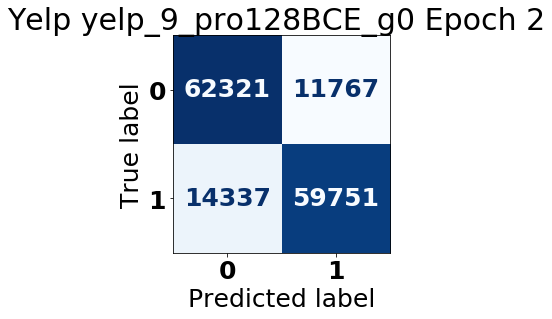

2020-07-01 21:50:55,828 : INFO : wrote 9261 events to disk


Time for [evaluate model - 3]: 0:07:56.220739
Train model on group fold (('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services', 'professional'), ('Hotels & Travel', 'hotelstravel'), ('Local Services', 'localservices')) #22176...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:33.420457


  1%|          | 157/22176 [00:00<00:14, 1563.26it/s]

Start on [train model - 3] ...
Start on [setup training] ...


  0%|          | 0/697 [00:00<?, ?it/s]

Time for [setup training]: 0:00:14.151195
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/697 [00:00<06:41,  1.73it/s]2020-07-01 21:51:45,767 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593633105.cuda2
2020-07-01 21:51:45,777 : INFO : wrote 1 event to disk
2020-07-01 21:51:45,777 : INFO : wrote 1 event to disk
 72%|███████▏  | 500/697 [02:11<00:51,  3.80it/s]

[Epoch 0 Batch 500/697] loss=0.4236, lr=0.0000050, acc=0.790 - time 0:02:11.503771


100%|██████████| 697/697 [03:03<00:00,  3.80it/s]


Time for [epoch 0]: 0:03:03.450408


  0%|          | 0/697 [00:00<?, ?it/s]

Start on [epoch 1] ...


 72%|███████▏  | 500/697 [02:11<00:51,  3.84it/s]

[Epoch 1 Batch 500/697] loss=0.3626, lr=0.0000050, acc=0.830 - time 0:02:11.011953


100%|██████████| 697/697 [03:02<00:00,  3.82it/s]


Time for [epoch 1]: 0:03:02.615958


  0%|          | 0/697 [00:00<?, ?it/s]

Start on [epoch 2] ...


 72%|███████▏  | 500/697 [02:16<00:53,  3.68it/s]

[Epoch 2 Batch 500/697] loss=0.3177, lr=0.0000050, acc=0.856 - time 0:02:16.943337


100%|██████████| 697/697 [03:10<00:00,  3.65it/s]


Time for [epoch 2]: 0:03:10.877762
Time for [training]: 0:09:18.177831


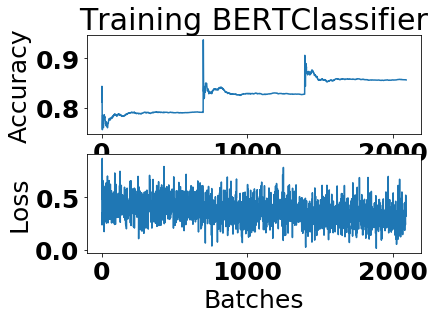

2020-07-01 22:01:03,500 : INFO : wrote 4181 events to disk
  0%|          | 0/12669 [00:00<?, ?it/s]

Time for [train model - 3]: 0:09:32.472788
Start on [evaluate model - 3] ...
Start on [prediction] ...


  0%|          | 1/12669 [00:00<22:50,  9.24it/s]2020-07-01 22:01:03,632 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593633663.cuda2
2020-07-01 22:01:03,644 : INFO : wrote 1 event to disk
2020-07-01 22:01:03,653 : INFO : wrote 1 event to disk
100%|██████████| 12669/12669 [21:31<00:00,  9.81it/s]


Time for [prediction]: 0:21:31.902891
Accuracy in epoch 2: 0.8449142592154076
Confusion Matrix:
[[168356  34348]
 [ 28525 174179]]

CM: [168356  34348  28525 174179] 
[tn, fp, fn, tp]
  accuracy: 0.845
 precision: 0.845
    recall: 0.845
  f1-score: 0.845

Accuracy:  0.845 

Report for [BERTClassifier - yelp_9_pro128BCE_g1]:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84    202704
           1       0.84      0.86      0.85    202704

    accuracy                           0.84    405408
   macro avg       0.85      0.84      0.84    405408
weighted avg       0.85      0.84      0.84    405408



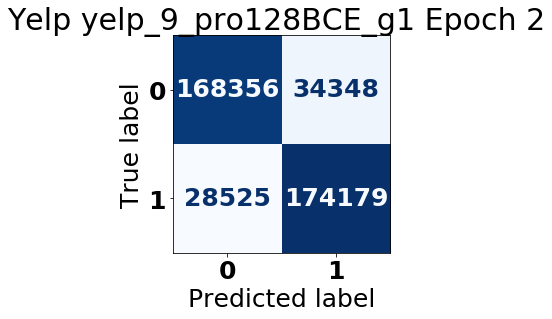

2020-07-01 22:22:38,844 : INFO : wrote 1803 events to disk


Time for [evaluate model - 3]: 0:21:35.341285
Train model on group fold (('Education', 'education'), ('Automotive', 'auto'), ('Bicycles', 'bicycles'), ('Mass Media', 'massmedia'), ('Home Services', 'homeservices')) #36624...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:32.177597


  0%|          | 146/36624 [00:00<00:25, 1450.38it/s]

Start on [train model - 3] ...
Start on [setup training] ...


  0%|          | 0/1150 [00:00<?, ?it/s]

Time for [setup training]: 0:00:24.839043
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/1150 [00:00<06:10,  3.10it/s]2020-07-01 22:23:37,966 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593635017.cuda2
2020-07-01 22:23:37,966 : INFO : wrote 1 event to disk
2020-07-01 22:23:37,967 : INFO : wrote 1 event to disk
 43%|████▎     | 500/1150 [02:11<02:49,  3.83it/s]

[Epoch 0 Batch 500/1150] loss=0.3203, lr=0.0000050, acc=0.860 - time 0:02:11.509010


 87%|████████▋ | 1000/1150 [04:23<00:39,  3.76it/s]

[Epoch 0 Batch 1000/1150] loss=0.3128, lr=0.0000050, acc=0.863 - time 0:02:12.108223


100%|██████████| 1150/1150 [05:04<00:00,  3.78it/s]


Time for [epoch 0]: 0:05:04.127153


  0%|          | 0/1150 [00:00<?, ?it/s]

Start on [epoch 1] ...


 43%|████▎     | 500/1150 [02:17<03:01,  3.59it/s]

[Epoch 1 Batch 500/1150] loss=0.2583, lr=0.0000050, acc=0.895 - time 0:02:17.436335


 87%|████████▋ | 1000/1150 [04:36<00:41,  3.62it/s]

[Epoch 1 Batch 1000/1150] loss=0.2524, lr=0.0000050, acc=0.896 - time 0:02:18.601614


100%|██████████| 1150/1150 [05:17<00:00,  3.62it/s]


Time for [epoch 1]: 0:05:17.643624


  0%|          | 0/1150 [00:00<?, ?it/s]

Start on [epoch 2] ...


 43%|████▎     | 500/1150 [02:18<03:01,  3.57it/s]

[Epoch 2 Batch 500/1150] loss=0.2099, lr=0.0000050, acc=0.919 - time 0:02:18.988193


 87%|████████▋ | 1000/1150 [04:37<00:42,  3.56it/s]

[Epoch 2 Batch 1000/1150] loss=0.2049, lr=0.0000050, acc=0.920 - time 0:02:18.040545


100%|██████████| 1150/1150 [05:18<00:00,  3.61it/s]


Time for [epoch 2]: 0:05:18.534193
Time for [training]: 0:15:41.612475


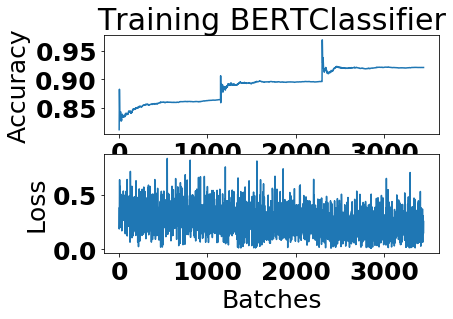

2020-07-01 22:39:19,373 : INFO : wrote 2459 events to disk
  0%|          | 0/12218 [00:00<?, ?it/s]

Time for [train model - 3]: 0:16:06.595644
Start on [evaluate model - 3] ...
Start on [prediction] ...


  0%|          | 1/12218 [00:00<21:08,  9.63it/s]2020-07-01 22:39:19,485 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593635959.cuda2
2020-07-01 22:39:19,487 : INFO : wrote 1 event to disk
2020-07-01 22:39:19,488 : INFO : wrote 1 event to disk
100%|██████████| 12218/12218 [20:27<00:00,  9.96it/s]


Time for [prediction]: 0:20:27.106407
Accuracy in epoch 2: 0.8302767546552077
Confusion Matrix:
[[164160  31320]
 [ 35035 160445]]

CM: [164160  31320  35035 160445] 
[tn, fp, fn, tp]
  accuracy: 0.830
 precision: 0.830
    recall: 0.830
  f1-score: 0.830

Accuracy:  0.83 

Report for [BERTClassifier - yelp_9_pro128BCE_g2]:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    195480
           1       0.84      0.82      0.83    195480

    accuracy                           0.83    390960
   macro avg       0.83      0.83      0.83    390960
weighted avg       0.83      0.83      0.83    390960



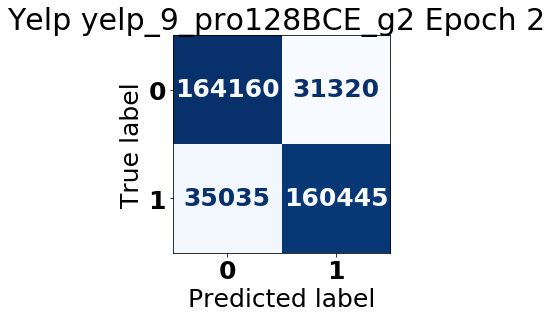

2020-07-01 22:59:49,773 : INFO : wrote 537 events to disk


Time for [evaluate model - 3]: 0:20:30.400671
Train model on group fold (('Pets', 'pets'), ('Nightlife', 'nightlife'), ('Financial Services', 'financialservices'), ('Beauty & Spas', 'beautysvc'), ('Food', 'food')) #89376...
Start on [prepare training / validation data] ...
Time for [prepare training / validation data]: 0:00:33.865702


  0%|          | 160/89376 [00:00<00:56, 1582.44it/s]

Start on [train model - 3] ...
Start on [setup training] ...


  0%|          | 0/2798 [00:00<?, ?it/s]

Time for [setup training]: 0:00:51.477432
Start on [training] ...
Start on [epoch 0] ...


  0%|          | 1/2798 [00:00<15:59,  2.92it/s]2020-07-01 23:01:17,132 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593637277.cuda2
2020-07-01 23:01:17,137 : INFO : wrote 1 event to disk
2020-07-01 23:01:17,138 : INFO : wrote 1 event to disk
 18%|█▊        | 500/2798 [02:15<10:27,  3.66it/s]

[Epoch 0 Batch 500/2798] loss=0.3894, lr=0.0000050, acc=0.817 - time 0:02:15.449650


 36%|███▌      | 1000/2798 [04:32<08:10,  3.66it/s]

[Epoch 0 Batch 1000/2798] loss=0.3848, lr=0.0000050, acc=0.817 - time 0:02:16.661297


 54%|█████▎    | 1500/2798 [06:48<05:54,  3.67it/s]

[Epoch 0 Batch 1500/2798] loss=0.3815, lr=0.0000050, acc=0.818 - time 0:02:16.723524


 71%|███████▏  | 2000/2798 [09:05<03:33,  3.74it/s]

[Epoch 0 Batch 2000/2798] loss=0.3681, lr=0.0000050, acc=0.820 - time 0:02:16.697321


 89%|████████▉ | 2500/2798 [11:22<01:21,  3.64it/s]

[Epoch 0 Batch 2500/2798] loss=0.3761, lr=0.0000050, acc=0.819 - time 0:02:16.912135


100%|██████████| 2798/2798 [12:44<00:00,  3.66it/s]


Time for [epoch 0]: 0:12:44.354169


  0%|          | 0/2798 [00:00<?, ?it/s]

Start on [epoch 1] ...


 18%|█▊        | 500/2798 [02:17<10:32,  3.63it/s]

[Epoch 1 Batch 500/2798] loss=0.3374, lr=0.0000050, acc=0.846 - time 0:02:17.155379


 36%|███▌      | 1000/2798 [04:33<08:19,  3.60it/s]

[Epoch 1 Batch 1000/2798] loss=0.3306, lr=0.0000050, acc=0.846 - time 0:02:16.721595


 54%|█████▎    | 1500/2798 [06:50<06:04,  3.57it/s]

[Epoch 1 Batch 1500/2798] loss=0.3354, lr=0.0000050, acc=0.846 - time 0:02:17.012790


 71%|███████▏  | 2000/2798 [09:07<03:40,  3.61it/s]

[Epoch 1 Batch 2000/2798] loss=0.3329, lr=0.0000050, acc=0.846 - time 0:02:16.964262


 89%|████████▉ | 2500/2798 [11:21<01:18,  3.80it/s]

[Epoch 1 Batch 2500/2798] loss=0.3386, lr=0.0000050, acc=0.845 - time 0:02:13.800793


100%|██████████| 2798/2798 [12:39<00:00,  3.68it/s]


Time for [epoch 1]: 0:12:39.673399


  0%|          | 0/2798 [00:00<?, ?it/s]

Start on [epoch 2] ...


 18%|█▊        | 500/2798 [02:10<10:07,  3.78it/s]

[Epoch 2 Batch 500/2798] loss=0.2933, lr=0.0000050, acc=0.871 - time 0:02:10.379048


 36%|███▌      | 1000/2798 [04:23<07:54,  3.79it/s]

[Epoch 2 Batch 1000/2798] loss=0.3001, lr=0.0000050, acc=0.867 - time 0:02:12.692726


 54%|█████▎    | 1500/2798 [06:39<06:00,  3.60it/s]

[Epoch 2 Batch 1500/2798] loss=0.2914, lr=0.0000050, acc=0.868 - time 0:02:15.996449


 71%|███████▏  | 2000/2798 [08:56<03:41,  3.61it/s]

[Epoch 2 Batch 2000/2798] loss=0.3010, lr=0.0000050, acc=0.867 - time 0:02:16.993380


 89%|████████▉ | 2500/2798 [11:13<01:22,  3.61it/s]

[Epoch 2 Batch 2500/2798] loss=0.2951, lr=0.0000050, acc=0.867 - time 0:02:17.112825


100%|██████████| 2798/2798 [12:34<00:00,  3.71it/s]


Time for [epoch 2]: 0:12:34.584727
Time for [training]: 0:37:59.892164


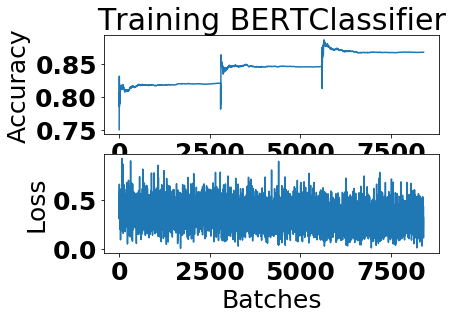

2020-07-01 23:39:16,836 : INFO : wrote 3501 events to disk
  0%|          | 0/10569 [00:00<?, ?it/s]

Time for [train model - 3]: 0:38:51.536824
Start on [evaluate model - 3] ...
Start on [prediction] ...


  0%|          | 1/10569 [00:00<22:37,  7.79it/s]2020-07-01 23:39:16,987 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593639556.cuda2
2020-07-01 23:39:16,997 : INFO : wrote 1 event to disk
2020-07-01 23:39:16,997 : INFO : wrote 1 event to disk
100%|██████████| 10569/10569 [17:58<00:00,  9.80it/s]


Time for [prediction]: 0:17:58.368556
Accuracy in epoch 2: 0.8520466695051566
Confusion Matrix:
[[144319  24785]
 [ 25254 143850]]

CM: [144319  24785  25254 143850] 
[tn, fp, fn, tp]
  accuracy: 0.852
 precision: 0.852
    recall: 0.852
  f1-score: 0.852

Accuracy:  0.852 

Report for [BERTClassifier - yelp_9_pro128BCE_g3]:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85    169104
           1       0.85      0.85      0.85    169104

    accuracy                           0.85    338208
   macro avg       0.85      0.85      0.85    338208
weighted avg       0.85      0.85      0.85    338208



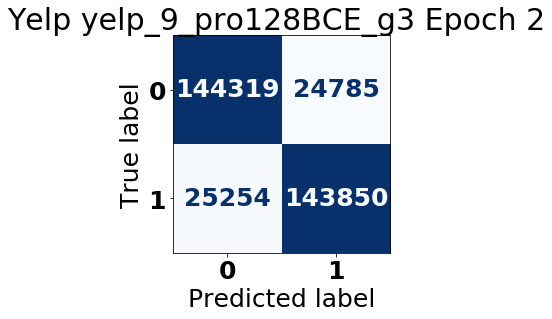

2020-07-01 23:57:18,156 : INFO : wrote 9329 events to disk


Time for [evaluate model - 3]: 0:18:01.319699


In [51]:
for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Train model on group fold {cg_ids} #{len(train_df)}...")
    
    with Timer("prepare training / validation data"):
        X_train, y_train = train_df[names_columns_X], train_df[names_columns_y]
        X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]

        _, data_train = transform_dataset(X_train, y_train, transform)
        _, data_dev = transform_dataset(X_dev, y_dev, transform)

    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    if not fn_run_path.exists():
        fn_run_path.mkdir()

    fn_group = fn_run_path / "group_data.p"
    with open(fn_group, "wb") as fp:
        pickle.dump(cg_ids, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(train_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dev_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(dev_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)
        pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
        
    with Timer(f"train model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=batch_size, lr=5e-6, num_epochs=num_epochs, sw=sw, checkpoint_dir=str(fn_run_path))
        plot_train_stats(stats)
        
    with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        with open(fn_run_path / f"{run_name}_g{i}_preds.p", "wb") as fp:
            pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
        plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
        plt.show()

### Evaluate again

Eval model on group fold (('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt')) #279408...
Start on [prepare validation data] ...


  0%|          | 0/4631 [00:00<?, ?it/s]

Time for [prepare validation data]: 0:00:11.839036
Load data/yelp_9_pro128BCE_g0/bert.model.checkpoint2.params ...
Start on [evaluate model - 3] ...
Start on [prediction] ...


  0%|          | 1/4631 [00:00<14:55,  5.17it/s]2020-07-01 23:57:30,351 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593640650.cuda2
2020-07-01 23:57:30,352 : INFO : wrote 1 event to disk
2020-07-01 23:57:30,352 : INFO : wrote 1 event to disk
100%|██████████| 4631/4631 [07:47<00:00,  9.91it/s]


Time for [prediction]: 0:07:47.492044
Accuracy in epoch 2: 0.8238311197494871
Confusion Matrix:
[[62321 11767]
 [14337 59751]]

CM: [62321 11767 14337 59751] 
[tn, fp, fn, tp]
  accuracy: 0.824
 precision: 0.824
    recall: 0.824
  f1-score: 0.824

Accuracy:  0.824 

Report for [BERTClassifier - yelp_9_pro128BCE_g0]:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83     74088
           1       0.84      0.81      0.82     74088

    accuracy                           0.82    148176
   macro avg       0.82      0.82      0.82    148176
weighted avg       0.82      0.82      0.82    148176



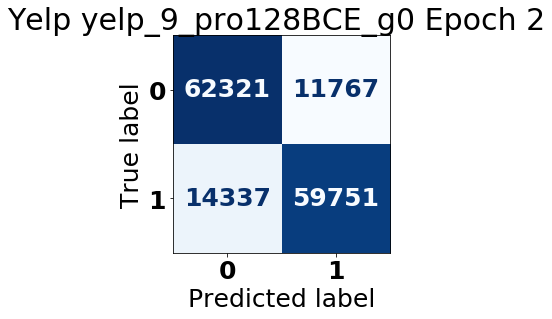

2020-07-02 00:05:19,138 : INFO : wrote 9261 events to disk


Time for [evaluate model - 3]: 0:07:49.008789
Eval model on group fold (('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services', 'professional'), ('Hotels & Travel', 'hotelstravel'), ('Local Services', 'localservices')) #22176...
Start on [prepare validation data] ...


  0%|          | 0/12669 [00:00<?, ?it/s]

Time for [prepare validation data]: 0:00:31.125030
Load data/yelp_9_pro128BCE_g1/bert.model.checkpoint2.params ...
Start on [evaluate model - 3] ...
Start on [prediction] ...


  0%|          | 1/12669 [00:00<45:30,  4.64it/s]2020-07-02 00:05:50,648 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593641150.cuda2
2020-07-02 00:05:50,649 : INFO : wrote 1 event to disk
2020-07-02 00:05:50,649 : INFO : wrote 1 event to disk
100%|██████████| 12669/12669 [21:39<00:00,  9.75it/s]


Time for [prediction]: 0:21:39.143613
Accuracy in epoch 2: 0.8449142592154076
Confusion Matrix:
[[168356  34348]
 [ 28525 174179]]

CM: [168356  34348  28525 174179] 
[tn, fp, fn, tp]
  accuracy: 0.845
 precision: 0.845
    recall: 0.845
  f1-score: 0.845

Accuracy:  0.845 

Report for [BERTClassifier - yelp_9_pro128BCE_g1]:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84    202704
           1       0.84      0.86      0.85    202704

    accuracy                           0.84    405408
   macro avg       0.85      0.84      0.84    405408
weighted avg       0.85      0.84      0.84    405408



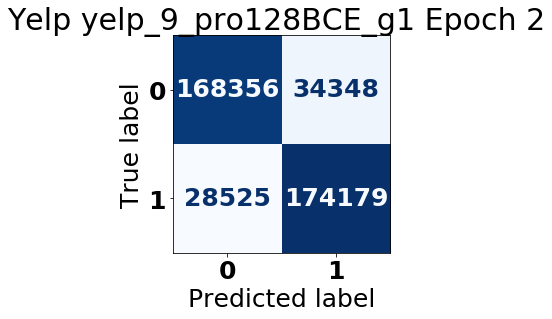

2020-07-02 00:27:33,665 : INFO : wrote 2055 events to disk


Time for [evaluate model - 3]: 0:21:43.246037
Eval model on group fold (('Education', 'education'), ('Automotive', 'auto'), ('Bicycles', 'bicycles'), ('Mass Media', 'massmedia'), ('Home Services', 'homeservices')) #36624...
Start on [prepare validation data] ...


In [ ]:
cg_results = dict()

for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Eval model on group fold {cg_ids} #{len(train_df)}...")
    
    with Timer("prepare validation data"):
        X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]
        _, data_dev = transform_dataset(X_dev, y_dev, transform)

    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")

    fn_group = fn_run_path / "group_data.p"
    #with open(fn_group, "rb") as fp:
    #    pickle.dump(cg_ids, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(train_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(dev_df, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(dev_dfs, fp, protocol=pickle.HIGHEST_PROTOCOL)
    #    pickle.dump(groups, fp, protocol=pickle.HIGHEST_PROTOCOL)
    
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)

    with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
        print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        with open(fn_run_path / f"{run_name}_g{i}_preds.p", "wb") as fp:
            pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
            pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
        report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name}", heatmap=False)
        plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id}", values_format="d", cmap="Blues", include_colorbar=False)
        plt.show()
        
        cg_results[cg_ids] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results = fn_run_path / "cg_results.p"
with open(fn_cg_results, "wb") as fp:
    pickle.dump(cg_results, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [57]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results = fn_run_path / "cg_results.p"
with open(fn_cg_results, "rb") as fp:
    cg_results = pickle.load(fp)

In [67]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results = fn_run_path / "cg_results.txt"
with open(fn_cg_results, "w") as fp:
    for cg_ids, (prec, rec, f1, acc, cm) in cg_results.items():
        fp.write(f"{str(cg_ids):<30}: P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%  -- CM:{cm.flatten().tolist()}\n\n")

In [98]:
cur_cat = None
for cg_ids, (prec, rec, f1, acc, cm) in cg_results.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        print(f"\n\n{cg_ids}\n")
    print(f"P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%")



(('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt'))

P:82.42%  R:82.38%  F:82.38%  A:82.38%


(('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services', 'professional'), ('Hotels & Travel', 'hotelstravel'), ('Local Services', 'localservices'))

P:84.52%  R:84.49%  F:84.49%  A:84.49%


(('Education', 'education'), ('Automotive', 'auto'), ('Bicycles', 'bicycles'), ('Mass Media', 'massmedia'), ('Home Services', 'homeservices'))

P:83.04%  R:83.03%  F:83.03%  A:83.03%


(('Pets', 'pets'), ('Nightlife', 'nightlife'), ('Financial Services', 'financialservices'), ('Beauty & Spas', 'beautysvc'), ('Food', 'food'))

P:85.20%  R:85.20%  F:85.20%  A:85.20%


In [ ]:
cg_results_single_group = dict()

for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Eval model {cg_ids} #{len(train_df)}...")
    
    cg_groups = [cg_ids_o for cg_ids_o in groups if cg_ids_o != cg_ids]
    
    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    
    fn_model_state = fn_run_path / f"bert.model.checkpoint{epoch_id}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)

    for cgi, (cg_ids_o, dev_df) in enumerate(zip(cg_groups, dev_dfs)):
        with Timer("prepare validation data"):
            X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]
            _, data_dev = transform_dataset(X_dev, y_dev, transform)

        with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
            all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
            print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

            y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
            with open(fn_run_path / f"{run_name}_g{i}sg{cgi}_preds.p", "wb") as fp:
                pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
                pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
            report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {cg_ids_o}", heatmap=False)
            plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id} on group {cg_ids_o}", values_format="d", cmap="Blues", include_colorbar=False)
            plt.show()
            
            # do we have the 
            cg_results_single_group[(cg_ids, cg_ids_o, i, cgi)] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [ ]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_group = fn_run_path / "cg_results_single_group.p"
with open(fn_cg_results_single_group, "wb") as fp:
    pickle.dump(cg_results_single_group, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_group = fn_run_path / "cg_results_single_group.p"
with open(fn_cg_results_single_group, "rb") as fp:
    cg_results_single_group = pickle.load(fp)

In [68]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_group = fn_run_path / "cg_results_single_group.txt"
with open(fn_cg_results_single_group, "w") as fp:
    for (cg_ids, cg_ids_o, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_group.items():
        fp.write(f"{cg_ids}-{cg_ids_o}-{i}-{cgi}: P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%  -- CM:{cm.flatten().tolist()}\n\n")

In [95]:
cur_cat = None
for (cg_ids, cg_ids_o, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_group.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        print(f"\n\n{cg_ids}\n")
    print(f"P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}% -- {cg_ids_o}")



(('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt'))

P:79.43%  R:79.40%  F:79.39%  A:79.40% -- (('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services', 'professional'), ('Hotels & Travel', 'hotelstravel'), ('Local Services', 'localservices'))
P:85.83%  R:85.82%  F:85.82%  A:85.82% -- (('Education', 'education'), ('Automotive', 'auto'), ('Bicycles', 'bicycles'), ('Mass Media', 'massmedia'), ('Home Services', 'homeservices'))
P:81.77%  R:81.72%  F:81.71%  A:81.72% -- (('Pets', 'pets'), ('Nightlife', 'nightlife'), ('Financial Services', 'financialservices'), ('Beauty & Spas', 'beautysvc'), ('Food', 'food'))


(('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services

Eval model (('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt')) #279408...
Load data/yelp_9_pro128BCE_g0/bert.model.checkpoint2.params ...
Start on [prepare validation data] ...


  0%|          | 1/239 [00:00<00:26,  8.99it/s]2020-07-02 08:54:56,723 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593672896.cuda2
2020-07-02 08:54:56,731 : INFO : wrote 1 event to disk
2020-07-02 08:54:56,732 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.560044
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 239/239 [00:22<00:00, 10.45it/s]

Time for [prediction]: 0:00:22.865921
Accuracy in epoch 2: 0.7845911949685535
Confusion Matrix:
[[3075  741]
 [ 903 2913]]

CM: [3075  741  903 2913] 
[tn, fp, fn, tp]
  accuracy: 0.785
 precision: 0.785
    recall: 0.785
  f1-score: 0.784

Accuracy:  0.785 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Active Life', 'active')]:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3816
           1       0.80      0.76      0.78      3816

    accuracy                           0.78      7632
   macro avg       0.79      0.78      0.78      7632
weighted avg       0.79      0.78      0.78      7632



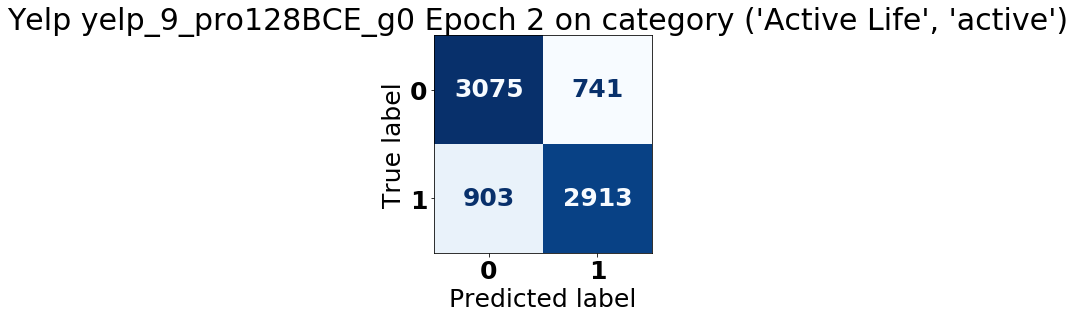

2020-07-02 08:55:19,605 : INFO : wrote 477 events to disk


Time for [evaluate model - 3]: 0:00:23.005692
Start on [prepare validation data] ...


  0%|          | 0/158 [00:00<?, ?it/s]2020-07-02 08:55:20,149 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593672920.cuda2
2020-07-02 08:55:20,156 : INFO : wrote 1 event to disk
2020-07-02 08:55:20,156 : INFO : wrote 1 event to disk
  1%|▏         | 2/158 [00:00<00:15, 10.24it/s]

Time for [prepare validation data]: 0:00:00.377339
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 158/158 [00:15<00:00, 10.43it/s]


Time for [prediction]: 0:00:15.153142
Accuracy in epoch 2: 0.7145965189873418
Confusion Matrix:
[[1887  641]
 [ 802 1726]]

CM: [1887  641  802 1726] 
[tn, fp, fn, tp]
  accuracy: 0.715
 precision: 0.715
    recall: 0.715
  f1-score: 0.714

Accuracy:  0.715 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Arts & Entertainment', 'arts')]:
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      2528
           1       0.73      0.68      0.71      2528

    accuracy                           0.71      5056
   macro avg       0.72      0.71      0.71      5056
weighted avg       0.72      0.71      0.71      5056



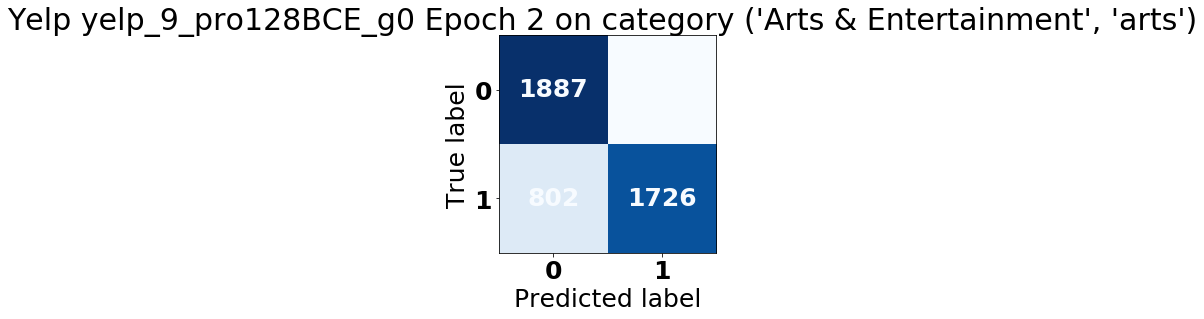

2020-07-02 08:55:35,298 : INFO : wrote 315 events to disk


Time for [evaluate model - 3]: 0:00:15.262442
Start on [prepare validation data] ...


  0%|          | 1/699 [00:00<01:14,  9.42it/s]2020-07-02 08:55:37,157 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593672937.cuda2
2020-07-02 08:55:37,160 : INFO : wrote 1 event to disk
2020-07-02 08:55:37,161 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.661472
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 699/699 [01:07<00:00, 10.29it/s]


Time for [prediction]: 0:01:07.936176
Accuracy in epoch 2: 0.8533172389127325
Confusion Matrix:
[[9642 1542]
 [1739 9445]]

CM: [9642 1542 1739 9445] 
[tn, fp, fn, tp]
  accuracy: 0.853
 precision: 0.853
    recall: 0.853
  f1-score: 0.853

Accuracy:  0.853 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Automotive', 'auto')]:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85     11184
           1       0.86      0.84      0.85     11184

    accuracy                           0.85     22368
   macro avg       0.85      0.85      0.85     22368
weighted avg       0.85      0.85      0.85     22368



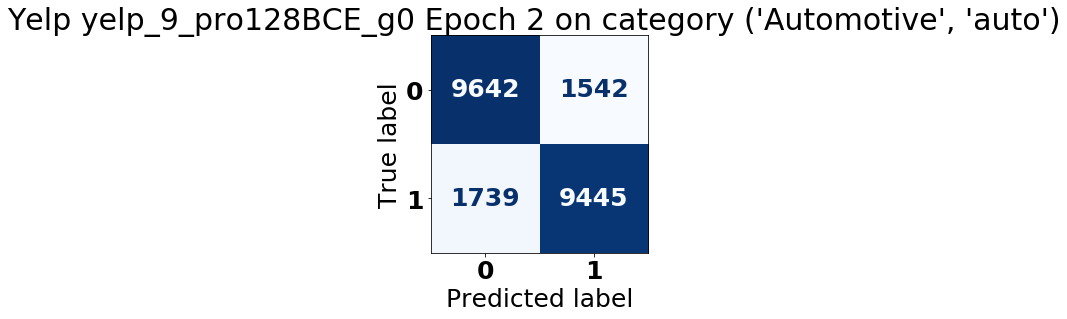

2020-07-02 08:56:45,243 : INFO : wrote 1397 events to disk


Time for [evaluate model - 3]: 0:01:08.215431
Start on [prepare validation data] ...


  0%|          | 1/1099 [00:00<01:58,  9.24it/s]2020-07-02 08:56:47,999 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673007.cuda2
2020-07-02 08:56:48,002 : INFO : wrote 1 event to disk
2020-07-02 08:56:48,002 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:02.579105
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 1099/1099 [01:45<00:00, 10.41it/s]


Time for [prediction]: 0:01:45.586468
Accuracy in epoch 2: 0.8745448338643604
Confusion Matrix:
[[15600  1976]
 [ 2434 15142]]

CM: [15600  1976  2434 15142] 
[tn, fp, fn, tp]
  accuracy: 0.875
 precision: 0.875
    recall: 0.875
  f1-score: 0.875

Accuracy:  0.875 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Beauty & Spas', 'beautysvc')]:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88     17576
           1       0.88      0.86      0.87     17576

    accuracy                           0.87     35152
   macro avg       0.87      0.87      0.87     35152
weighted avg       0.87      0.87      0.87     35152



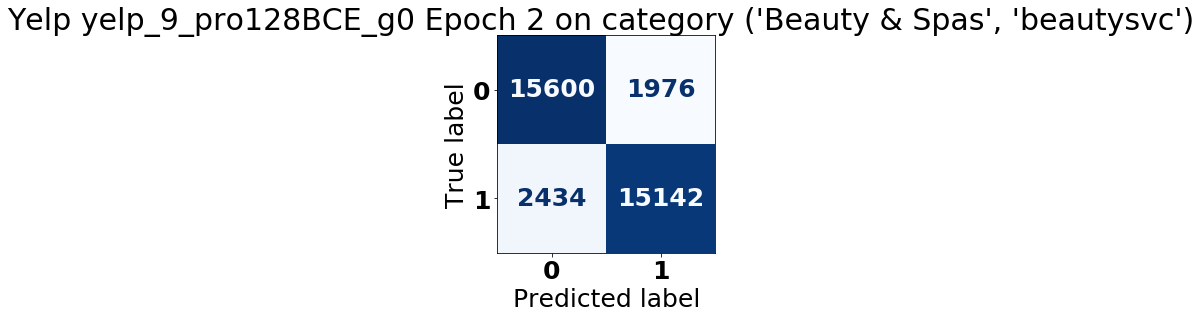

2020-07-02 08:58:33,849 : INFO : wrote 2197 events to disk


Time for [evaluate model - 3]: 0:01:45.975687
Skip empty df: ('Bicycles', 'bicycles')
Start on [prepare validation data] ...


  6%|▋         | 1/16 [00:00<00:01,  9.44it/s]2020-07-02 08:58:34,065 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673114.cuda2
2020-07-02 08:58:34,066 : INFO : wrote 1 event to disk
2020-07-02 08:58:34,067 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.045840
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 16/16 [00:01<00:00,  9.94it/s]


Time for [prediction]: 0:00:01.610942
Accuracy in epoch 2: 0.8245967741935484
Confusion Matrix:
[[207  41]
 [ 46 202]]

CM: [207  41  46 202] 
[tn, fp, fn, tp]
  accuracy: 0.825
 precision: 0.825
    recall: 0.825
  f1-score: 0.825

Accuracy:  0.825 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Education', 'education')]:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83       248
           1       0.83      0.81      0.82       248

    accuracy                           0.82       496
   macro avg       0.82      0.82      0.82       496
weighted avg       0.82      0.82      0.82       496



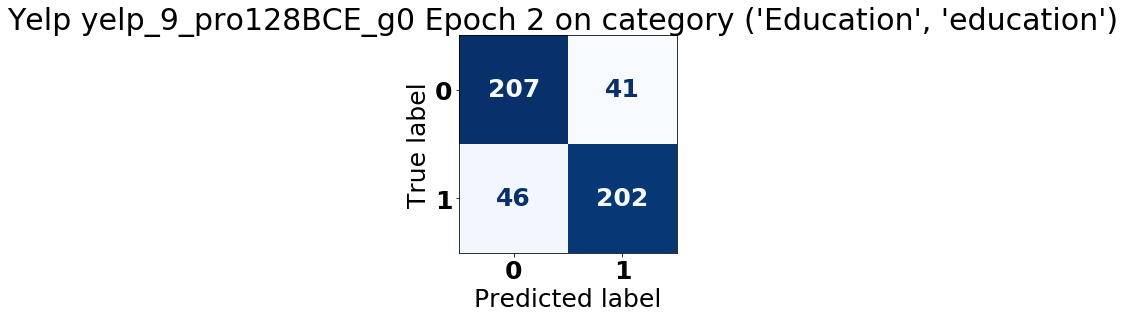

2020-07-02 08:58:35,620 : INFO : wrote 31 events to disk
  0%|          | 0/26 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:01.690812
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.066253
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 08:58:35,835 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673115.cuda2
2020-07-02 08:58:35,836 : INFO : wrote 1 event to disk
2020-07-02 08:58:35,836 : INFO : wrote 1 event to disk
100%|██████████| 26/26 [00:02<00:00, 10.38it/s]

Time for [prediction]: 0:00:02.505277
Accuracy in epoch 2: 0.890625
Confusion Matrix:
[[376  40]
 [ 51 365]]

CM: [376  40  51 365] 
[tn, fp, fn, tp]
  accuracy: 0.891
 precision: 0.891
    recall: 0.891
  f1-score: 0.891

Accuracy:  0.891 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Financial Services', 'financialservices')]:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       416
           1       0.90      0.88      0.89       416

    accuracy                           0.89       832
   macro avg       0.89      0.89      0.89       832
weighted avg       0.89      0.89      0.89       832



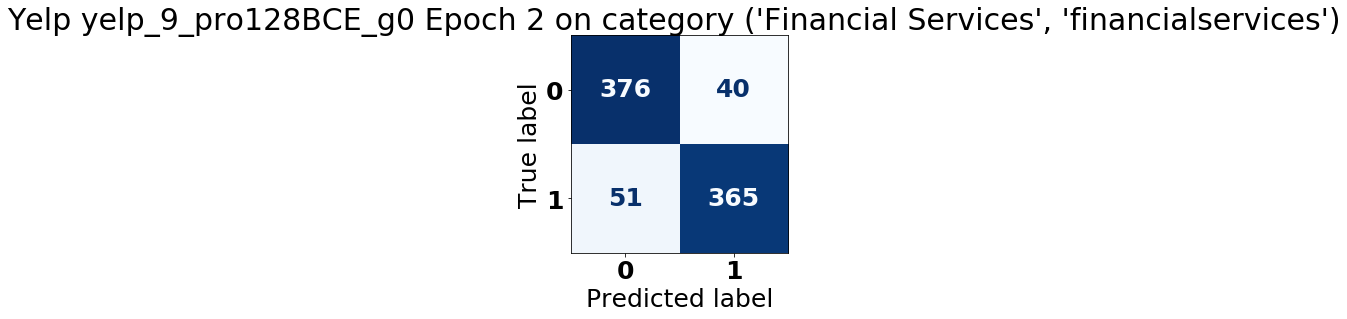

2020-07-02 08:58:38,310 : INFO : wrote 51 events to disk


Time for [evaluate model - 3]: 0:00:02.588077
Start on [prepare validation data] ...


  0%|          | 1/1083 [00:00<02:02,  8.85it/s]2020-07-02 08:58:41,447 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673121.cuda2
2020-07-02 08:58:41,448 : INFO : wrote 1 event to disk
2020-07-02 08:58:41,449 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:02.905427
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 1083/1083 [01:44<00:00, 10.41it/s]


Time for [prediction]: 0:01:44.016210
Accuracy in epoch 2: 0.7738631117266851
Confusion Matrix:
[[13875  3453]
 [ 4384 12944]]

CM: [13875  3453  4384 12944] 
[tn, fp, fn, tp]
  accuracy: 0.774
 precision: 0.775
    recall: 0.774
  f1-score: 0.774

Accuracy:  0.774 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Food', 'food')]:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78     17328
           1       0.79      0.75      0.77     17328

    accuracy                           0.77     34656
   macro avg       0.77      0.77      0.77     34656
weighted avg       0.77      0.77      0.77     34656



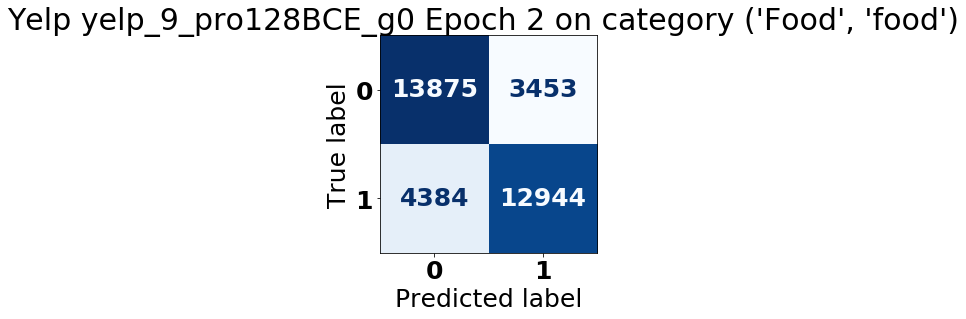

2020-07-02 09:00:25,694 : INFO : wrote 2165 events to disk


Time for [evaluate model - 3]: 0:01:44.382199
Start on [prepare validation data] ...


  0%|          | 0/428 [00:00<?, ?it/s]2020-07-02 09:00:26,964 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673226.cuda2
2020-07-02 09:00:26,966 : INFO : wrote 1 event to disk
2020-07-02 09:00:26,967 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.057081
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 428/428 [00:43<00:00,  9.73it/s]


Time for [prediction]: 0:00:43.967135
Accuracy in epoch 2: 0.8677716121495327
Confusion Matrix:
[[6015  833]
 [ 978 5870]]

CM: [6015  833  978 5870] 
[tn, fp, fn, tp]
  accuracy: 0.868
 precision: 0.868
    recall: 0.868
  f1-score: 0.868

Accuracy:  0.868 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Home Services', 'homeservices')]:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      6848
           1       0.88      0.86      0.87      6848

    accuracy                           0.87     13696
   macro avg       0.87      0.87      0.87     13696
weighted avg       0.87      0.87      0.87     13696



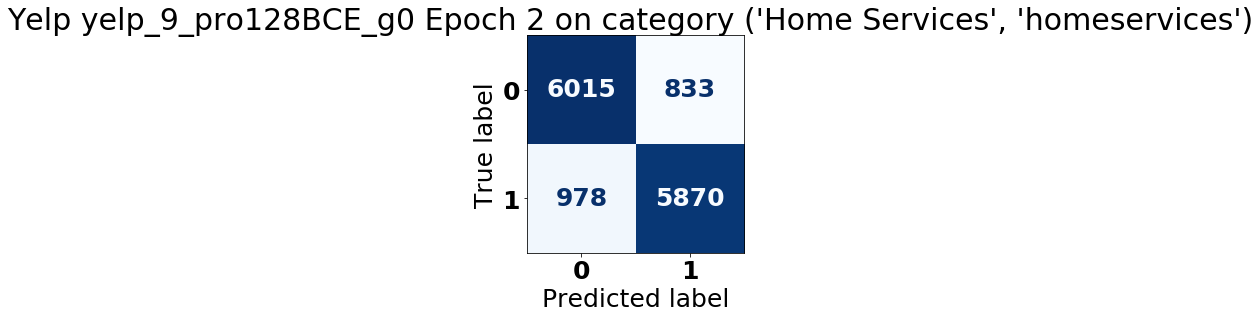

2020-07-02 09:01:11,001 : INFO : wrote 855 events to disk


Time for [evaluate model - 3]: 0:00:44.163351
Start on [prepare validation data] ...


  0%|          | 0/136 [00:00<?, ?it/s]2020-07-02 09:01:11,477 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673271.cuda2
2020-07-02 09:01:11,482 : INFO : wrote 1 event to disk
2020-07-02 09:01:11,483 : INFO : wrote 1 event to disk
  1%|▏         | 2/136 [00:00<00:13, 10.25it/s]

Time for [prepare validation data]: 0:00:00.325482
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 136/136 [00:13<00:00, 10.03it/s]

Time for [prediction]: 0:00:13.565413
Accuracy in epoch 2: 0.8191881918819188
Confusion Matrix:
[[1790  378]
 [ 406 1762]]

CM: [1790  378  406 1762] 
[tn, fp, fn, tp]
  accuracy: 0.819
 precision: 0.819
    recall: 0.819
  f1-score: 0.819

Accuracy:  0.819 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Hotels & Travel', 'hotelstravel')]:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2168
           1       0.82      0.81      0.82      2168

    accuracy                           0.82      4336
   macro avg       0.82      0.82      0.82      4336
weighted avg       0.82      0.82      0.82      4336



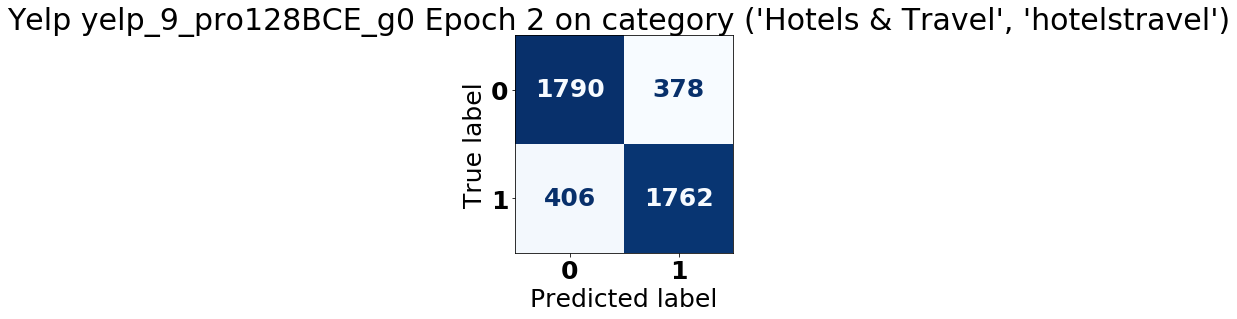

2020-07-02 09:01:25,047 : INFO : wrote 271 events to disk


Time for [evaluate model - 3]: 0:00:13.682417
Start on [prepare validation data] ...


  0%|          | 0/144 [00:00<?, ?it/s]2020-07-02 09:01:25,558 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673285.cuda2
2020-07-02 09:01:25,559 : INFO : wrote 1 event to disk
2020-07-02 09:01:25,560 : INFO : wrote 1 event to disk
  1%|▏         | 2/144 [00:00<00:13, 10.46it/s]

Time for [prepare validation data]: 0:00:00.347970
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 144/144 [00:13<00:00, 10.30it/s]


Time for [prediction]: 0:00:13.977674
Accuracy in epoch 2: 0.8634982638888888
Confusion Matrix:
[[2009  295]
 [ 334 1970]]

CM: [2009  295  334 1970] 
[tn, fp, fn, tp]
  accuracy: 0.863
 precision: 0.864
    recall: 0.863
  f1-score: 0.863

Accuracy:  0.863 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Local Services', 'localservices')]:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      2304
           1       0.87      0.86      0.86      2304

    accuracy                           0.86      4608
   macro avg       0.86      0.86      0.86      4608
weighted avg       0.86      0.86      0.86      4608



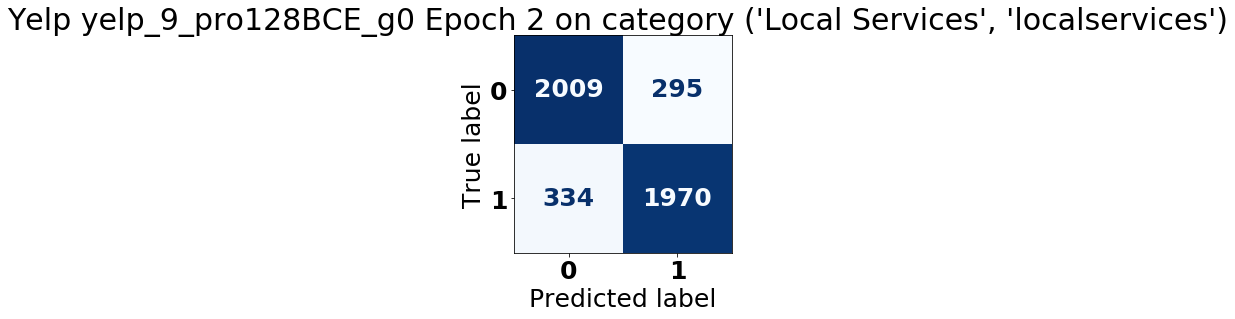

2020-07-02 09:01:39,542 : INFO : wrote 287 events to disk
  0%|          | 0/2 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:14.096294
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.007563
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:01:39,709 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673299.cuda2
2020-07-02 09:01:39,710 : INFO : wrote 1 event to disk
2020-07-02 09:01:39,710 : INFO : wrote 1 event to disk
100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


Time for [prediction]: 0:00:00.196779
Accuracy in epoch 2: 0.765625
Confusion Matrix:
[[25  7]
 [ 8 24]]

CM: [25  7  8 24] 
[tn, fp, fn, tp]
  accuracy: 0.766
 precision: 0.766
    recall: 0.766
  f1-score: 0.766

Accuracy:  0.766 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Mass Media', 'massmedia')]:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.77      0.75      0.76        32

    accuracy                           0.77        64
   macro avg       0.77      0.77      0.77        64
weighted avg       0.77      0.77      0.77        64



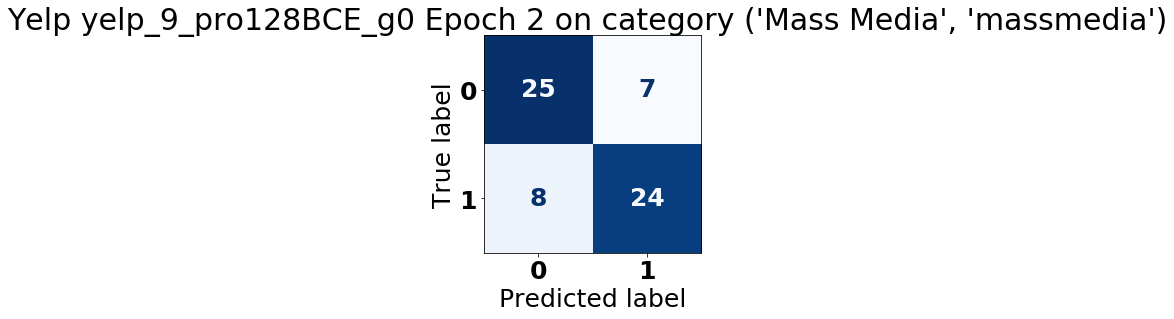

2020-07-02 09:01:39,857 : INFO : wrote 3 events to disk


Time for [evaluate model - 3]: 0:00:00.264447
Start on [prepare validation data] ...


  0%|          | 1/327 [00:00<00:32,  9.97it/s]2020-07-02 09:01:40,820 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673300.cuda2
2020-07-02 09:01:40,822 : INFO : wrote 1 event to disk
2020-07-02 09:01:40,822 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.784626
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 327/327 [00:32<00:00, 10.21it/s]


Time for [prediction]: 0:00:32.036638
Accuracy in epoch 2: 0.7398700305810397
Confusion Matrix:
[[4041 1191]
 [1531 3701]]

CM: [4041 1191 1531 3701] 
[tn, fp, fn, tp]
  accuracy: 0.740
 precision: 0.741
    recall: 0.740
  f1-score: 0.740

Accuracy:  0.74 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Nightlife', 'nightlife')]:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75      5232
           1       0.76      0.71      0.73      5232

    accuracy                           0.74     10464
   macro avg       0.74      0.74      0.74     10464
weighted avg       0.74      0.74      0.74     10464



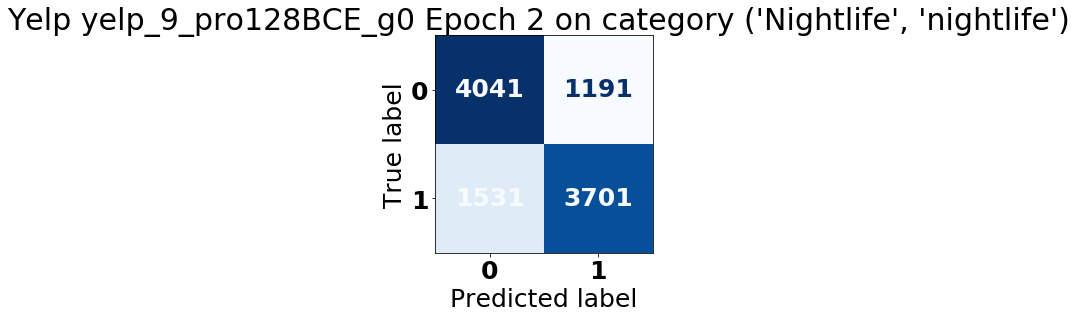

2020-07-02 09:02:12,897 : INFO : wrote 653 events to disk


Time for [evaluate model - 3]: 0:00:32.198566
Start on [prepare validation data] ...


  0%|          | 1/259 [00:00<00:27,  9.22it/s]2020-07-02 09:02:13,693 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673333.cuda2
2020-07-02 09:02:13,694 : INFO : wrote 1 event to disk
2020-07-02 09:02:13,695 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.619025
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 259/259 [00:26<00:00,  9.75it/s]

Time for [prediction]: 0:00:26.564822
Accuracy in epoch 2: 0.8451402321083172
Confusion Matrix:
[[3541  595]
 [ 686 3450]]

CM: [3541  595  686 3450] 
[tn, fp, fn, tp]
  accuracy: 0.845
 precision: 0.845
    recall: 0.845
  f1-score: 0.845

Accuracy:  0.845 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Pets', 'pets')]:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4136
           1       0.85      0.83      0.84      4136

    accuracy                           0.85      8272
   macro avg       0.85      0.85      0.85      8272
weighted avg       0.85      0.85      0.85      8272



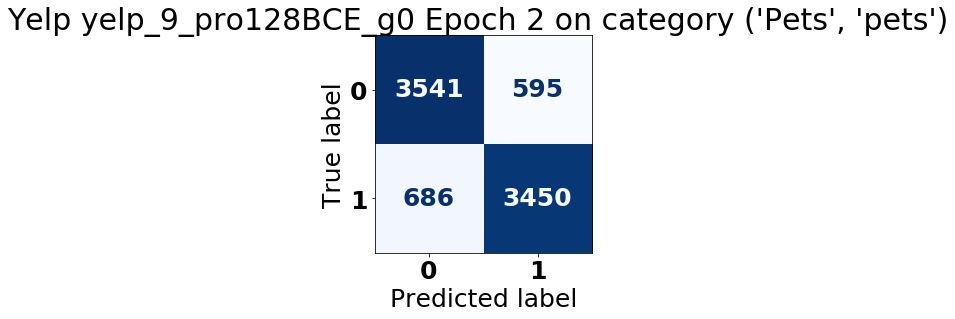

2020-07-02 09:02:40,275 : INFO : wrote 517 events to disk


Time for [evaluate model - 3]: 0:00:26.716268


  0%|          | 0/13 [00:00<?, ?it/s]

Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.034301
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:02:40,493 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673360.cuda2
2020-07-02 09:02:40,503 : INFO : wrote 1 event to disk
2020-07-02 09:02:40,503 : INFO : wrote 1 event to disk
100%|██████████| 13/13 [00:01<00:00, 10.56it/s]

Time for [prediction]: 0:00:01.231745
Accuracy in epoch 2: 0.9025
Confusion Matrix:
[[180  20]
 [ 19 181]]

CM: [180  20  19 181] 
[tn, fp, fn, tp]
  accuracy: 0.902
 precision: 0.903
    recall: 0.903
  f1-score: 0.902

Accuracy:  0.902 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Professional Services', 'professional')]:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       200
           1       0.90      0.91      0.90       200

    accuracy                           0.90       400
   macro avg       0.90      0.90      0.90       400
weighted avg       0.90      0.90      0.90       400



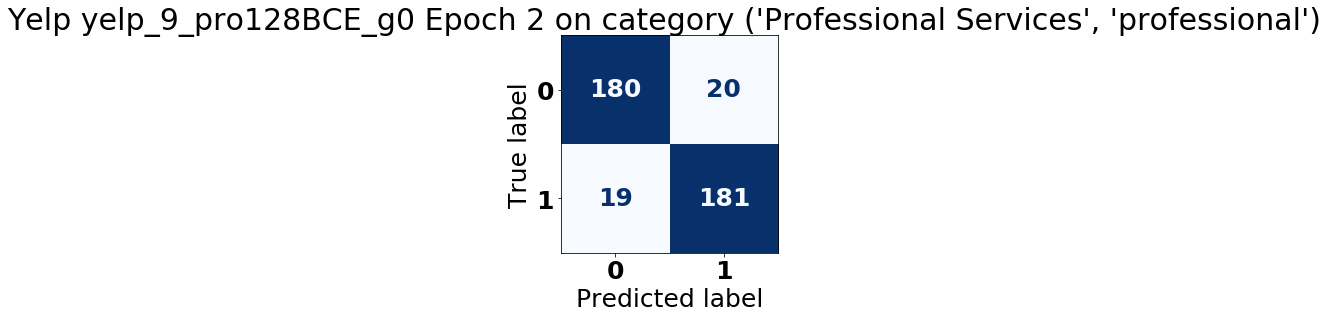

2020-07-02 09:02:41,690 : INFO : wrote 25 events to disk
  0%|          | 0/5 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:01.306911
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.012558
Start on [evaluate model - 3] ...
Start on [prediction] ...


 20%|██        | 1/5 [00:00<00:00,  9.72it/s]2020-07-02 09:02:41,890 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g0/events.out.tfevents.1593673361.cuda2
2020-07-02 09:02:41,890 : INFO : wrote 1 event to disk
2020-07-02 09:02:41,891 : INFO : wrote 1 event to disk
100%|██████████| 5/5 [00:00<00:00, 11.10it/s]


Time for [prediction]: 0:00:00.451269
Accuracy in epoch 2: 0.7916666666666666
Confusion Matrix:
[[58 14]
 [16 56]]

CM: [58 14 16 56] 
[tn, fp, fn, tp]
  accuracy: 0.792
 precision: 0.792
    recall: 0.792
  f1-score: 0.792

Accuracy:  0.792 

Report for [BERTClassifier - yelp_9_pro128BCE_g0 - ('Religious Organizations', 'religiousorgs')]:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        72
           1       0.80      0.78      0.79        72

    accuracy                           0.79       144
   macro avg       0.79      0.79      0.79       144
weighted avg       0.79      0.79      0.79       144



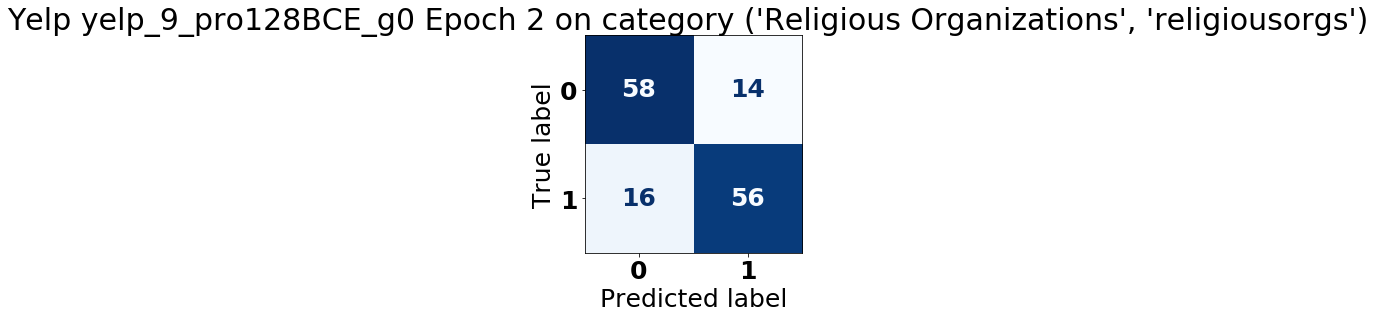

2020-07-02 09:02:42,289 : INFO : wrote 9 events to disk


Time for [evaluate model - 3]: 0:00:00.523438
Eval model (('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services', 'professional'), ('Hotels & Travel', 'hotelstravel'), ('Local Services', 'localservices')) #22176...
Load data/yelp_9_pro128BCE_g1/bert.model.checkpoint2.params ...
Start on [prepare validation data] ...


  0%|          | 0/699 [00:00<?, ?it/s]2020-07-02 09:02:44,289 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673364.cuda2
2020-07-02 09:02:44,297 : INFO : wrote 1 event to disk
2020-07-02 09:02:44,298 : INFO : wrote 1 event to disk
  0%|          | 2/699 [00:00<01:09, 10.07it/s]

Time for [prepare validation data]: 0:00:01.665972
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 699/699 [01:12<00:00,  9.59it/s]


Time for [prediction]: 0:01:12.888320
Accuracy in epoch 2: 0.8572067238912733
Confusion Matrix:
[[9469 1715]
 [1479 9705]]

CM: [9469 1715 1479 9705] 
[tn, fp, fn, tp]
  accuracy: 0.857
 precision: 0.857
    recall: 0.857
  f1-score: 0.857

Accuracy:  0.857 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Automotive', 'auto')]:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86     11184
           1       0.85      0.87      0.86     11184

    accuracy                           0.86     22368
   macro avg       0.86      0.86      0.86     22368
weighted avg       0.86      0.86      0.86     22368



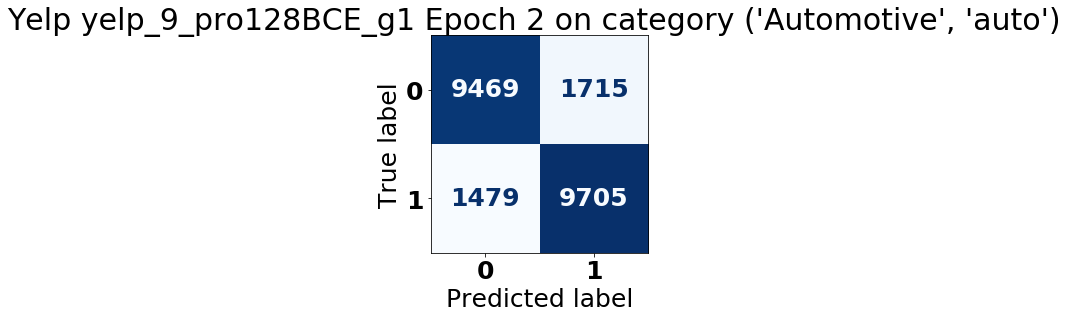

2020-07-02 09:03:58,048 : INFO : wrote 1397 events to disk


Time for [evaluate model - 3]: 0:01:13.871914


  0%|          | 1/1099 [00:00<01:58,  9.29it/s]2020-07-02 09:04:01,835 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673441.cuda2
2020-07-02 09:04:01,847 : INFO : wrote 1 event to disk
2020-07-02 09:04:01,848 : INFO : wrote 1 event to disk


Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:03.468774
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 1099/1099 [01:45<00:00, 10.44it/s]


Time for [prediction]: 0:01:45.311585
Accuracy in epoch 2: 0.8713871187983614
Confusion Matrix:
[[15167  2409]
 [ 2112 15464]]

CM: [15167  2409  2112 15464] 
[tn, fp, fn, tp]
  accuracy: 0.871
 precision: 0.871
    recall: 0.871
  f1-score: 0.871

Accuracy:  0.871 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Beauty & Spas', 'beautysvc')]:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     17576
           1       0.87      0.88      0.87     17576

    accuracy                           0.87     35152
   macro avg       0.87      0.87      0.87     35152
weighted avg       0.87      0.87      0.87     35152



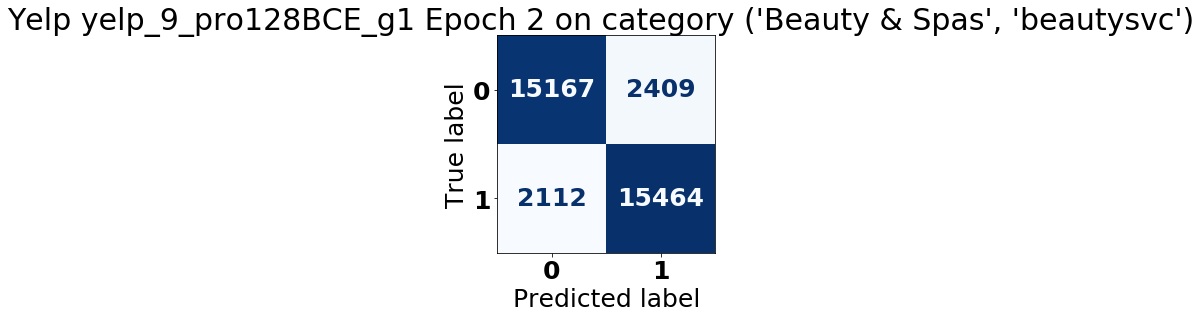

2020-07-02 09:05:47,597 : INFO : wrote 2197 events to disk


Time for [evaluate model - 3]: 0:01:45.877052
Skip empty df: ('Bicycles', 'bicycles')


  6%|▋         | 1/16 [00:00<00:01,  9.46it/s]2020-07-02 09:05:47,788 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673547.cuda2
2020-07-02 09:05:47,810 : INFO : wrote 1 event to disk
2020-07-02 09:05:47,811 : INFO : wrote 1 event to disk


Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.043638
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 16/16 [00:01<00:00, 10.10it/s]


Time for [prediction]: 0:00:01.585884
Accuracy in epoch 2: 0.8346774193548387
Confusion Matrix:
[[198  50]
 [ 32 216]]

CM: [198  50  32 216] 
[tn, fp, fn, tp]
  accuracy: 0.835
 precision: 0.836
    recall: 0.835
  f1-score: 0.834

Accuracy:  0.835 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Education', 'education')]:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       248
           1       0.81      0.87      0.84       248

    accuracy                           0.83       496
   macro avg       0.84      0.83      0.83       496
weighted avg       0.84      0.83      0.83       496



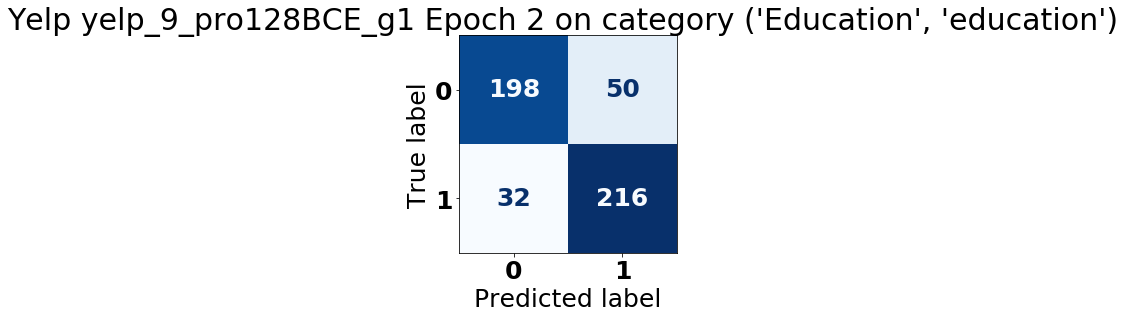

2020-07-02 09:05:49,336 : INFO : wrote 31 events to disk


Time for [evaluate model - 3]: 0:00:01.660086
Start on [prepare validation data] ...


  3%|▎         | 1/30 [00:00<00:02,  9.89it/s]2020-07-02 09:05:49,580 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673549.cuda2
2020-07-02 09:05:49,598 : INFO : wrote 1 event to disk
2020-07-02 09:05:49,599 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.071152
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 30/30 [00:03<00:00,  9.90it/s]


Time for [prediction]: 0:00:03.032645
Accuracy in epoch 2: 0.8866525423728814
Confusion Matrix:
[[415  57]
 [ 50 422]]

CM: [415  57  50 422] 
[tn, fp, fn, tp]
  accuracy: 0.887
 precision: 0.887
    recall: 0.887
  f1-score: 0.887

Accuracy:  0.887 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Event Planning & Services', 'eventservices')]:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       472
           1       0.88      0.89      0.89       472

    accuracy                           0.89       944
   macro avg       0.89      0.89      0.89       944
weighted avg       0.89      0.89      0.89       944



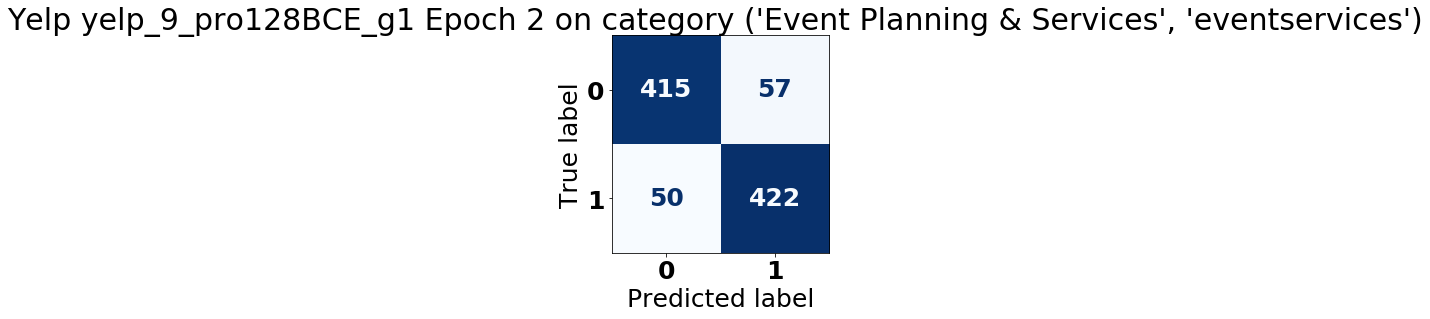

2020-07-02 09:05:52,584 : INFO : wrote 59 events to disk
  0%|          | 0/26 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:03.112140
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.065454
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:05:52,793 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673552.cuda2
2020-07-02 09:05:52,794 : INFO : wrote 1 event to disk
2020-07-02 09:05:52,794 : INFO : wrote 1 event to disk
100%|██████████| 26/26 [00:02<00:00, 10.60it/s]


Time for [prediction]: 0:00:02.453302
Accuracy in epoch 2: 0.8870192307692307
Confusion Matrix:
[[368  48]
 [ 46 370]]

CM: [368  48  46 370] 
[tn, fp, fn, tp]
  accuracy: 0.887
 precision: 0.887
    recall: 0.887
  f1-score: 0.887

Accuracy:  0.887 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Financial Services', 'financialservices')]:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       416
           1       0.89      0.89      0.89       416

    accuracy                           0.89       832
   macro avg       0.89      0.89      0.89       832
weighted avg       0.89      0.89      0.89       832



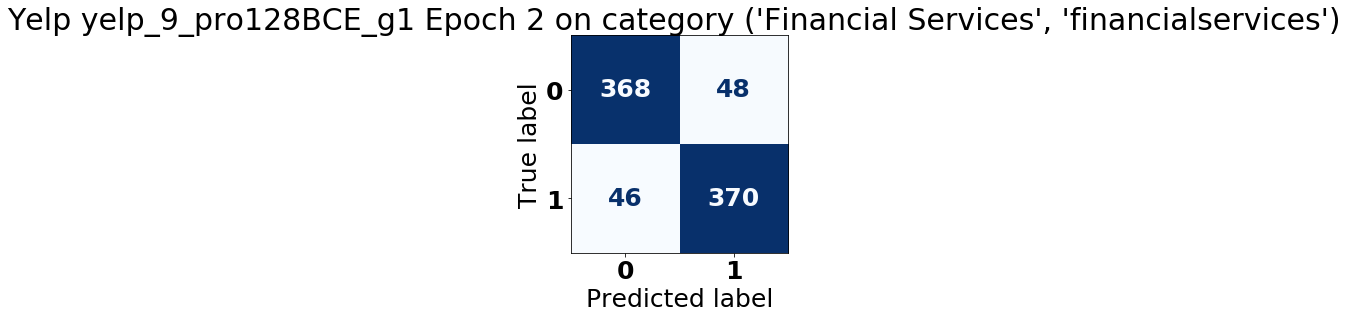

2020-07-02 09:05:55,214 : INFO : wrote 51 events to disk


Time for [evaluate model - 3]: 0:00:02.530357
Start on [prepare validation data] ...


  0%|          | 1/1083 [00:00<01:59,  9.02it/s]2020-07-02 09:05:58,015 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673558.cuda2
2020-07-02 09:05:58,024 : INFO : wrote 1 event to disk
2020-07-02 09:05:58,025 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:02.599967
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 1083/1083 [01:42<00:00, 10.60it/s]


Time for [prediction]: 0:01:42.133460
Accuracy in epoch 2: 0.7719586795937211
Confusion Matrix:
[[13111  4217]
 [ 3686 13642]]

CM: [13111  4217  3686 13642] 
[tn, fp, fn, tp]
  accuracy: 0.772
 precision: 0.772
    recall: 0.772
  f1-score: 0.772

Accuracy:  0.772 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Food', 'food')]:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     17328
           1       0.76      0.79      0.78     17328

    accuracy                           0.77     34656
   macro avg       0.77      0.77      0.77     34656
weighted avg       0.77      0.77      0.77     34656



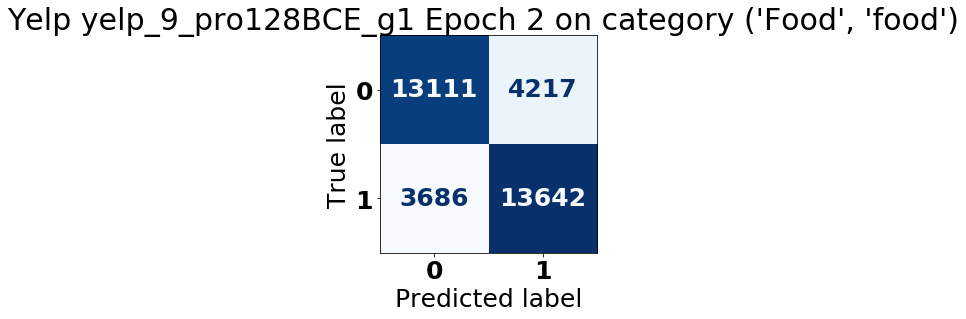

2020-07-02 09:07:40,388 : INFO : wrote 2165 events to disk


Time for [evaluate model - 3]: 0:01:42.496122
Start on [prepare validation data] ...


  0%|          | 1/541 [00:00<00:57,  9.33it/s]2020-07-02 09:07:41,860 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673661.cuda2
2020-07-02 09:07:41,861 : INFO : wrote 1 event to disk
2020-07-02 09:07:41,862 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.261850
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 541/541 [00:53<00:00, 10.12it/s]


Time for [prediction]: 0:00:53.434233
Accuracy in epoch 2: 0.9299838112858464
Confusion Matrix:
[[8006  642]
 [ 569 8079]]

CM: [8006  642  569 8079] 
[tn, fp, fn, tp]
  accuracy: 0.930
 precision: 0.930
    recall: 0.930
  f1-score: 0.930

Accuracy:  0.93 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Health & Medical', 'health')]:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8648
           1       0.93      0.93      0.93      8648

    accuracy                           0.93     17296
   macro avg       0.93      0.93      0.93     17296
weighted avg       0.93      0.93      0.93     17296



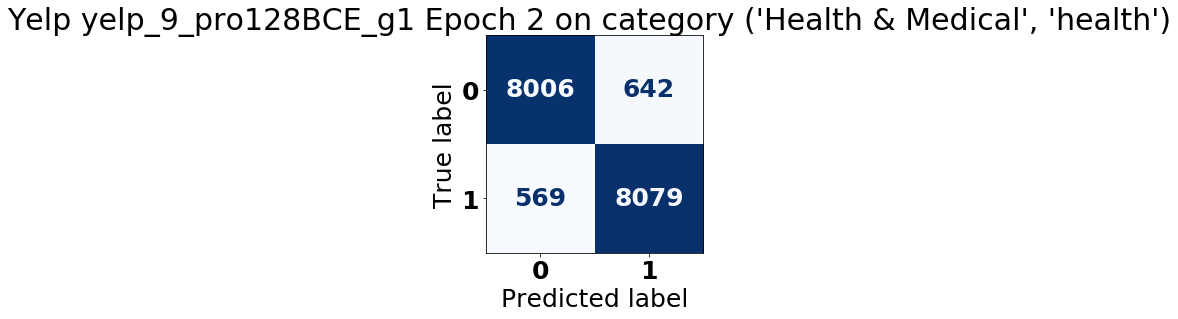

2020-07-02 09:08:35,391 : INFO : wrote 1081 events to disk


Time for [evaluate model - 3]: 0:00:53.661143
Start on [prepare validation data] ...


  0%|          | 0/428 [00:00<?, ?it/s]2020-07-02 09:08:36,619 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673716.cuda2
2020-07-02 09:08:36,630 : INFO : wrote 1 event to disk
2020-07-02 09:08:36,630 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.026734
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 428/428 [00:43<00:00,  9.86it/s]


Time for [prediction]: 0:00:43.405169
Accuracy in epoch 2: 0.8651431074766355
Confusion Matrix:
[[5866  982]
 [ 865 5983]]

CM: [5866  982  865 5983] 
[tn, fp, fn, tp]
  accuracy: 0.865
 precision: 0.865
    recall: 0.865
  f1-score: 0.865

Accuracy:  0.865 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Home Services', 'homeservices')]:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      6848
           1       0.86      0.87      0.87      6848

    accuracy                           0.87     13696
   macro avg       0.87      0.87      0.87     13696
weighted avg       0.87      0.87      0.87     13696



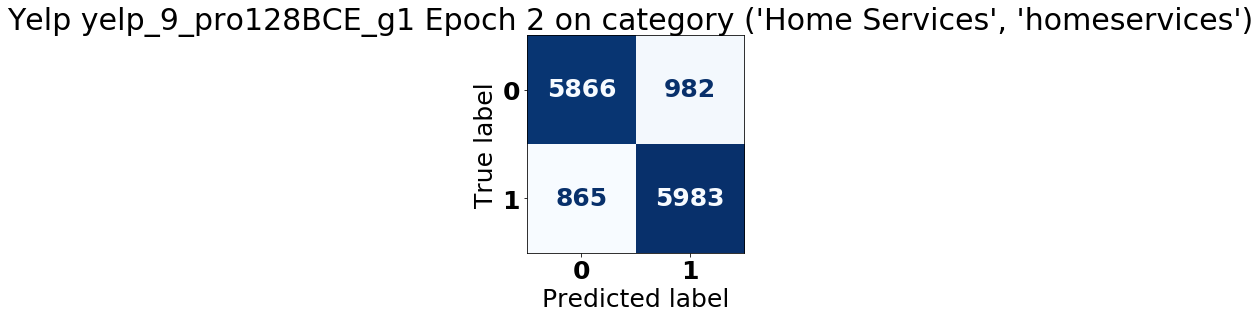

2020-07-02 09:09:20,109 : INFO : wrote 855 events to disk
  0%|          | 0/2 [00:00<?, ?it/s]2020-07-02 09:09:20,261 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673760.cuda2
2020-07-02 09:09:20,272 : INFO : wrote 1 event to disk
2020-07-02 09:09:20,273 : INFO : wrote 1 event to disk


Time for [evaluate model - 3]: 0:00:43.607421
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.008579
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 2/2 [00:00<00:00, 10.13it/s]


Time for [prediction]: 0:00:00.198332
Accuracy in epoch 2: 0.734375
Confusion Matrix:
[[25  7]
 [10 22]]

CM: [25  7 10 22] 
[tn, fp, fn, tp]
  accuracy: 0.734
 precision: 0.736
    recall: 0.734
  f1-score: 0.734

Accuracy:  0.734 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Local Flavor', 'localflavor')]:
              precision    recall  f1-score   support

           0       0.71      0.78      0.75        32
           1       0.76      0.69      0.72        32

    accuracy                           0.73        64
   macro avg       0.74      0.73      0.73        64
weighted avg       0.74      0.73      0.73        64



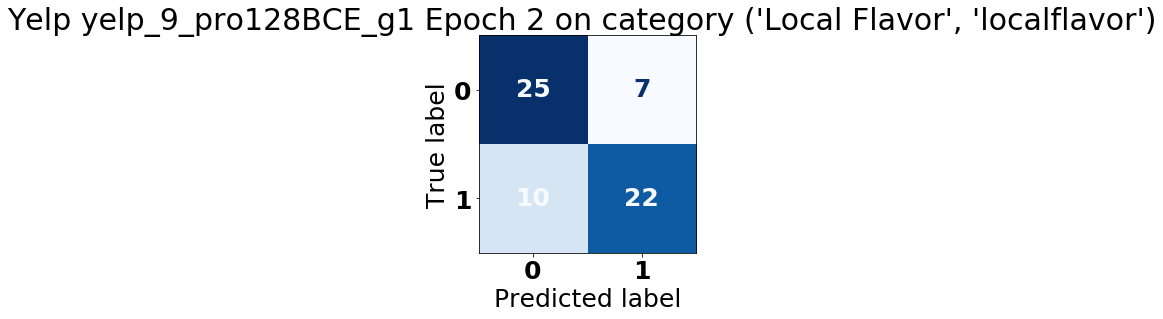

2020-07-02 09:09:20,415 : INFO : wrote 3 events to disk
  0%|          | 0/2 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:00.263391
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.006261
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:09:20,571 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673760.cuda2
2020-07-02 09:09:20,574 : INFO : wrote 1 event to disk
2020-07-02 09:09:20,575 : INFO : wrote 1 event to disk
100%|██████████| 2/2 [00:00<00:00, 10.46it/s]

Time for [prediction]: 0:00:00.191928
Accuracy in epoch 2: 0.765625
Confusion Matrix:


[[24  8]
 [ 7 25]]

CM: [24  8  7 25] 
[tn, fp, fn, tp]
  accuracy: 0.766
 precision: 0.766
    recall: 0.766
  f1-score: 0.766

Accuracy:  0.766 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Mass Media', 'massmedia')]:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        32
           1       0.76      0.78      0.77        32

    accuracy                           0.77        64
   macro avg       0.77      0.77      0.77        64
weighted avg       0.77      0.77      0.77        64



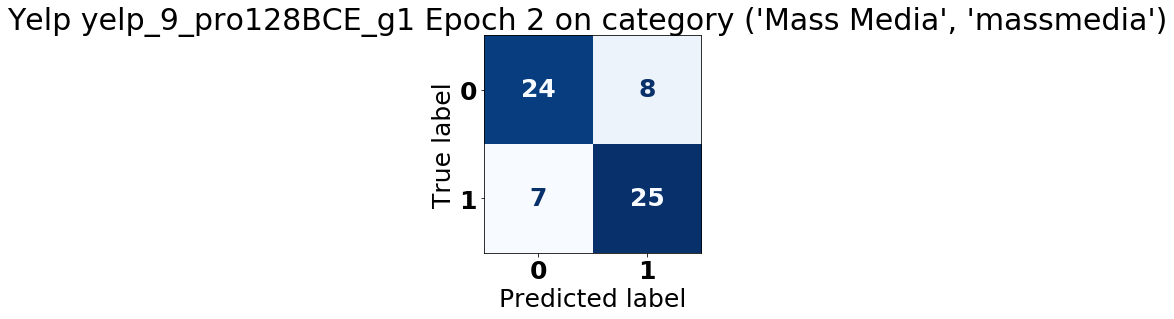

2020-07-02 09:09:20,716 : INFO : wrote 3 events to disk


Time for [evaluate model - 3]: 0:00:00.256108
Start on [prepare validation data] ...


  0%|          | 0/327 [00:00<?, ?it/s]2020-07-02 09:09:21,861 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673761.cuda2
2020-07-02 09:09:21,864 : INFO : wrote 1 event to disk
2020-07-02 09:09:21,865 : INFO : wrote 1 event to disk
  1%|          | 2/327 [00:00<00:31, 10.23it/s]

Time for [prepare validation data]: 0:00:00.974983
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 327/327 [00:31<00:00, 10.43it/s]


Time for [prediction]: 0:00:31.342491
Accuracy in epoch 2: 0.7356651376146789
Confusion Matrix:
[[3725 1507]
 [1259 3973]]

CM: [3725 1507 1259 3973] 
[tn, fp, fn, tp]
  accuracy: 0.736
 precision: 0.736
    recall: 0.736
  f1-score: 0.736

Accuracy:  0.736 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Nightlife', 'nightlife')]:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      5232
           1       0.72      0.76      0.74      5232

    accuracy                           0.74     10464
   macro avg       0.74      0.74      0.74     10464
weighted avg       0.74      0.74      0.74     10464



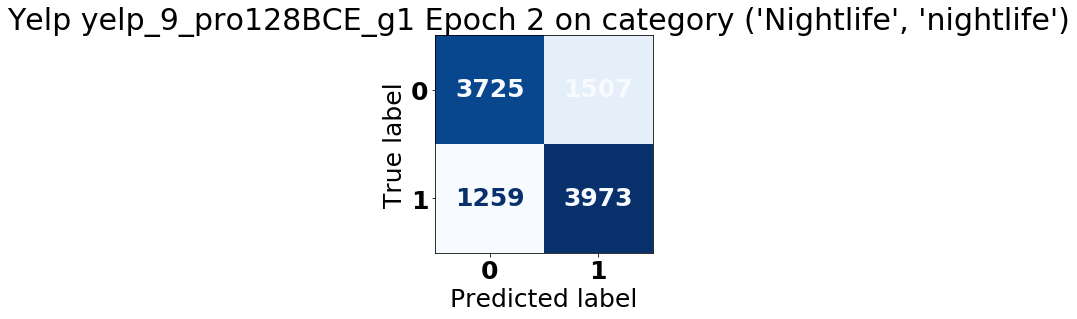

2020-07-02 09:09:53,251 : INFO : wrote 653 events to disk


Time for [evaluate model - 3]: 0:00:31.505850
Start on [prepare validation data] ...


  0%|          | 0/259 [00:00<?, ?it/s]2020-07-02 09:09:54,028 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673794.cuda2
2020-07-02 09:09:54,035 : INFO : wrote 1 event to disk
2020-07-02 09:09:54,036 : INFO : wrote 1 event to disk
  1%|          | 2/259 [00:00<00:25, 10.01it/s]

Time for [prepare validation data]: 0:00:00.620100
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 259/259 [00:25<00:00,  9.98it/s]

Time for [prediction]: 0:00:25.940650
Accuracy in epoch 2: 0.8455029013539652
Confusion Matrix:
[[3427  709]
 [ 569 3567]]

CM: [3427  709  569 3567] 
[tn, fp, fn, tp]
  accuracy: 0.846
 precision: 0.846
    recall: 0.846
  f1-score: 0.845

Accuracy:  0.846 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Pets', 'pets')]:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84      4136
           1       0.83      0.86      0.85      4136

    accuracy                           0.85      8272
   macro avg       0.85      0.85      0.85      8272
weighted avg       0.85      0.85      0.85      8272



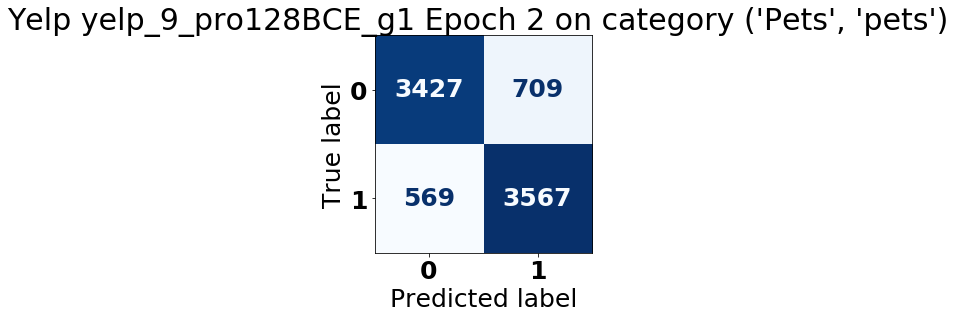

2020-07-02 09:10:19,999 : INFO : wrote 517 events to disk


Time for [evaluate model - 3]: 0:00:26.086597
Start on [prepare validation data] ...


  0%|          | 0/21 [00:00<?, ?it/s]2020-07-02 09:10:20,218 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673820.cuda2
2020-07-02 09:10:20,220 : INFO : wrote 1 event to disk
2020-07-02 09:10:20,221 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.052117
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 21/21 [00:02<00:00, 10.42it/s]

Time for [prediction]: 0:00:02.017011
Accuracy in epoch 2: 0.8258928571428571
Confusion Matrix:
[[271  65]
 [ 52 284]]

CM: [271  65  52 284] 
[tn, fp, fn, tp]
  accuracy: 0.826
 precision: 0.826
    recall: 0.826
  f1-score: 0.826

Accuracy:  0.826 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Public Services & Government', 'publicservicesgovt')]:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       336
           1       0.81      0.85      0.83       336

    accuracy                           0.83       672
   macro avg       0.83      0.83      0.83       672
weighted avg       0.83      0.83      0.83       672



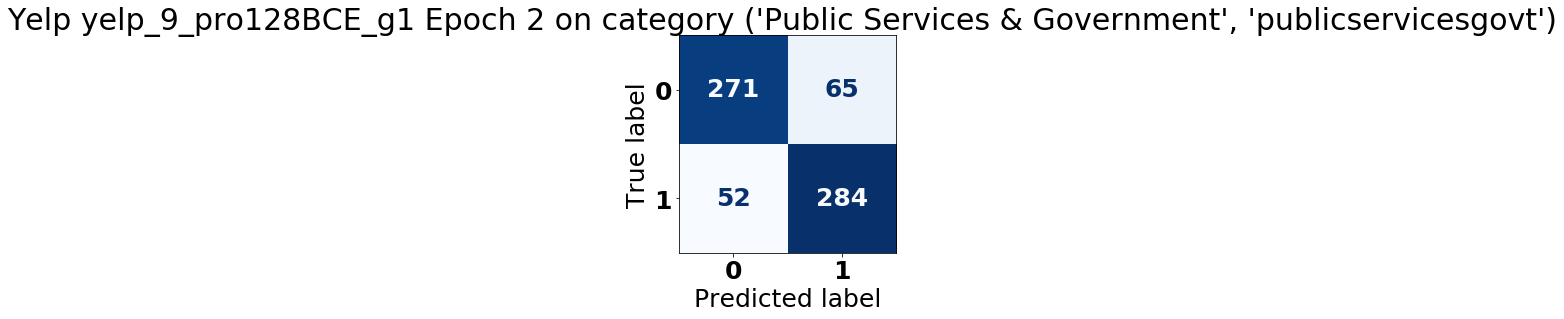

2020-07-02 09:10:22,195 : INFO : wrote 41 events to disk


Time for [evaluate model - 3]: 0:00:02.095398
Start on [prepare validation data] ...


  0%|          | 1/7437 [00:00<14:09,  8.76it/s]2020-07-02 09:10:39,872 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593673839.cuda2
2020-07-02 09:10:39,878 : INFO : wrote 1 event to disk
2020-07-02 09:10:39,879 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:17.426966
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 7437/7437 [11:53<00:00, 10.42it/s]


Time for [prediction]: 0:11:53.632961
Accuracy in epoch 2: 0.8463258034153557
Confusion Matrix:
[[ 98810  20182]
 [ 16390 102602]]

CM: [ 98810  20182  16390 102602] 
[tn, fp, fn, tp]
  accuracy: 0.846
 precision: 0.847
    recall: 0.846
  f1-score: 0.846

Accuracy:  0.846 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Restaurants', 'restaurants')]:
              precision    recall  f1-score   support

           0       0.86      0.83      0.84    118992
           1       0.84      0.86      0.85    118992

    accuracy                           0.85    237984
   macro avg       0.85      0.85      0.85    237984
weighted avg       0.85      0.85      0.85    237984



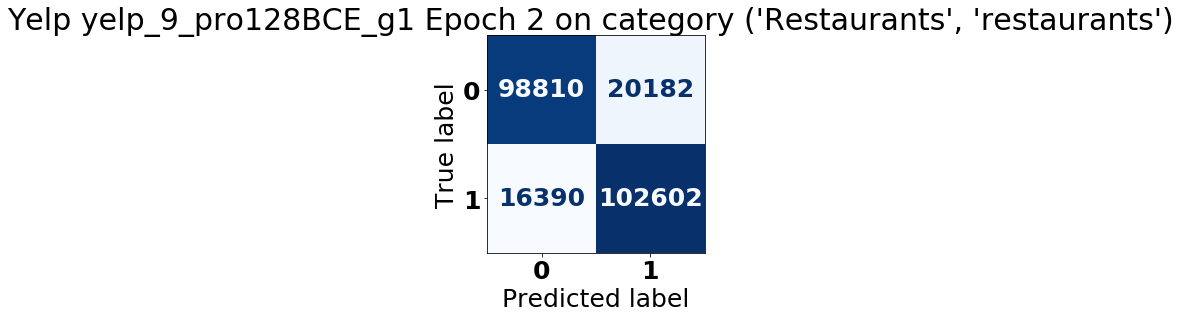

2020-07-02 09:22:35,502 : INFO : wrote 2361 events to disk


Time for [evaluate model - 3]: 0:11:55.761796
Start on [prepare validation data] ...


  0%|          | 1/702 [00:00<01:13,  9.50it/s]2020-07-02 09:22:37,376 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g1/events.out.tfevents.1593674557.cuda2
2020-07-02 09:22:37,395 : INFO : wrote 1 event to disk
2020-07-02 09:22:37,396 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.694287
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 702/702 [01:08<00:00, 10.25it/s]


Time for [prediction]: 0:01:08.487586
Accuracy in epoch 2: 0.8597202423378475
Confusion Matrix:
[[9474 1750]
 [1399 9825]]

CM: [9474 1750 1399 9825] 
[tn, fp, fn, tp]
  accuracy: 0.860
 precision: 0.860
    recall: 0.860
  f1-score: 0.860

Accuracy:  0.86 

Report for [BERTClassifier - yelp_9_pro128BCE_g1 - ('Shopping', 'shopping')]:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86     11224
           1       0.85      0.88      0.86     11224

    accuracy                           0.86     22448
   macro avg       0.86      0.86      0.86     22448
weighted avg       0.86      0.86      0.86     22448



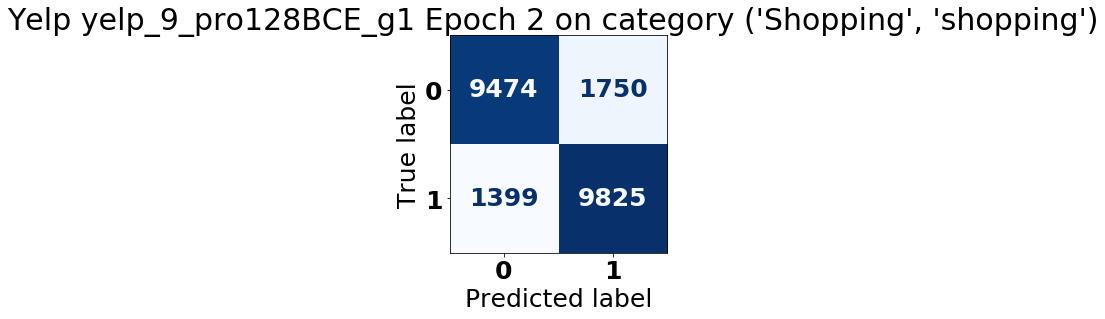

2020-07-02 09:23:46,049 : INFO : wrote 1403 events to disk


Time for [evaluate model - 3]: 0:01:08.781902
Eval model (('Education', 'education'), ('Automotive', 'auto'), ('Bicycles', 'bicycles'), ('Mass Media', 'massmedia'), ('Home Services', 'homeservices')) #36624...
Load data/yelp_9_pro128BCE_g2/bert.model.checkpoint2.params ...
Start on [prepare validation data] ...


  0%|          | 1/239 [00:00<00:26,  8.99it/s]2020-07-02 09:23:50,143 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674630.cuda2
2020-07-02 09:23:50,144 : INFO : wrote 1 event to disk
2020-07-02 09:23:50,145 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.581508
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 239/239 [00:23<00:00, 10.13it/s]


Time for [prediction]: 0:00:23.596235
Accuracy in epoch 2: 0.8632075471698113
Confusion Matrix:
[[3332  484]
 [ 560 3256]]

CM: [3332  484  560 3256] 
[tn, fp, fn, tp]
  accuracy: 0.863
 precision: 0.863
    recall: 0.863
  f1-score: 0.863

Accuracy:  0.863 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Active Life', 'active')]:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3816
           1       0.87      0.85      0.86      3816

    accuracy                           0.86      7632
   macro avg       0.86      0.86      0.86      7632
weighted avg       0.86      0.86      0.86      7632



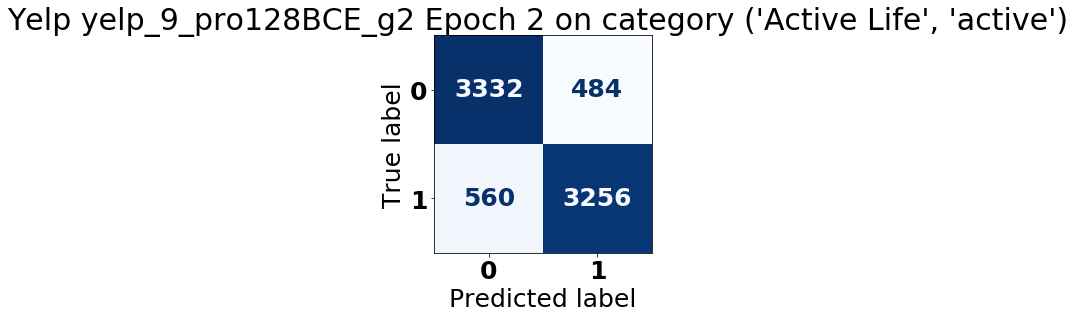

2020-07-02 09:24:13,746 : INFO : wrote 477 events to disk


Time for [evaluate model - 3]: 0:00:23.733436
Start on [prepare validation data] ...


  0%|          | 0/158 [00:00<?, ?it/s]2020-07-02 09:24:14,295 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674654.cuda2
2020-07-02 09:24:14,298 : INFO : wrote 1 event to disk
2020-07-02 09:24:14,299 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.376824
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 158/158 [00:15<00:00, 10.14it/s]


Time for [prediction]: 0:00:15.584496
Accuracy in epoch 2: 0.8208069620253164
Confusion Matrix:
[[2098  430]
 [ 476 2052]]

CM: [2098  430  476 2052] 
[tn, fp, fn, tp]
  accuracy: 0.821
 precision: 0.821
    recall: 0.821
  f1-score: 0.821

Accuracy:  0.821 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Arts & Entertainment', 'arts')]:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      2528
           1       0.83      0.81      0.82      2528

    accuracy                           0.82      5056
   macro avg       0.82      0.82      0.82      5056
weighted avg       0.82      0.82      0.82      5056



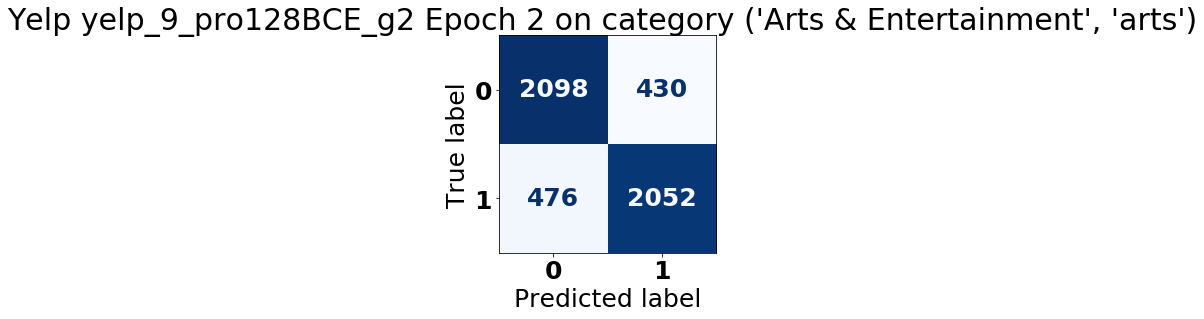

2020-07-02 09:24:29,878 : INFO : wrote 315 events to disk


Time for [evaluate model - 3]: 0:00:15.703672
Start on [prepare validation data] ...


  0%|          | 1/1099 [00:00<01:57,  9.32it/s]2020-07-02 09:24:32,646 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674672.cuda2
2020-07-02 09:24:32,646 : INFO : wrote 1 event to disk
2020-07-02 09:24:32,659 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:02.602021
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 1099/1099 [01:46<00:00, 10.29it/s]


Time for [prediction]: 0:01:46.805981
Accuracy in epoch 2: 0.8696517979062358
Confusion Matrix:
[[15457  2119]
 [ 2463 15113]]

CM: [15457  2119  2463 15113] 
[tn, fp, fn, tp]
  accuracy: 0.870
 precision: 0.870
    recall: 0.870
  f1-score: 0.870

Accuracy:  0.87 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Beauty & Spas', 'beautysvc')]:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     17576
           1       0.88      0.86      0.87     17576

    accuracy                           0.87     35152
   macro avg       0.87      0.87      0.87     35152
weighted avg       0.87      0.87      0.87     35152



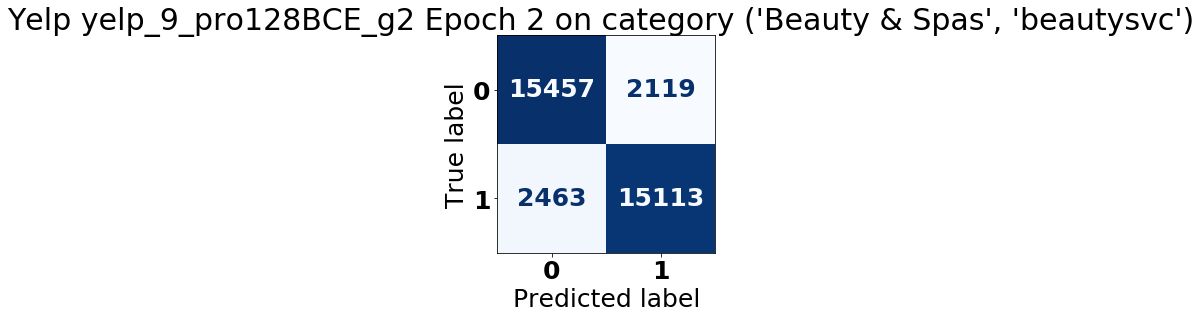

2020-07-02 09:26:19,730 : INFO : wrote 2197 events to disk


Time for [evaluate model - 3]: 0:01:47.199483


  3%|▎         | 1/30 [00:00<00:02,  9.73it/s]

Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.079698
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:26:20,011 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674779.cuda2
2020-07-02 09:26:20,012 : INFO : wrote 1 event to disk
2020-07-02 09:26:20,012 : INFO : wrote 1 event to disk
100%|██████████| 30/30 [00:03<00:00,  9.68it/s]


Time for [prediction]: 0:00:03.101256
Accuracy in epoch 2: 0.8728813559322034
Confusion Matrix:
[[420  52]
 [ 68 404]]

CM: [420  52  68 404] 
[tn, fp, fn, tp]
  accuracy: 0.873
 precision: 0.873
    recall: 0.873
  f1-score: 0.873

Accuracy:  0.873 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Event Planning & Services', 'eventservices')]:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       472
           1       0.89      0.86      0.87       472

    accuracy                           0.87       944
   macro avg       0.87      0.87      0.87       944
weighted avg       0.87      0.87      0.87       944



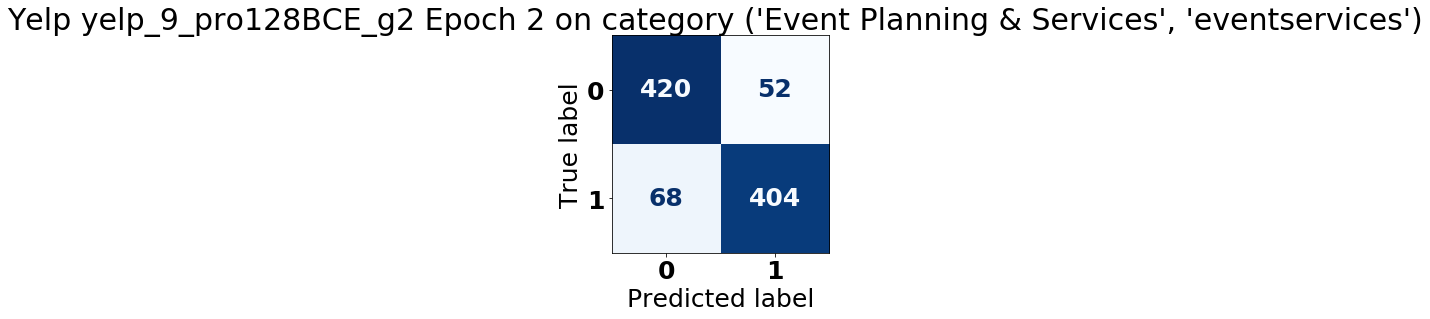

2020-07-02 09:26:23,072 : INFO : wrote 59 events to disk
  0%|          | 0/26 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:03.190480
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.062878
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:26:23,282 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674783.cuda2
2020-07-02 09:26:23,282 : INFO : wrote 1 event to disk
2020-07-02 09:26:23,283 : INFO : wrote 1 event to disk
100%|██████████| 26/26 [00:02<00:00, 10.46it/s]

Time for [prediction]: 0:00:02.487652
Accuracy in epoch 2: 0.8966346153846154
Confusion Matrix:
[[378  38]
 [ 48 368]]

CM: [378  38  48 368] 
[tn, fp, fn, tp]
  accuracy: 0.897
 precision: 0.897
    recall: 0.897
  f1-score: 0.897

Accuracy:  0.897 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Financial Services', 'financialservices')]:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       416
           1       0.91      0.88      0.90       416

    accuracy                           0.90       832
   macro avg       0.90      0.90      0.90       832
weighted avg       0.90      0.90      0.90       832



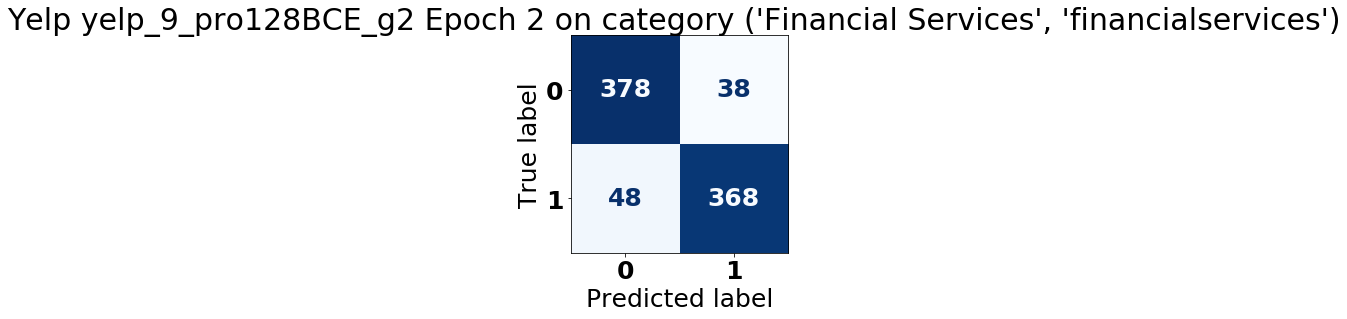

2020-07-02 09:26:25,737 : INFO : wrote 51 events to disk


Time for [evaluate model - 3]: 0:00:02.567172
Start on [prepare validation data] ...


  0%|          | 1/1083 [00:00<02:00,  8.99it/s]2020-07-02 09:26:28,573 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674788.cuda2
2020-07-02 09:26:28,578 : INFO : wrote 1 event to disk
2020-07-02 09:26:28,578 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:02.630069
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 1083/1083 [01:43<00:00, 10.50it/s]


Time for [prediction]: 0:01:43.177815
Accuracy in epoch 2: 0.7603012465373962
Confusion Matrix:
[[13383  3945]
 [ 4362 12966]]

CM: [13383  3945  4362 12966] 
[tn, fp, fn, tp]
  accuracy: 0.760
 precision: 0.760
    recall: 0.760
  f1-score: 0.760

Accuracy:  0.76 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Food', 'food')]:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76     17328
           1       0.77      0.75      0.76     17328

    accuracy                           0.76     34656
   macro avg       0.76      0.76      0.76     34656
weighted avg       0.76      0.76      0.76     34656



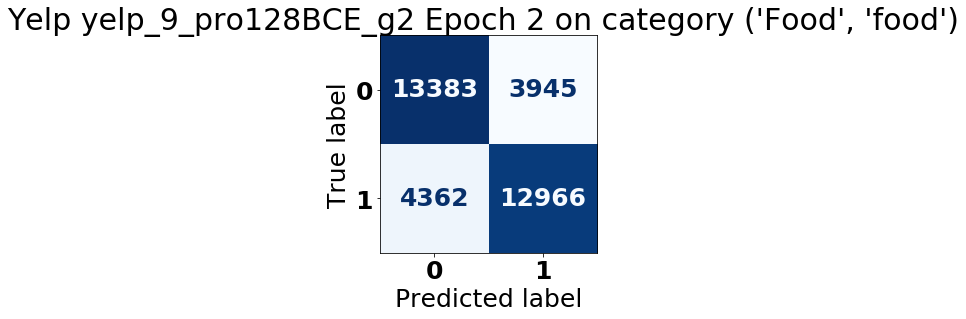

2020-07-02 09:28:12,017 : INFO : wrote 2165 events to disk


Time for [evaluate model - 3]: 0:01:43.572568
Start on [prepare validation data] ...


  0%|          | 1/541 [00:00<01:01,  8.74it/s]2020-07-02 09:28:13,725 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674893.cuda2
2020-07-02 09:28:13,732 : INFO : wrote 1 event to disk
2020-07-02 09:28:13,732 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.497324
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 541/541 [00:53<00:00, 10.04it/s]


Time for [prediction]: 0:00:53.865503
Accuracy in epoch 2: 0.9239130434782609
Confusion Matrix:
[[8067  581]
 [ 735 7913]]

CM: [8067  581  735 7913] 
[tn, fp, fn, tp]
  accuracy: 0.924
 precision: 0.924
    recall: 0.924
  f1-score: 0.924

Accuracy:  0.924 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Health & Medical', 'health')]:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      8648
           1       0.93      0.92      0.92      8648

    accuracy                           0.92     17296
   macro avg       0.92      0.92      0.92     17296
weighted avg       0.92      0.92      0.92     17296



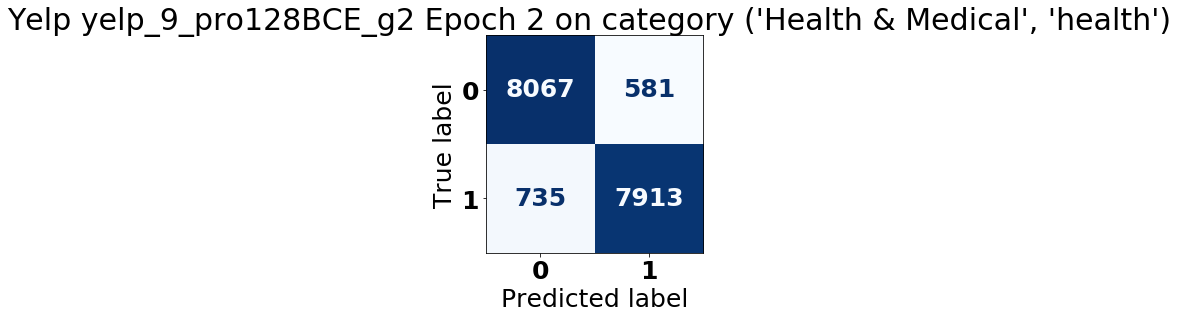

2020-07-02 09:29:07,686 : INFO : wrote 1081 events to disk


Time for [evaluate model - 3]: 0:00:54.092445
Start on [prepare validation data] ...


  0%|          | 0/136 [00:00<?, ?it/s]2020-07-02 09:29:08,154 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674948.cuda2
2020-07-02 09:29:08,165 : INFO : wrote 1 event to disk
2020-07-02 09:29:08,165 : INFO : wrote 1 event to disk
  1%|▏         | 2/136 [00:00<00:12, 10.35it/s]

Time for [prepare validation data]: 0:00:00.323283
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 136/136 [00:13<00:00, 10.17it/s]

Time for [prediction]: 0:00:13.373689
Accuracy in epoch 2: 0.8948339483394834
Confusion Matrix:
[[1948  220]
 [ 236 1932]]

CM: [1948  220  236 1932] 
[tn, fp, fn, tp]
  accuracy: 0.895
 precision: 0.895
    recall: 0.895
  f1-score: 0.895

Accuracy:  0.895 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Hotels & Travel', 'hotelstravel')]:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90      2168
           1       0.90      0.89      0.89      2168

    accuracy                           0.89      4336
   macro avg       0.89      0.89      0.89      4336
weighted avg       0.89      0.89      0.89      4336



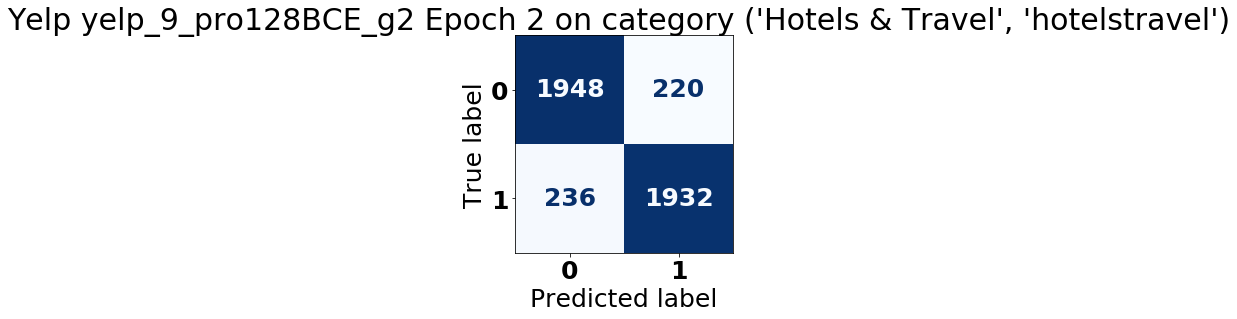

2020-07-02 09:29:21,530 : INFO : wrote 271 events to disk
  0%|          | 0/2 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:13.482229
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.007123
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:29:21,679 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674961.cuda2
2020-07-02 09:29:21,692 : INFO : wrote 1 event to disk
2020-07-02 09:29:21,692 : INFO : wrote 1 event to disk
100%|██████████| 2/2 [00:00<00:00, 10.00it/s]

Time for [prediction]: 0:00:00.200779
Accuracy in epoch 2: 0.734375
Confusion Matrix:
[[26  6]
 [11 21]]

CM: [26  6 11 21] 
[tn, fp, fn, tp]
  accuracy: 0.734
 precision: 0.740
    recall: 0.734
  f1-score: 0.733

Accuracy:  0.734 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Local Flavor', 'localflavor')]:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        32
           1       0.78      0.66      0.71        32

    accuracy                           0.73        64
   macro avg       0.74      0.73      0.73        64
weighted avg       0.74      0.73      0.73        64



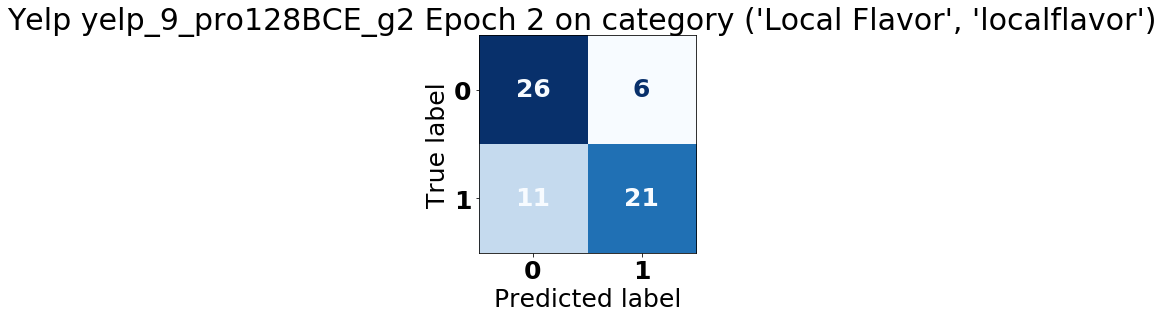

2020-07-02 09:29:21,836 : INFO : wrote 3 events to disk


Time for [evaluate model - 3]: 0:00:00.266544
Start on [prepare validation data] ...


  0%|          | 0/144 [00:00<?, ?it/s]2020-07-02 09:29:22,345 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674962.cuda2
2020-07-02 09:29:22,346 : INFO : wrote 1 event to disk
2020-07-02 09:29:22,347 : INFO : wrote 1 event to disk
  1%|▏         | 2/144 [00:00<00:13, 10.68it/s]

Time for [prepare validation data]: 0:00:00.350828
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 144/144 [00:13<00:00, 10.46it/s]


Time for [prediction]: 0:00:13.767249
Accuracy in epoch 2: 0.9331597222222222
Confusion Matrix:
[[2159  145]
 [ 163 2141]]

CM: [2159  145  163 2141] 
[tn, fp, fn, tp]
  accuracy: 0.933
 precision: 0.933
    recall: 0.933
  f1-score: 0.933

Accuracy:  0.933 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Local Services', 'localservices')]:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      2304
           1       0.94      0.93      0.93      2304

    accuracy                           0.93      4608
   macro avg       0.93      0.93      0.93      4608
weighted avg       0.93      0.93      0.93      4608



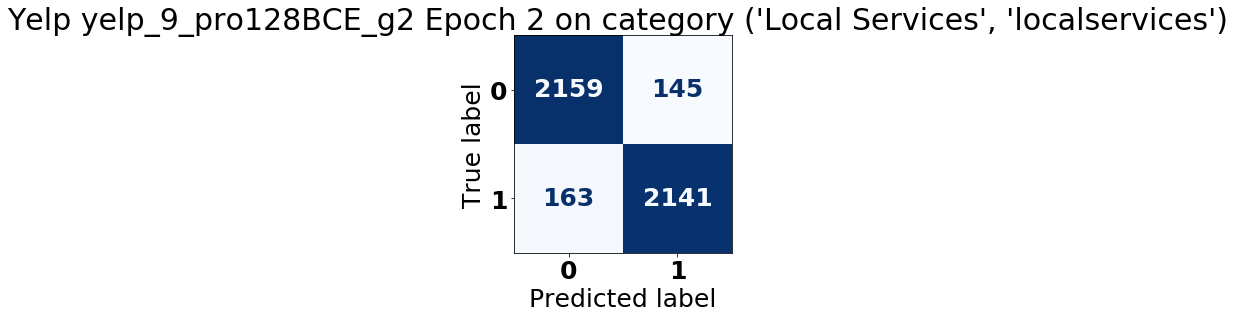

2020-07-02 09:29:36,112 : INFO : wrote 287 events to disk


Time for [evaluate model - 3]: 0:00:13.876734
Start on [prepare validation data] ...


  0%|          | 0/327 [00:00<?, ?it/s]2020-07-02 09:29:37,060 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593674977.cuda2
2020-07-02 09:29:37,061 : INFO : wrote 1 event to disk
2020-07-02 09:29:37,061 : INFO : wrote 1 event to disk
  1%|          | 2/327 [00:00<00:31, 10.19it/s]

Time for [prepare validation data]: 0:00:00.774071
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 327/327 [00:31<00:00, 10.33it/s]


Time for [prediction]: 0:00:31.653628
Accuracy in epoch 2: 0.7249617737003058
Confusion Matrix:
[[3870 1362]
 [1516 3716]]

CM: [3870 1362 1516 3716] 
[tn, fp, fn, tp]
  accuracy: 0.725
 precision: 0.725
    recall: 0.725
  f1-score: 0.725

Accuracy:  0.725 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Nightlife', 'nightlife')]:
              precision    recall  f1-score   support

           0       0.72      0.74      0.73      5232
           1       0.73      0.71      0.72      5232

    accuracy                           0.72     10464
   macro avg       0.73      0.72      0.72     10464
weighted avg       0.73      0.72      0.72     10464



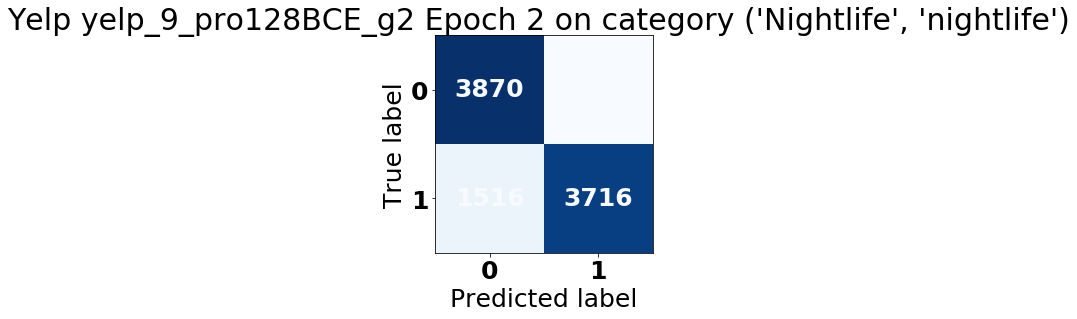

2020-07-02 09:30:08,763 : INFO : wrote 653 events to disk


Time for [evaluate model - 3]: 0:00:31.821774
Start on [prepare validation data] ...


  0%|          | 1/259 [00:00<00:26,  9.87it/s]2020-07-02 09:30:09,571 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593675009.cuda2
2020-07-02 09:30:09,571 : INFO : wrote 1 event to disk
2020-07-02 09:30:09,572 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.636414
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 259/259 [00:26<00:00,  9.68it/s]

Time for [prediction]: 0:00:26.745139
Accuracy in epoch 2: 0.8509429400386848
Confusion Matrix:
[[3550  586]
 [ 647 3489]]

CM: [3550  586  647 3489] 
[tn, fp, fn, tp]
  accuracy: 0.851
 precision: 0.851
    recall: 0.851
  f1-score: 0.851

Accuracy:  0.851 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Pets', 'pets')]:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      4136
           1       0.86      0.84      0.85      4136

    accuracy                           0.85      8272
   macro avg       0.85      0.85      0.85      8272
weighted avg       0.85      0.85      0.85      8272



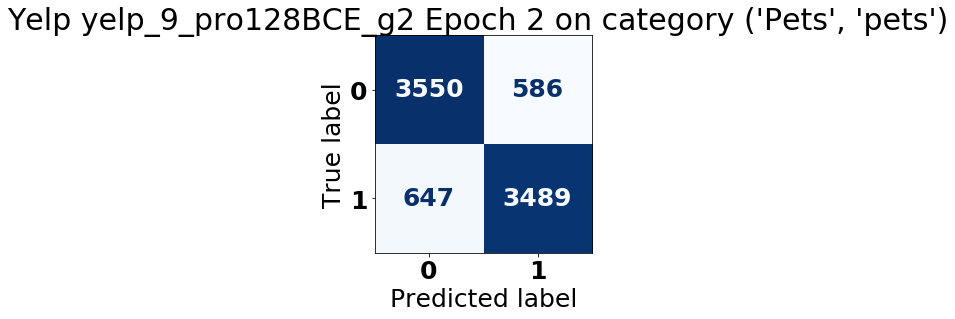

2020-07-02 09:30:36,335 : INFO : wrote 517 events to disk


Time for [evaluate model - 3]: 0:00:26.891830


  0%|          | 0/13 [00:00<?, ?it/s]2020-07-02 09:30:36,552 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593675036.cuda2
2020-07-02 09:30:36,562 : INFO : wrote 1 event to disk
2020-07-02 09:30:36,563 : INFO : wrote 1 event to disk


Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.034217
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 13/13 [00:01<00:00, 10.51it/s]


Time for [prediction]: 0:00:01.237491
Accuracy in epoch 2: 0.9525
Confusion Matrix:
[[191   9]
 [ 10 190]]

CM: [191   9  10 190] 
[tn, fp, fn, tp]
  accuracy: 0.953
 precision: 0.953
    recall: 0.952
  f1-score: 0.952

Accuracy:  0.952 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Professional Services', 'professional')]:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       200
           1       0.95      0.95      0.95       200

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



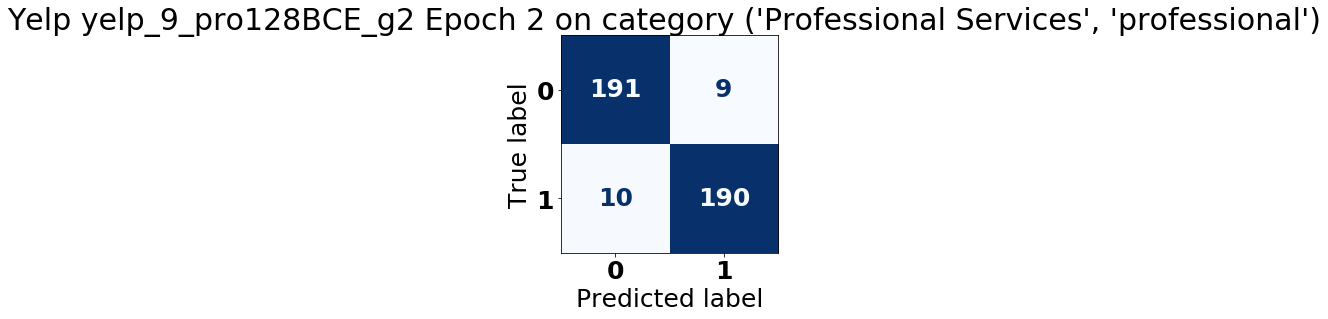

2020-07-02 09:30:37,756 : INFO : wrote 25 events to disk
  0%|          | 0/21 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:01.314657
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.053178
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:30:37,969 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593675037.cuda2
2020-07-02 09:30:37,982 : INFO : wrote 1 event to disk
2020-07-02 09:30:37,982 : INFO : wrote 1 event to disk
100%|██████████| 21/21 [00:02<00:00, 10.13it/s]


Time for [prediction]: 0:00:02.073990
Accuracy in epoch 2: 0.8318452380952381
Confusion Matrix:
[[279  57]
 [ 56 280]]

CM: [279  57  56 280] 
[tn, fp, fn, tp]
  accuracy: 0.832
 precision: 0.832
    recall: 0.832
  f1-score: 0.832

Accuracy:  0.832 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Public Services & Government', 'publicservicesgovt')]:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       336
           1       0.83      0.83      0.83       336

    accuracy                           0.83       672
   macro avg       0.83      0.83      0.83       672
weighted avg       0.83      0.83      0.83       672



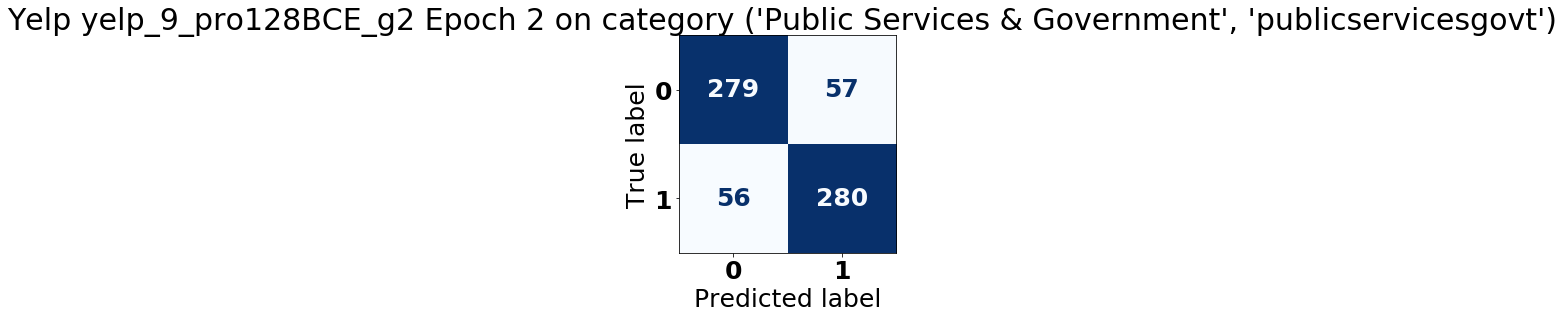

2020-07-02 09:30:40,015 : INFO : wrote 41 events to disk
  0%|          | 0/5 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:02.155875
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.012764
Start on [evaluate model - 3] ...
Start on [prediction] ...


 20%|██        | 1/5 [00:00<00:00,  9.65it/s]2020-07-02 09:30:40,216 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593675040.cuda2
2020-07-02 09:30:40,217 : INFO : wrote 1 event to disk
2020-07-02 09:30:40,217 : INFO : wrote 1 event to disk
100%|██████████| 5/5 [00:00<00:00, 11.04it/s]


Time for [prediction]: 0:00:00.454028
Accuracy in epoch 2: 0.8402777777777778
Confusion Matrix:
[[61 11]
 [12 60]]

CM: [61 11 12 60] 
[tn, fp, fn, tp]
  accuracy: 0.840
 precision: 0.840
    recall: 0.840
  f1-score: 0.840

Accuracy:  0.84 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Religious Organizations', 'religiousorgs')]:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84        72
           1       0.85      0.83      0.84        72

    accuracy                           0.84       144
   macro avg       0.84      0.84      0.84       144
weighted avg       0.84      0.84      0.84       144



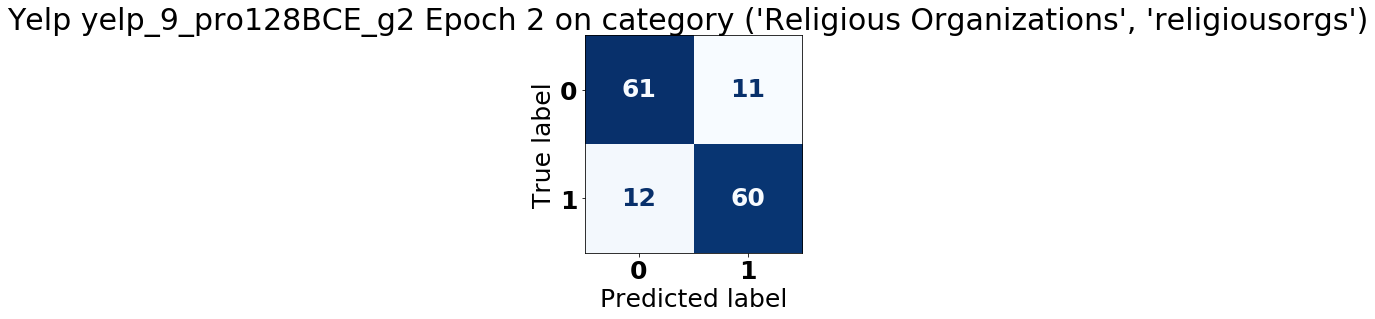

2020-07-02 09:30:40,618 : INFO : wrote 9 events to disk


Time for [evaluate model - 3]: 0:00:00.527007
Start on [prepare validation data] ...


  0%|          | 1/7437 [00:00<14:43,  8.42it/s]2020-07-02 09:30:59,897 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593675059.cuda2
2020-07-02 09:30:59,900 : INFO : wrote 1 event to disk
2020-07-02 09:30:59,900 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:18.993047
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 7437/7437 [12:05<00:00, 10.25it/s]


Time for [prediction]: 0:12:05.294745
Accuracy in epoch 2: 0.8257487898346108
Confusion Matrix:
[[99317 19675]
 [21794 97198]]

CM: [99317 19675 21794 97198] 
[tn, fp, fn, tp]
  accuracy: 0.826
 precision: 0.826
    recall: 0.826
  f1-score: 0.826

Accuracy:  0.826 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Restaurants', 'restaurants')]:
              precision    recall  f1-score   support

           0       0.82      0.83      0.83    118992
           1       0.83      0.82      0.82    118992

    accuracy                           0.83    237984
   macro avg       0.83      0.83      0.83    237984
weighted avg       0.83      0.83      0.83    237984



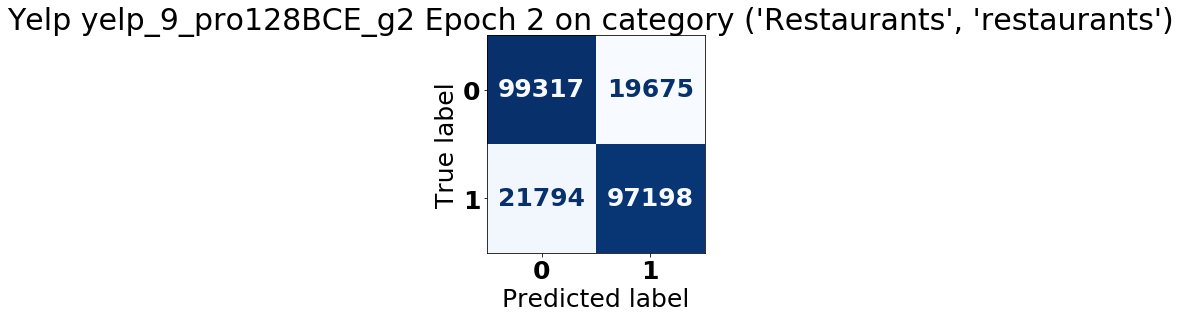

2020-07-02 09:43:07,282 : INFO : wrote 2567 events to disk


Time for [evaluate model - 3]: 0:12:07.527369
Start on [prepare validation data] ...


  0%|          | 1/702 [00:00<01:14,  9.46it/s]2020-07-02 09:43:09,237 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g2/events.out.tfevents.1593675789.cuda2
2020-07-02 09:43:09,253 : INFO : wrote 1 event to disk
2020-07-02 09:43:09,253 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.758407
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 702/702 [01:09<00:00, 10.10it/s]


Time for [prediction]: 0:01:09.533244
Accuracy in epoch 2: 0.845064148253742
Confusion Matrix:
[[9624 1600]
 [1878 9346]]

CM: [9624 1600 1878 9346] 
[tn, fp, fn, tp]
  accuracy: 0.845
 precision: 0.845
    recall: 0.845
  f1-score: 0.845

Accuracy:  0.845 

Report for [BERTClassifier - yelp_9_pro128BCE_g2 - ('Shopping', 'shopping')]:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     11224
           1       0.85      0.83      0.84     11224

    accuracy                           0.85     22448
   macro avg       0.85      0.85      0.85     22448
weighted avg       0.85      0.85      0.85     22448



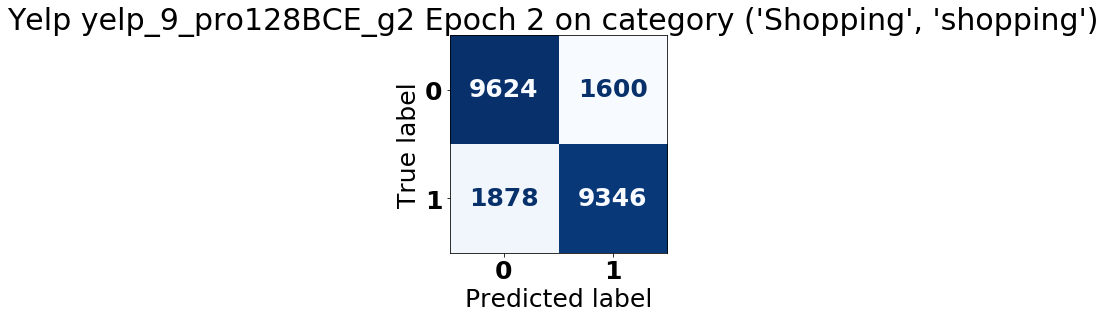

2020-07-02 09:44:18,967 : INFO : wrote 1403 events to disk


Time for [evaluate model - 3]: 0:01:09.844716
Eval model (('Pets', 'pets'), ('Nightlife', 'nightlife'), ('Financial Services', 'financialservices'), ('Beauty & Spas', 'beautysvc'), ('Food', 'food')) #89376...
Load data/yelp_9_pro128BCE_g3/bert.model.checkpoint2.params ...
Start on [prepare validation data] ...


  0%|          | 1/239 [00:00<00:23,  9.94it/s]2020-07-02 09:44:23,060 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593675863.cuda2
2020-07-02 09:44:23,064 : INFO : wrote 1 event to disk
2020-07-02 09:44:23,064 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.591358
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 239/239 [00:24<00:00,  9.94it/s]


Time for [prediction]: 0:00:24.046756
Accuracy in epoch 2: 0.8525943396226415
Confusion Matrix:
[[3260  556]
 [ 569 3247]]

CM: [3260  556  569 3247] 
[tn, fp, fn, tp]
  accuracy: 0.853
 precision: 0.853
    recall: 0.853
  f1-score: 0.853

Accuracy:  0.853 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Active Life', 'active')]:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3816
           1       0.85      0.85      0.85      3816

    accuracy                           0.85      7632
   macro avg       0.85      0.85      0.85      7632
weighted avg       0.85      0.85      0.85      7632



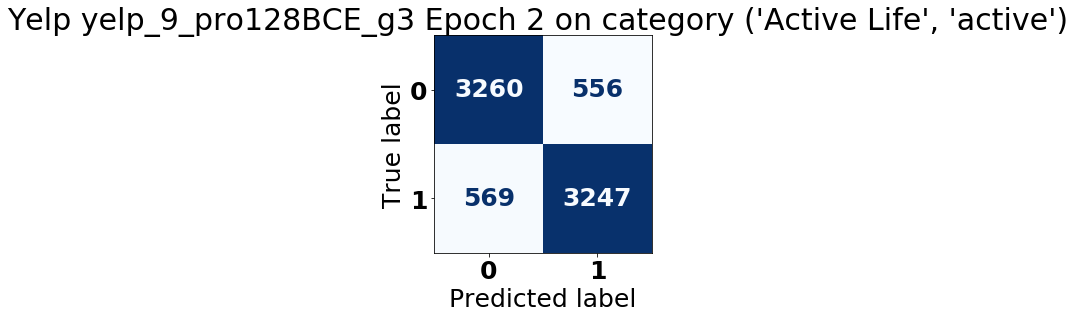

2020-07-02 09:44:47,124 : INFO : wrote 477 events to disk


Time for [evaluate model - 3]: 0:00:24.183079
Start on [prepare validation data] ...


  1%|          | 1/158 [00:00<00:15,  9.97it/s]2020-07-02 09:44:47,697 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593675887.cuda2
2020-07-02 09:44:47,697 : INFO : wrote 1 event to disk
2020-07-02 09:44:47,698 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:00.390680
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 158/158 [00:15<00:00, 10.00it/s]


Time for [prediction]: 0:00:15.805986
Accuracy in epoch 2: 0.8026107594936709
Confusion Matrix:
[[2046  482]
 [ 516 2012]]

CM: [2046  482  516 2012] 
[tn, fp, fn, tp]
  accuracy: 0.803
 precision: 0.803
    recall: 0.803
  f1-score: 0.803

Accuracy:  0.803 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Arts & Entertainment', 'arts')]:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      2528
           1       0.81      0.80      0.80      2528

    accuracy                           0.80      5056
   macro avg       0.80      0.80      0.80      5056
weighted avg       0.80      0.80      0.80      5056



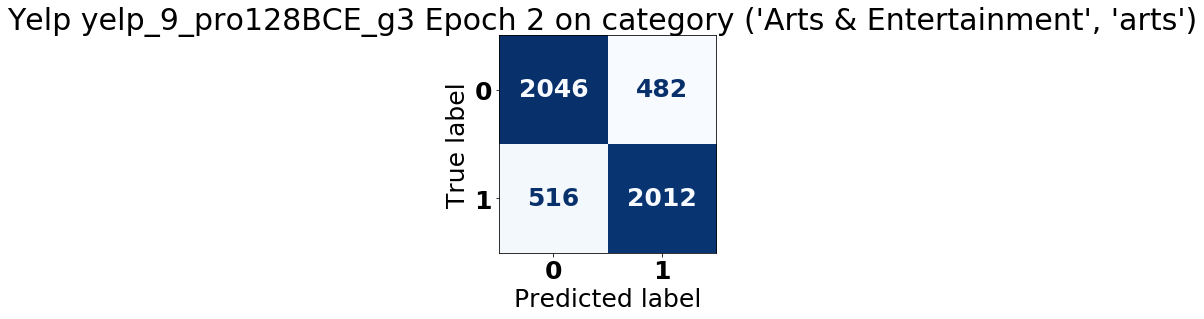

2020-07-02 09:45:03,496 : INFO : wrote 315 events to disk


Time for [evaluate model - 3]: 0:00:15.926299
Start on [prepare validation data] ...


  0%|          | 1/699 [00:00<01:15,  9.28it/s]2020-07-02 09:45:05,408 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593675905.cuda2
2020-07-02 09:45:05,408 : INFO : wrote 1 event to disk
2020-07-02 09:45:05,409 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.699636
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 699/699 [01:10<00:00,  9.98it/s]


Time for [prediction]: 0:01:10.048164
Accuracy in epoch 2: 0.918365522174535
Confusion Matrix:
[[10265   919]
 [  907 10277]]

CM: [10265   919   907 10277] 
[tn, fp, fn, tp]
  accuracy: 0.918
 precision: 0.918
    recall: 0.918
  f1-score: 0.918

Accuracy:  0.918 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Automotive', 'auto')]:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     11184
           1       0.92      0.92      0.92     11184

    accuracy                           0.92     22368
   macro avg       0.92      0.92      0.92     22368
weighted avg       0.92      0.92      0.92     22368



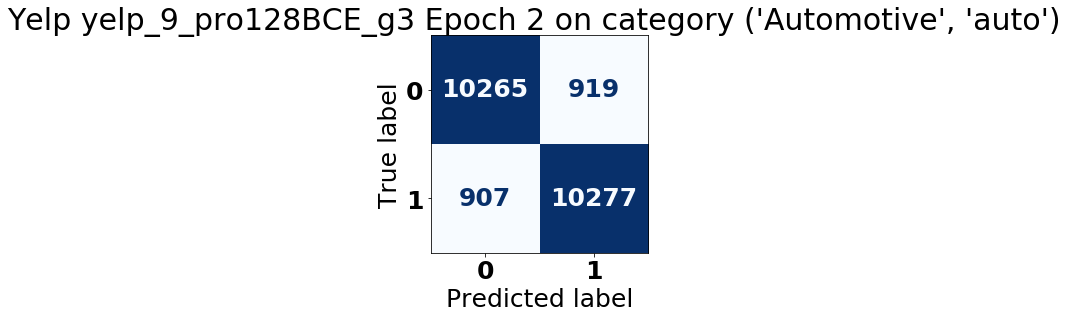

2020-07-02 09:46:15,598 : INFO : wrote 1397 events to disk
  6%|▋         | 1/16 [00:00<00:01,  9.23it/s]2020-07-02 09:46:15,816 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593675975.cuda2
2020-07-02 09:46:15,817 : INFO : wrote 1 event to disk
2020-07-02 09:46:15,817 : INFO : wrote 1 event to disk


Time for [evaluate model - 3]: 0:01:10.324863
Skip empty df: ('Bicycles', 'bicycles')
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.044285
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 16/16 [00:01<00:00,  9.78it/s]


Time for [prediction]: 0:00:01.637698
Accuracy in epoch 2: 0.9032258064516129
Confusion Matrix:
[[226  22]
 [ 26 222]]

CM: [226  22  26 222] 
[tn, fp, fn, tp]
  accuracy: 0.903
 precision: 0.903
    recall: 0.903
  f1-score: 0.903

Accuracy:  0.903 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Education', 'education')]:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       248
           1       0.91      0.90      0.90       248

    accuracy                           0.90       496
   macro avg       0.90      0.90      0.90       496
weighted avg       0.90      0.90      0.90       496



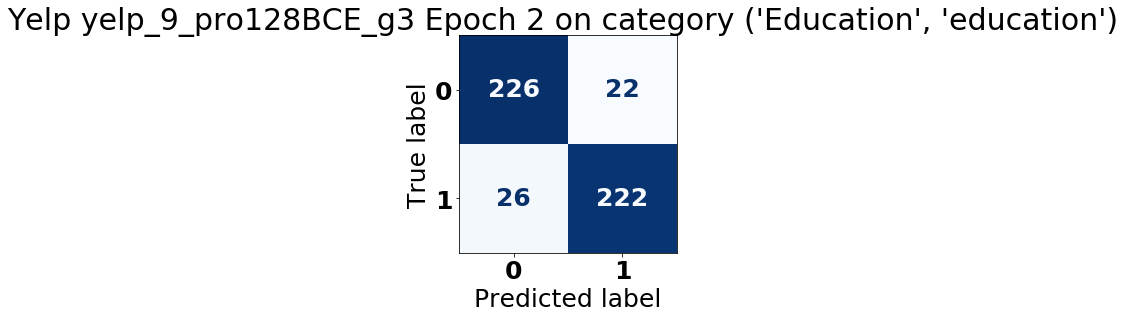

2020-07-02 09:46:17,394 : INFO : wrote 31 events to disk


Time for [evaluate model - 3]: 0:00:01.717033
Start on [prepare validation data] ...


  3%|▎         | 1/30 [00:00<00:03,  9.52it/s]

Time for [prepare validation data]: 0:00:00.076325
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:46:17,672 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593675977.cuda2
2020-07-02 09:46:17,673 : INFO : wrote 1 event to disk
2020-07-02 09:46:17,673 : INFO : wrote 1 event to disk
100%|██████████| 30/30 [00:03<00:00,  9.60it/s]


Time for [prediction]: 0:00:03.127592
Accuracy in epoch 2: 0.878177966101695
Confusion Matrix:
[[420  52]
 [ 63 409]]

CM: [420  52  63 409] 
[tn, fp, fn, tp]
  accuracy: 0.878
 precision: 0.878
    recall: 0.878
  f1-score: 0.878

Accuracy:  0.878 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Event Planning & Services', 'eventservices')]:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       472
           1       0.89      0.87      0.88       472

    accuracy                           0.88       944
   macro avg       0.88      0.88      0.88       944
weighted avg       0.88      0.88      0.88       944



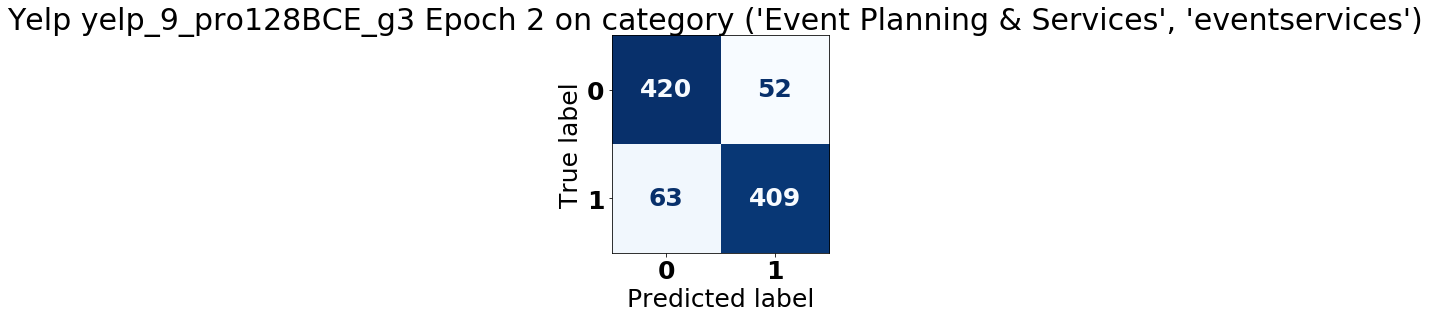

2020-07-02 09:46:20,748 : INFO : wrote 59 events to disk


Time for [evaluate model - 3]: 0:00:03.208349
Start on [prepare validation data] ...


  0%|          | 1/541 [00:00<00:56,  9.54it/s]2020-07-02 09:46:22,283 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593675982.cuda2
2020-07-02 09:46:22,286 : INFO : wrote 1 event to disk
2020-07-02 09:46:22,287 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.320013
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 541/541 [00:54<00:00,  9.84it/s]


Time for [prediction]: 0:00:54.956959
Accuracy in epoch 2: 0.9191720629047179
Confusion Matrix:
[[7980  668]
 [ 730 7918]]

CM: [7980  668  730 7918] 
[tn, fp, fn, tp]
  accuracy: 0.919
 precision: 0.919
    recall: 0.919
  f1-score: 0.919

Accuracy:  0.919 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Health & Medical', 'health')]:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      8648
           1       0.92      0.92      0.92      8648

    accuracy                           0.92     17296
   macro avg       0.92      0.92      0.92     17296
weighted avg       0.92      0.92      0.92     17296



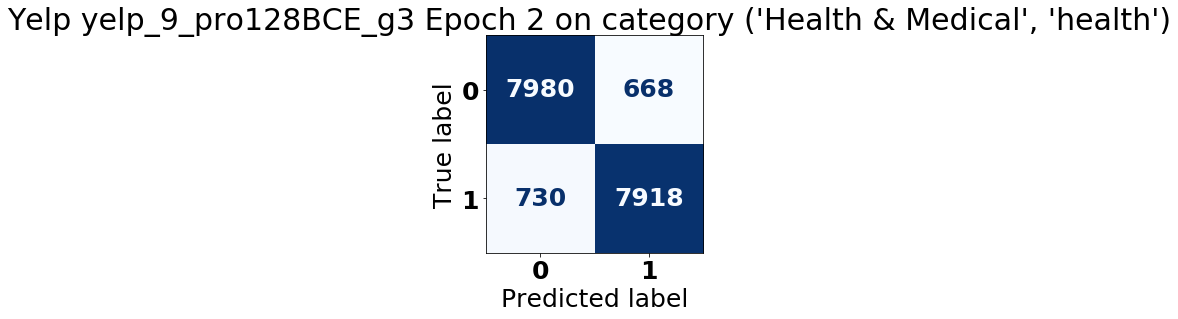

2020-07-02 09:47:17,349 : INFO : wrote 1081 events to disk


Time for [evaluate model - 3]: 0:00:55.193102
Start on [prepare validation data] ...


  0%|          | 1/428 [00:00<00:43,  9.71it/s]2020-07-02 09:47:18,872 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676038.cuda2
2020-07-02 09:47:18,875 : INFO : wrote 1 event to disk
2020-07-02 09:47:18,876 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.295371
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 428/428 [00:44<00:00,  9.59it/s]


Time for [prediction]: 0:00:44.617445
Accuracy in epoch 2: 0.931804906542056
Confusion Matrix:
[[6400  448]
 [ 486 6362]]

CM: [6400  448  486 6362] 
[tn, fp, fn, tp]
  accuracy: 0.932
 precision: 0.932
    recall: 0.932
  f1-score: 0.932

Accuracy:  0.932 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Home Services', 'homeservices')]:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6848
           1       0.93      0.93      0.93      6848

    accuracy                           0.93     13696
   macro avg       0.93      0.93      0.93     13696
weighted avg       0.93      0.93      0.93     13696



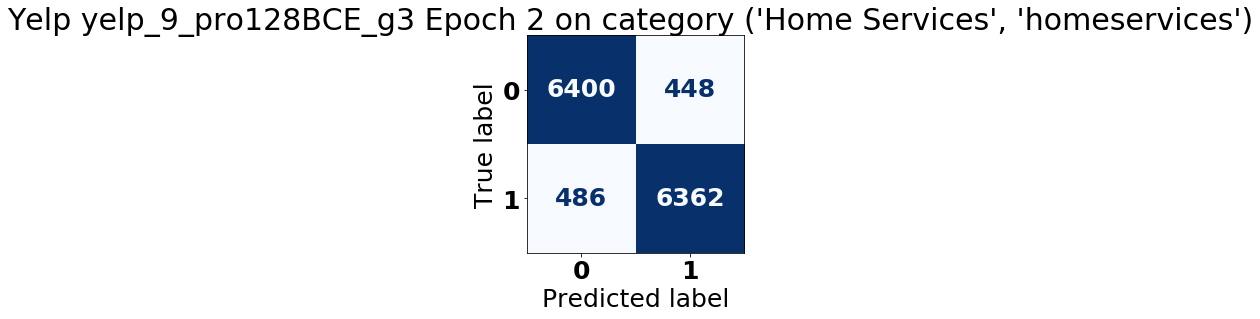

2020-07-02 09:48:03,566 : INFO : wrote 855 events to disk


Time for [evaluate model - 3]: 0:00:44.825889
Start on [prepare validation data] ...


  0%|          | 0/136 [00:00<?, ?it/s]2020-07-02 09:48:04,063 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676084.cuda2
2020-07-02 09:48:04,075 : INFO : wrote 1 event to disk
2020-07-02 09:48:04,075 : INFO : wrote 1 event to disk
  1%|▏         | 2/136 [00:00<00:13, 10.14it/s]

Time for [prepare validation data]: 0:00:00.347761
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 136/136 [00:13<00:00,  9.96it/s]

Time for [prediction]: 0:00:13.649683
Accuracy in epoch 2: 0.8756918819188192
Confusion Matrix:
[[1877  291]
 [ 248 1920]]

CM: [1877  291  248 1920] 
[tn, fp, fn, tp]
  accuracy: 0.876
 precision: 0.876
    recall: 0.876
  f1-score: 0.876

Accuracy:  0.876 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Hotels & Travel', 'hotelstravel')]:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2168
           1       0.87      0.89      0.88      2168

    accuracy                           0.88      4336
   macro avg       0.88      0.88      0.88      4336
weighted avg       0.88      0.88      0.88      4336



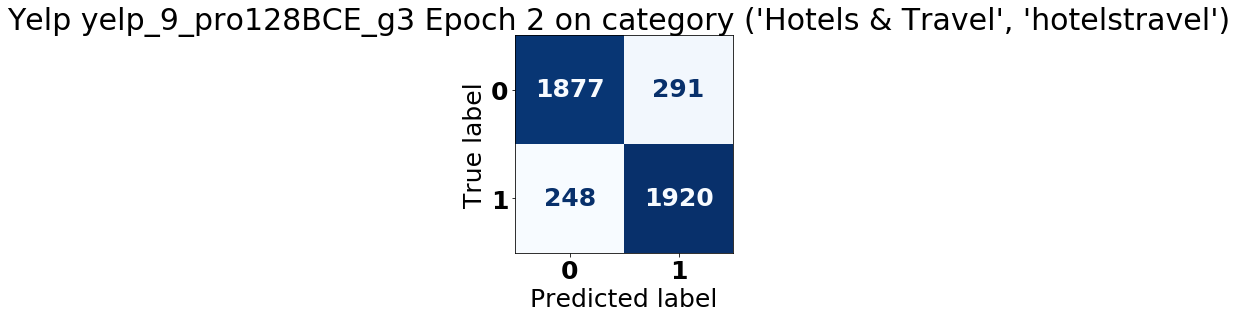

2020-07-02 09:48:17,719 : INFO : wrote 271 events to disk
  0%|          | 0/2 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:13.764018
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.007905
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:48:17,876 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676097.cuda2
2020-07-02 09:48:17,885 : INFO : wrote 1 event to disk
2020-07-02 09:48:17,887 : INFO : wrote 1 event to disk
100%|██████████| 2/2 [00:00<00:00,  9.81it/s]

Time for [prediction]: 0:00:00.204802
Accuracy in epoch 2: 0.75
Confusion Matrix:
[[25  7]
 [ 9 23]]

CM: [25  7  9 23] 
[tn, fp, fn, tp]
  accuracy: 0.750
 precision: 0.751
    recall: 0.750
  f1-score: 0.750

Accuracy:  0.75 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Local Flavor', 'localflavor')]:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76        32
           1       0.77      0.72      0.74        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64



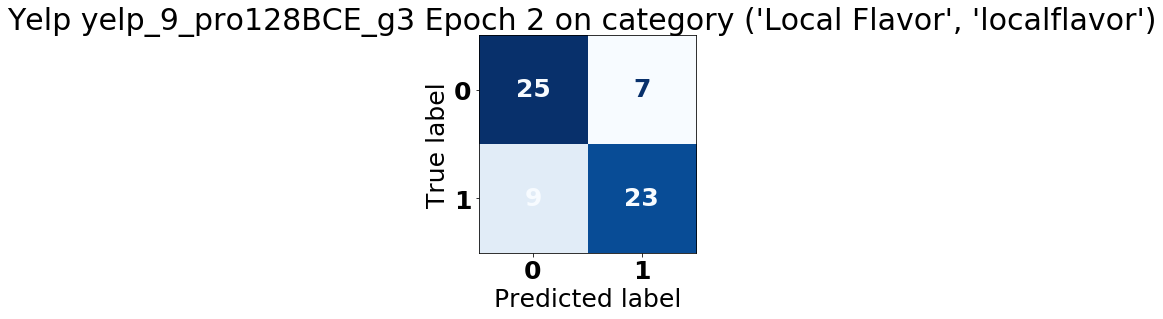

2020-07-02 09:48:18,035 : INFO : wrote 3 events to disk


Time for [evaluate model - 3]: 0:00:00.274490
Start on [prepare validation data] ...


  0%|          | 0/144 [00:00<?, ?it/s]2020-07-02 09:48:18,558 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676098.cuda2
2020-07-02 09:48:18,559 : INFO : wrote 1 event to disk
2020-07-02 09:48:18,560 : INFO : wrote 1 event to disk
  1%|▏         | 2/144 [00:00<00:13, 10.40it/s]

Time for [prepare validation data]: 0:00:00.357395
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 144/144 [00:14<00:00, 10.26it/s]

Time for [prediction]: 0:00:14.036313
Accuracy in epoch 2: 0.9225260416666666
Confusion Matrix:
[[2111  193]
 [ 164 2140]]

CM: [2111  193  164 2140] 
[tn, fp, fn, tp]
  accuracy: 0.923
 precision: 0.923
    recall: 0.923
  f1-score: 0.923

Accuracy:  0.923 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Local Services', 'localservices')]:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      2304
           1       0.92      0.93      0.92      2304

    accuracy                           0.92      4608
   macro avg       0.92      0.92      0.92      4608
weighted avg       0.92      0.92      0.92      4608



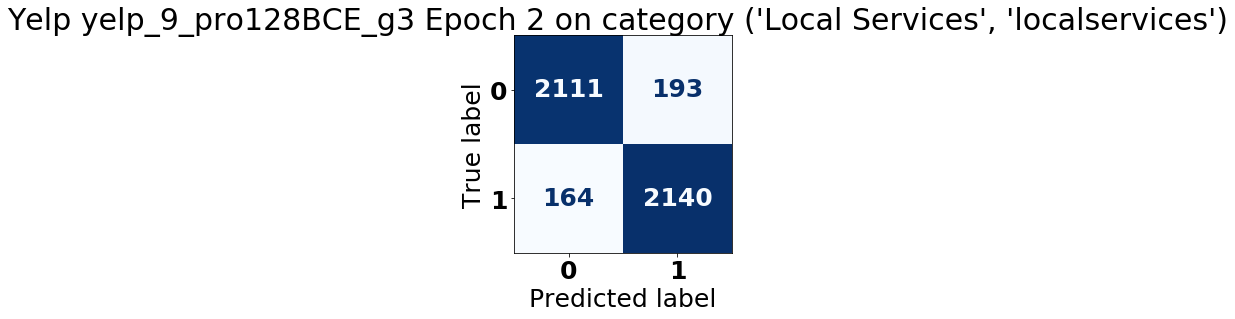

2020-07-02 09:48:32,593 : INFO : wrote 287 events to disk
  0%|          | 0/2 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:14.147461
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.007371
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:48:32,755 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676112.cuda2
2020-07-02 09:48:32,761 : INFO : wrote 1 event to disk
2020-07-02 09:48:32,761 : INFO : wrote 1 event to disk
100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


Time for [prediction]: 0:00:00.197850
Accuracy in epoch 2: 0.875
Confusion Matrix:
[[27  5]
 [ 3 29]]

CM: [27  5  3 29] 
[tn, fp, fn, tp]
  accuracy: 0.875
 precision: 0.876
    recall: 0.875
  f1-score: 0.875

Accuracy:  0.875 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Mass Media', 'massmedia')]:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.85      0.91      0.88        32

    accuracy                           0.88        64
   macro avg       0.88      0.88      0.87        64
weighted avg       0.88      0.88      0.87        64



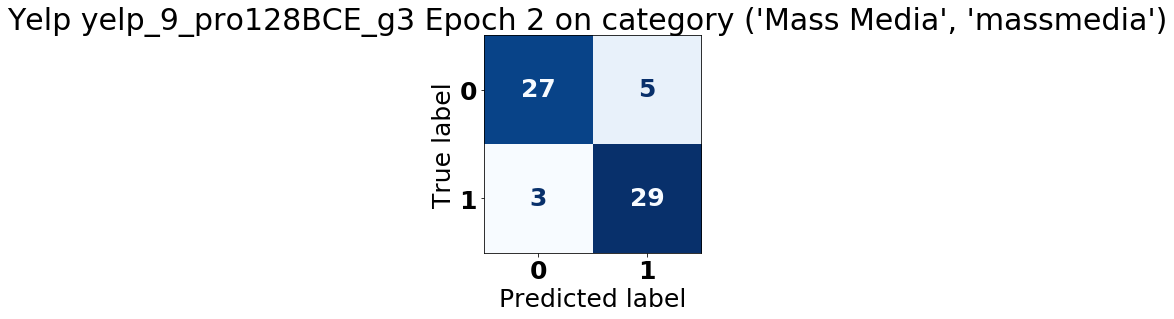

2020-07-02 09:48:32,909 : INFO : wrote 3 events to disk
  0%|          | 0/13 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:00.267420
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.032619
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:48:33,132 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676113.cuda2
2020-07-02 09:48:33,133 : INFO : wrote 1 event to disk
2020-07-02 09:48:33,133 : INFO : wrote 1 event to disk
100%|██████████| 13/13 [00:01<00:00, 10.56it/s]


Time for [prediction]: 0:00:01.232243
Accuracy in epoch 2: 0.9325
Confusion Matrix:
[[183  17]
 [ 10 190]]

CM: [183  17  10 190] 
[tn, fp, fn, tp]
  accuracy: 0.932
 precision: 0.933
    recall: 0.932
  f1-score: 0.932

Accuracy:  0.932 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Professional Services', 'professional')]:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       200
           1       0.92      0.95      0.93       200

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



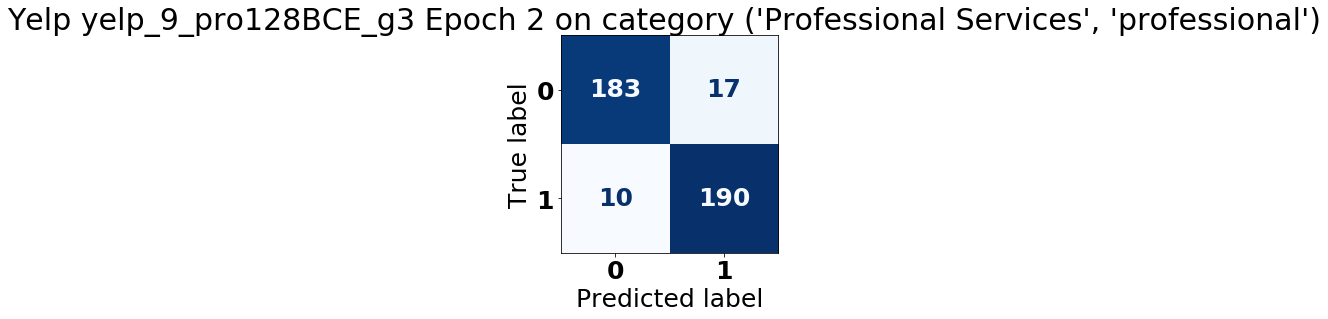

2020-07-02 09:48:34,319 : INFO : wrote 25 events to disk
  0%|          | 0/21 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:01.306811
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.053289
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:48:34,532 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676114.cuda2
2020-07-02 09:48:34,546 : INFO : wrote 1 event to disk
2020-07-02 09:48:34,546 : INFO : wrote 1 event to disk
100%|██████████| 21/21 [00:02<00:00, 10.32it/s]


Time for [prediction]: 0:00:02.036278
Accuracy in epoch 2: 0.8288690476190477
Confusion Matrix:
[[271  65]
 [ 50 286]]

CM: [271  65  50 286] 
[tn, fp, fn, tp]
  accuracy: 0.829
 precision: 0.830
    recall: 0.829
  f1-score: 0.829

Accuracy:  0.829 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Public Services & Government', 'publicservicesgovt')]:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       336
           1       0.81      0.85      0.83       336

    accuracy                           0.83       672
   macro avg       0.83      0.83      0.83       672
weighted avg       0.83      0.83      0.83       672



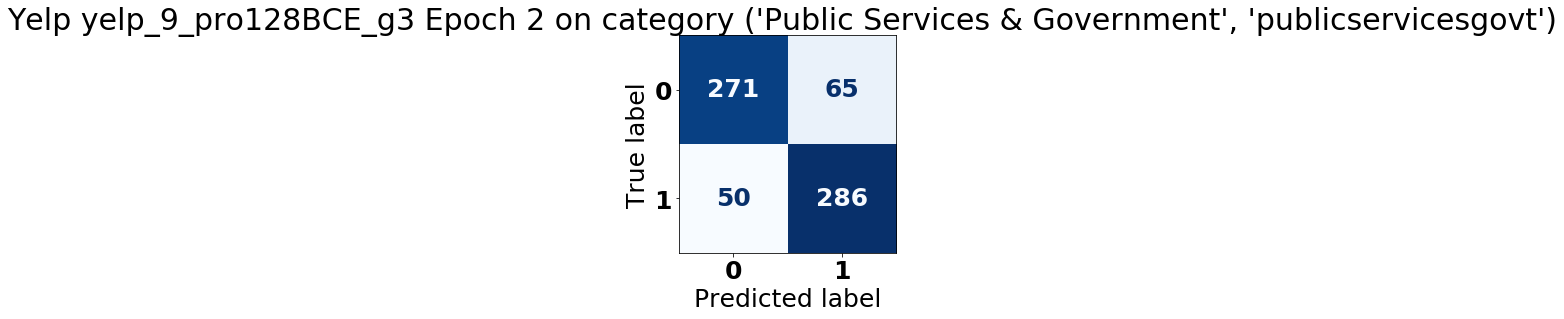

2020-07-02 09:48:36,537 : INFO : wrote 41 events to disk
  0%|          | 0/5 [00:00<?, ?it/s]

Time for [evaluate model - 3]: 0:00:02.114182
Start on [prepare validation data] ...
Time for [prepare validation data]: 0:00:00.012391
Start on [evaluate model - 3] ...
Start on [prediction] ...


2020-07-02 09:48:36,722 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676116.cuda2
2020-07-02 09:48:36,729 : INFO : wrote 1 event to disk
2020-07-02 09:48:36,730 : INFO : wrote 1 event to disk
100%|██████████| 5/5 [00:00<00:00, 11.33it/s]

Time for [prediction]: 0:00:00.442370
Accuracy in epoch 2: 0.9027777777777778
Confusion Matrix:
[[65  7]
 [ 7 65]]

CM: [65  7  7 65] 
[tn, fp, fn, tp]
  accuracy: 0.903
 precision: 0.903
    recall: 0.903
  f1-score: 0.903

Accuracy:  0.903 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Religious Organizations', 'religiousorgs')]:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        72
           1       0.90      0.90      0.90        72

    accuracy                           0.90       144
   macro avg       0.90      0.90      0.90       144
weighted avg       0.90      0.90      0.90       144



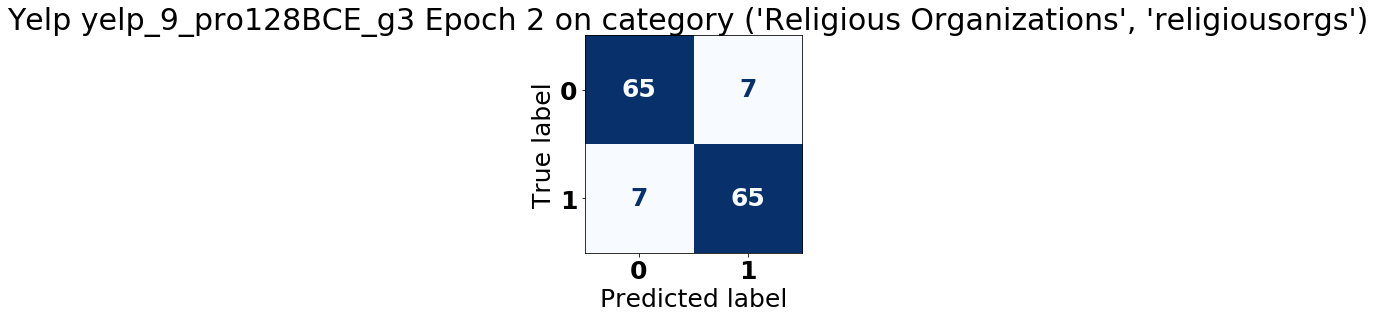

2020-07-02 09:48:37,122 : INFO : wrote 9 events to disk


Time for [evaluate model - 3]: 0:00:00.511442
Start on [prepare validation data] ...


  0%|          | 1/7437 [00:00<15:25,  8.04it/s]2020-07-02 09:48:55,115 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676135.cuda2
2020-07-02 09:48:55,126 : INFO : wrote 1 event to disk
2020-07-02 09:48:55,127 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:17.744669
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 7437/7437 [12:02<00:00, 10.29it/s]


Time for [prediction]: 0:12:02.891599
Accuracy in epoch 2: 0.8363041212854646
Confusion Matrix:
[[99681 19311]
 [19646 99346]]

CM: [99681 19311 19646 99346] 
[tn, fp, fn, tp]
  accuracy: 0.836
 precision: 0.836
    recall: 0.836
  f1-score: 0.836

Accuracy:  0.836 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Restaurants', 'restaurants')]:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84    118992
           1       0.84      0.83      0.84    118992

    accuracy                           0.84    237984
   macro avg       0.84      0.84      0.84    237984
weighted avg       0.84      0.84      0.84    237984



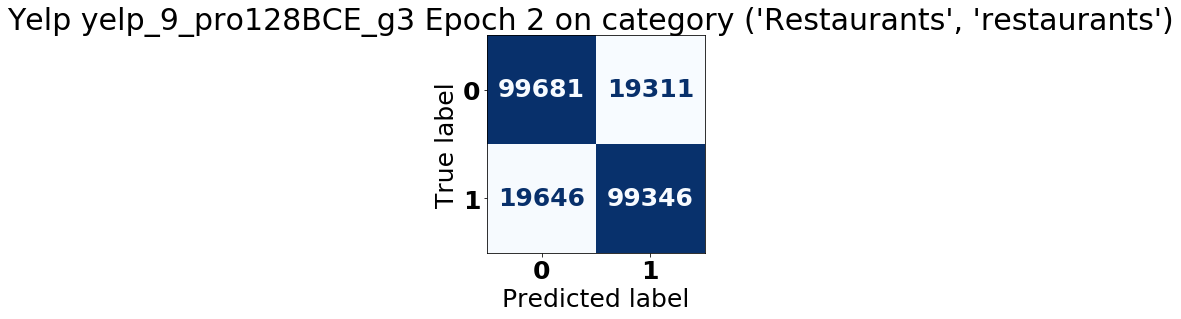

2020-07-02 10:01:00,079 : INFO : wrote 2523 events to disk


Time for [evaluate model - 3]: 0:12:05.100903
Start on [prepare validation data] ...


  0%|          | 1/702 [00:00<01:14,  9.45it/s]2020-07-02 10:01:02,050 : INFO : successfully opened events file: data/yelp_9_pro128BCE_g3/events.out.tfevents.1593676862.cuda2
2020-07-02 10:01:02,051 : INFO : wrote 1 event to disk
2020-07-02 10:01:02,051 : INFO : wrote 1 event to disk


Time for [prepare validation data]: 0:00:01.759288
Start on [evaluate model - 3] ...
Start on [prediction] ...


100%|██████████| 702/702 [01:09<00:00, 10.10it/s]


Time for [prediction]: 0:01:09.473821
Accuracy in epoch 2: 0.8413221667854597
Confusion Matrix:
[[9482 1742]
 [1820 9404]]

CM: [9482 1742 1820 9404] 
[tn, fp, fn, tp]
  accuracy: 0.841
 precision: 0.841
    recall: 0.841
  f1-score: 0.841

Accuracy:  0.841 

Report for [BERTClassifier - yelp_9_pro128BCE_g3 - ('Shopping', 'shopping')]:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     11224
           1       0.84      0.84      0.84     11224

    accuracy                           0.84     22448
   macro avg       0.84      0.84      0.84     22448
weighted avg       0.84      0.84      0.84     22448



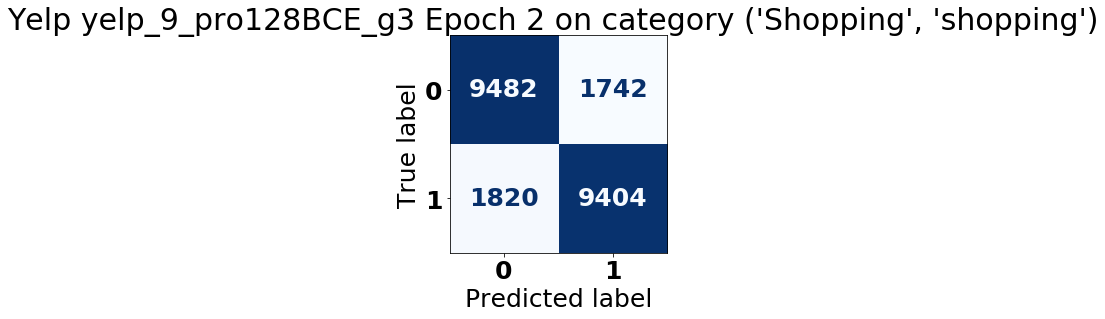

2020-07-02 10:02:11,723 : INFO : wrote 1403 events to disk


Time for [evaluate model - 3]: 0:01:09.802474


In [74]:
cg_results_single_cat = dict()

for i, (cg_ids, (train_df, dev_df, dev_dfs)) in enumerate(map_cg_train_dev_groups.items()):
    print(f"Eval model {cg_ids} #{len(train_df)}...")
    
    cg_groups = [cg_ids_o for cg_ids_o in groups if cg_ids_o != cg_ids]
    
    run_name = f"{run_name_base}_g{i}"
    fn_run_path = Path(f"data/{run_name}")
    
    fn_model_state = fn_run_path / f"bert.model.checkpoint{num_epochs - 1}.params"
    print(f"Load {fn_model_state} ...")
    model.load_parameters(str(fn_model_state), ctx=ctx)
    
    for cgi, (cg_id, businesses) in enumerate(lookup_rootcat_bid_no_overlap.items()):
        # check if train data, skip since we did not split into eval
        if cg_id in cg_ids:
            continue
        if not businesses:
            print(f"Skip empty df: {cg_id}")
            continue
            
        dev_df = traindev_df[traindev_df.business_id.isin(businesses)]

        with Timer("prepare validation data"):
            X_dev, y_dev = dev_df[names_columns_X], dev_df[names_columns_y]
            _, data_dev = transform_dataset(X_dev, y_dev, transform)

        with Timer(f"evaluate model - {num_epochs}"), SummaryWriter(logdir=str(fn_run_path), flush_secs=600) as sw:
            all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=batch_size, sw=sw)
            print(f"Accuracy in epoch {epoch_id}:", metric.get()[1])

            y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
            with open(fn_run_path / f"{run_name}_g{i}sc{cgi}_preds.p", "wb") as fp:
                pickle.dump(y_true, fp, protocol=pickle.HIGHEST_PROTOCOL)
                pickle.dump(y_pred, fp, protocol=pickle.HIGHEST_PROTOCOL)
            report_training_results(y_true, y_pred, name=f"BERTClassifier - {run_name} - {cg_id}", heatmap=False)
            plot_confusion_matrix(y_true, y_pred, labels=[0, 1], title=f"Yelp {run_name} Epoch {epoch_id} on category {cg_id}", values_format="d", cmap="Blues", include_colorbar=False)
            plt.show()
            
            # do we have the 
            cg_results_single_cat[(cg_ids, cg_id, i, cgi)] = compute_metrics(y_true, y_pred, precision=8, averaging="macro", dump=False)

In [75]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_cat = fn_run_path / "cg_results_single_cat.p"
with open(fn_cg_results_single_cat, "wb") as fp:
    pickle.dump(cg_results_single_cat, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [76]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_cat = fn_run_path / "cg_results_single_cat.p"
with open(fn_cg_results_single_cat, "rb") as fp:
    cg_results_single_cat = pickle.load(fp)

In [77]:
fn_run_path = Path(f"data/{run_name_base}")
fn_cg_results_single_cat = fn_run_path / "cg_results_single_cat.txt"
with open(fn_cg_results_single_cat, "w") as fp:
    for (cg_ids, cg_id, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_cat.items():
        fp.write(f"{cg_ids}-{cg_id}-{i}-{cgi}: P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}%  -- CM:{cm.flatten().tolist()}\n\n")

In [82]:
list(cg_results_single_cat.values())[0]

(0.7851050234417374,
 0.7845911949685535,
 0.7844940964782919,
 0.7845911949685535,
 array([[3075,  741],
        [ 903, 2913]]))

In [86]:
cur_cat = None
for (cg_ids, cg_id, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_cat.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        print(f"\n\n{cg_ids}\n")
    print(f"P:{prec * 100:5.2f}%  R:{rec * 100:5.2f}%  F:{f1 * 100:5.2f}%  A:{acc * 100:5.2f}% -- {cg_id}")



(('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt'))

P:78.51%  R:78.46%  F:78.45%  A:78.46% -- ('Active Life', 'active')
P:71.55%  R:71.46%  F:71.43%  A:71.46% -- ('Arts & Entertainment', 'arts')
P:85.34%  R:85.33%  F:85.33%  A:85.33% -- ('Automotive', 'auto')
P:87.48%  R:87.45%  F:87.45%  A:87.45% -- ('Beauty & Spas', 'beautysvc')
P:82.47%  R:82.46%  F:82.46%  A:82.46% -- ('Education', 'education')
P:89.09%  R:89.06%  F:89.06%  A:89.06% -- ('Financial Services', 'financialservices')
P:77.47%  R:77.39%  F:77.37%  A:77.39% -- ('Food', 'food')
P:86.79%  R:86.78%  F:86.78%  A:86.78% -- ('Home Services', 'homeservices')
P:81.92%  R:81.92%  F:81.92%  A:81.92% -- ('Hotels & Travel', 'hotelstravel')
P:86.36%  R:86.35%  F:86.35%  A:86.35% -- ('Local Services', 'localservices')
P:76.59%  R:76.56%  F:76.56%  A:76.56% -- 

In [94]:
# compute average
cur_cat = None
map_cg_cat_avg = dict()
for (cg_ids, cg_id, i, cgi), (prec, rec, f1, acc, cm) in cg_results_single_cat.items():
    if cur_cat is None or cur_cat != cg_ids:
        cur_cat = cg_ids
        map_cg_cat_avg[cg_ids] = list()
    map_cg_cat_avg[cg_ids].append(acc)

for cg_ids, vals in map_cg_cat_avg.items():
    print(f"avg: {np.mean(vals) * 100:.2f}%, var: {np.var(vals) * 100:.2f}     {cg_ids}")

avg: 82.08%, var: 0.30     (('Shopping', 'shopping'), ('Local Flavor', 'localflavor'), ('Health & Medical', 'health'), ('Event Planning & Services', 'eventservices'), ('Restaurants', 'restaurants'), ('Public Services & Government', 'publicservicesgovt'))
avg: 83.45%, var: 0.31     (('Religious Organizations', 'religiousorgs'), ('Active Life', 'active'), ('Arts & Entertainment', 'arts'), ('Professional Services', 'professional'), ('Hotels & Travel', 'hotelstravel'), ('Local Services', 'localservices'))
avg: 84.95%, var: 0.39     (('Education', 'education'), ('Automotive', 'auto'), ('Bicycles', 'bicycles'), ('Mass Media', 'massmedia'), ('Home Services', 'homeservices'))
avg: 87.32%, var: 0.25     (('Pets', 'pets'), ('Nightlife', 'nightlife'), ('Financial Services', 'financialservices'), ('Beauty & Spas', 'beautysvc'), ('Food', 'food'))


In [99]:
groups

[(('Shopping', 'shopping'),
  ('Local Flavor', 'localflavor'),
  ('Health & Medical', 'health'),
  ('Event Planning & Services', 'eventservices'),
  ('Restaurants', 'restaurants'),
  ('Public Services & Government', 'publicservicesgovt')),
 (('Religious Organizations', 'religiousorgs'),
  ('Active Life', 'active'),
  ('Arts & Entertainment', 'arts'),
  ('Professional Services', 'professional'),
  ('Hotels & Travel', 'hotelstravel'),
  ('Local Services', 'localservices')),
 (('Education', 'education'),
  ('Automotive', 'auto'),
  ('Bicycles', 'bicycles'),
  ('Mass Media', 'massmedia'),
  ('Home Services', 'homeservices')),
 (('Pets', 'pets'),
  ('Nightlife', 'nightlife'),
  ('Financial Services', 'financialservices'),
  ('Beauty & Spas', 'beautysvc'),
  ('Food', 'food'))]

In [100]:
cats

[('Shopping', 'shopping'),
 ('Local Flavor', 'localflavor'),
 ('Health & Medical', 'health'),
 ('Event Planning & Services', 'eventservices'),
 ('Restaurants', 'restaurants'),
 ('Public Services & Government', 'publicservicesgovt'),
 ('Religious Organizations', 'religiousorgs'),
 ('Active Life', 'active'),
 ('Arts & Entertainment', 'arts'),
 ('Professional Services', 'professional'),
 ('Hotels & Travel', 'hotelstravel'),
 ('Local Services', 'localservices'),
 ('Education', 'education'),
 ('Automotive', 'auto'),
 ('Bicycles', 'bicycles'),
 ('Mass Media', 'massmedia'),
 ('Home Services', 'homeservices'),
 ('Pets', 'pets'),
 ('Nightlife', 'nightlife'),
 ('Financial Services', 'financialservices'),
 ('Beauty & Spas', 'beautysvc'),
 ('Food', 'food')]